In [ ]:
!pip install --upgrade matplotlib

In [ ]:
import torch
import numpy as np
import os
from numpy.random import shuffle
#%%
from tqdm import tqdm

rand_seed = 1234
torch.manual_seed(rand_seed)
#%%
params = {'N_units': 30,   # numero di dimensioni del vettore latente
          'L_rate_AE': 4e-5,
          'B_size': 8,
          'Epochs': 1000,
          'W_N_f_p': 1e-1,
          'W_N_p_f': 1e-1,
          'N_evals': 10,
          'enc_layers': [512, 256],
          'dec_layers': [256],
          'AE_activation': 'tanh',
          'datastep': 10,
          'bat_n_all': True,
          'actual_epoch': 0,
          'N_layers': [64, 128, 256, 128, 64], # Pi Layers
          }

In [ ]:
partial_shapes = np.load('./partial_shapes_matrix.npy')
full_shapes = np.load('./total_shapes_matrix.npy')

#shuffle(full_shapes)
#shuffle(partial_shapes)
pix_f = torch.tensor(full_shapes)
pix_p = torch.tensor(partial_shapes)

In [ ]:
save_every = 100
test_every = 5
#%%

def distance_matrix(array1, array2):
    """
    arguments:
        array1: the array, size: (batch_size, num_point, num_feature)
        array2: the samples, size: (batch_size, num_point, num_feature)
    returns:
        distances: each entry is the distance from a sample to array1
            , it's size: (batch_size, num_point, num_point)
    """
    batch_size, num_point, num_features = array1.shape
    expanded_array1 = torch.tile(array1, dims=(1, num_point, 1))
    expanded_array2 = torch.reshape(
        torch.tile(torch.unsqueeze(array2, 2),
                   (1, 1, num_point, 1)),
        (batch_size, -1, num_features))

    distances = torch.linalg.norm(expanded_array1-expanded_array2, dim=-1)
    distances = torch.reshape(distances, (batch_size, num_point, num_point))
    return distances


def av_dist(array1, array2):
    """
    arguments:
        array1, array2: both size: (batch_size, num_points, num_feature)
    returns:
        distances: size: (1,)
    """
    distances = distance_matrix(array1, array2)
    distances, _ = torch.min(distances, dim=-1)
    distances = torch.mean(distances, dim=-1)
    return distances

def av_dist_sum(array1, array2):
    """
    arguments:
        arrays: array1, array2
    returns:
        sum of av_dist(array1, array2) and av_dist(array2, array1)
    """
    av_dist1 = av_dist(array1, array2)
    av_dist2 = av_dist(array2, array1)
    return av_dist1+av_dist2

def chamfer_distance(array1, array2):
    return torch.mean(av_dist_sum(array1, array2))

def save_decoded_shape(shape, epoch):
    with open('shape{}.npy'.format(epoch), 'wb') as f:
      np.save(f, shape)

In [ ]:
#%%
model_path = 'models' 
if not os.path.exists(model_path):
  os.mkdir(model_path)
#%%
# load datasets

class Encoder(torch.nn.Module):

    def __init__(self, n_points):

        super(Encoder, self).__init__()
        self.n_points = n_points
        enc_layers = params['enc_layers'].copy()
        enc_layers.insert(0, self.n_points * 3)
        self.layers = torch.nn.ModuleList([])
        self.flat = torch.nn.Flatten()
        for n in range(1, len(enc_layers)):
            self.layers.append(torch.nn.Linear(enc_layers[n - 1], enc_layers[n]))
            self.layers.append(torch.nn.Tanh())
        self.out = torch.nn.Linear(enc_layers[-1], params['N_units'])

    def forward(self, x):
        x =  self.flat(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out(x) # (N, n_points, 3)
        return x

class Decoder(torch.nn.Module):

    def __init__(self, n_points, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.n_points = n_points
        dec_layers = params['dec_layers'].copy()
        dec_layers.insert(0, self.latent_dim)
        self.layers = torch.nn.ModuleList([])
        for n in range(1, len(dec_layers)):
            self.layers.append(torch.nn.Linear(dec_layers[n - 1], dec_layers[n]))
            self.layers.append(torch.nn.Tanh())
        self.out = torch.nn.Linear(dec_layers[-1], self.n_points * 3)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.out(x)
        x = x.reshape(-1, self.n_points, 3) # (N, n_points, 3)
        return x


class N(torch.nn.Module):

    def __init__(self):
        super(N, self).__init__()
        self.n_features = params['N_units']
        self.bn1 = torch.nn.BatchNorm1d(self.n_features)
        self.layers = torch.nn.ModuleList()
        n1_layers = params['N_layers'].copy()
        n1_layers.insert(0, self.n_features)
        for n in range(1, len(n1_layers)):
            self.layers.append(torch.nn.Linear(n1_layers[n - 1], n1_layers[n]))
            self.layers.append(torch.nn.SELU())
            if params['bat_n_all']:
                self.layers.append(torch.nn.BatchNorm1d(n1_layers[n]))
        self.out = torch.nn.Linear(n1_layers[-1], self.n_features)

    def forward(self, x):
        # input dims: (N, 30)
        x = self.bn1(x)
        for layer in self.layers:
            x = layer(x)
        x = self.out(x)
        return x

class AE(torch.nn.Module):

  def __init__(self):
    super(AE, self).__init__()
    self.encoder = Encoder(n_points=pix_f.shape[1])
    self.decoder = Decoder(n_points=pix_f.shape[1], latent_dim=params['N_units'])

  def forward(self, x):
    # full shape autoencoder
    lat = self.encoder(x)
    mesh_rec = self.decoder(lat)
    # partial shape autoencoder
    return mesh_rec, lat
  
  def encode(self, x):
    return self.encoder(x)

  def decode(self, lat):
    return self.decoder(lat)


class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.ae_f = AE()
    self.ae_p = AE()
    self.n_p_f = N()
    self.n_f_p = N()

  def forward(self, x_f, x_p):
    # mlp network
    mesh_rec_f, lat_f = self.ae_f(x_f)
    mesh_rec_p, lat_p = self.ae_p(x_p)
    lat_rec_f = self.map_p_to_f(lat_p)
    lat_rec_p = self.map_f_to_p(lat_f)
    return mesh_rec_f, mesh_rec_p, lat_f, lat_p, lat_rec_f, lat_rec_p

  def map_p_to_f(self, lat_p):
    return self.n_p_f(lat_p)

  def map_f_to_p(self, lat_f):
    return self.n_f_p(lat_f)

In [ ]:
#%%
# Datasets
N_train = 800

train_f = pix_f[:N_train, :,:]
test_f = pix_f[N_train:, :,:]
train_dataset_f = torch.utils.data.TensorDataset(torch.tensor(train_f).to(torch.device("cuda:0")))
train_dataloader_f = torch.utils.data.DataLoader(train_dataset_f, batch_size=int(params['B_size']), num_workers=0)

test_dataset_f = torch.utils.data.TensorDataset(torch.tensor(test_f).to(torch.device("cuda:0")))
test_dataloader_f = torch.utils.data.DataLoader(test_dataset_f, batch_size=int(params['B_size']), num_workers=0)


train_p = pix_p[:N_train, :,:]
test_p = pix_p[N_train:, :,:]
train_dataset_p = torch.utils.data.TensorDataset(torch.tensor(train_p).to(torch.device("cuda:0")))
train_dataloader_p = torch.utils.data.DataLoader(train_dataset_p, batch_size=int(params['B_size']), num_workers=0)

test_dataset_p = torch.utils.data.TensorDataset(torch.tensor(test_p).to(torch.device("cuda:0")))
test_dataloader_p = torch.utils.data.DataLoader(test_dataset_p, batch_size=int(params['B_size']),  num_workers=0)

# Model
# model = AE().cuda()
model = Model().cuda()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recomm

In [ ]:
# # Optimizer
all_params = set(model.parameters())

opt = torch.optim.Adam(params=[{"params": list(all_params)}], lr=params['L_rate_AE'])
# #%%

train_loss_f = []
eval_loss_f = []
train_loss_p = []
eval_loss_p = []
train_loss_n_f_p = []
train_loss_n_p_f = []
eval_loss_n_f_p = []
eval_loss_n_p_f = []
epochs = []

losses_train = []
losses_test = []

for epoch in range(0, params['Epochs']):
  epochs.append(epoch)
  avg_loss_ae_f = torch.tensor(0.).cuda()
  avg_loss_ae_p = torch.tensor(0.).cuda()
  avg_loss_n_f_p = torch.tensor(0.).cuda()
  avg_loss_n_p_f = torch.tensor(0.).cuda()
  avg_loss = torch.tensor(0.).cuda()
  for meshes_f, meshes_p in tqdm(zip(train_dataloader_f, train_dataloader_p)):
    mesh_rec_f, mesh_rec_p, lat_f, lat_p, lat_rec_f, lat_rec_p = model(meshes_f[0], meshes_p[0])
    loss_ae_f = torch.sum((meshes_f[0] - mesh_rec_f)**2, dim=-1).mean()
    loss_ae_p = torch.sum((meshes_p[0] - mesh_rec_p)**2, dim=-1).mean()
    loss_n_p_f = params['W_N_p_f']*torch.sum((lat_f - lat_rec_f)**2, dim=-1).mean()
    loss_n_f_p = params['W_N_f_p']*torch.sum((lat_p - lat_rec_p)**2, dim=-1).mean()
    loss = loss_ae_f + loss_ae_p + loss_n_p_f + loss_n_f_p
    loss.backward()
    opt.step()
    opt.zero_grad()
    avg_loss_ae_f += loss_ae_f
    avg_loss_ae_p += loss_ae_p
    avg_loss_n_p_f += loss_n_p_f
    avg_loss += loss

  avg_loss_ae_f /= len(train_dataloader_f)
  avg_loss_ae_p /= len(train_dataloader_p)
  avg_loss_n_p_f /= len(train_dataloader_p)
  avg_loss /= len(train_dataloader_f)

  losses_train.append(avg_loss)
  print('Epoch {} of {}, Train Loss Full and Partial: {:.4f}'.format(epoch+1, params['Epochs'], loss_ae_f, loss_ae_p))
  print(f'Train Avg: avg_loss_ae_f = {avg_loss_ae_f.item()}; avg_loss_ae_p = {avg_loss_ae_p.item()}; avg_loss_n_p_f = {avg_loss_n_p_f.item()}; avg_loss = {avg_loss.item()}')
  #if (epoch+1) % 500 == 0:

  if (epoch) % save_every == 0:
    torch.save(model.state_dict(), model_path + '/ae_' + str(epoch) + '.pt')

  if (epoch+1) % test_every == 0:
    avg_loss_ae_f = torch.tensor(0.).cuda()
    avg_loss_ae_p = torch.tensor(0.).cuda()
    avg_loss_n_f_p = torch.tensor(0.).cuda()
    avg_loss_n_p_f = torch.tensor(0.).cuda()
    avg_loss = torch.tensor(0.).cuda()
    with torch.no_grad():
      for meshes in tqdm(zip(train_dataloader_f, train_dataloader_p)):
        mesh_rec_f, mesh_rec_p, lat_f, lat_p, lat_rec_f , lat_rec_p = model(meshes_f[0], meshes_p[0])
        # loss_ae = chamfer_distance(meshes[0].cuda(), g_mesh)
        loss_ae_f = torch.sum((meshes_f[0] - mesh_rec_f)**2, dim = -1).mean()
        loss_ae_p = torch.sum((meshes_p[0] - mesh_rec_p)**2, dim = -1).mean()
        loss_n_p_f = params['W_N_p_f']*torch.nn.functional.mse_loss(lat_f, lat_rec_f)
        loss_n_f_p = params['W_N_f_p']*torch.nn.functional.mse_loss(lat_p, lat_rec_p)
        loss = loss_ae_f + loss_ae_p + loss_n_p_f + loss_n_f_p
        avg_loss_n_p_f += loss_n_p_f
        avg_loss_ae_f += loss_ae_f
        avg_loss_ae_p += loss_ae_p
        avg_loss += loss

      avg_loss_ae_f /= len(test_dataloader_f)
      avg_loss_ae_p /= len(test_dataloader_p)
      avg_loss /= len(test_dataloader_p)
      avg_loss_n_p_f /= len(test_dataloader_p)

    losses_test.append(avg_loss)
    print(f'Eval Avg: avg_loss_ae_f = {avg_loss_ae_f.item()}; avg_loss_ae_p = {avg_loss_ae_p.item()}; avg_loss_n_p_f = {avg_loss_n_p_f.item()}; avg_loss = {avg_loss.item()}')

losses_train = [x.detach().cpu() for x in losses_train]
losses_test = [x.detach().cpu() for x in losses_test]

100it [00:01, 52.62it/s]


Epoch 1 of 1000, Train Loss Full and Partial: 0.4598
Train Avg: avg_loss_ae_f = 0.4684749245643616; avg_loss_ae_p = 0.41752350330352783; avg_loss_n_p_f = 0.4071274995803833; avg_loss = 1.6515055894851685


100it [00:01, 56.32it/s]


Epoch 2 of 1000, Train Loss Full and Partial: 0.2911
Train Avg: avg_loss_ae_f = 0.33203792572021484; avg_loss_ae_p = 0.25372597575187683; avg_loss_n_p_f = 0.06155936047434807; avg_loss = 0.7079833745956421


100it [00:01, 57.45it/s]


Epoch 3 of 1000, Train Loss Full and Partial: 0.1325
Train Avg: avg_loss_ae_f = 0.17232657968997955; avg_loss_ae_p = 0.10920654982328415; avg_loss_n_p_f = 0.05496518313884735; avg_loss = 0.3844042122364044


100it [00:01, 59.29it/s]


Epoch 4 of 1000, Train Loss Full and Partial: 0.0585
Train Avg: avg_loss_ae_f = 0.07093620300292969; avg_loss_ae_p = 0.04312293604016304; avg_loss_n_p_f = 0.046505555510520935; avg_loss = 0.19559796154499054


100it [00:01, 61.26it/s]


Epoch 5 of 1000, Train Loss Full and Partial: 0.0303
Train Avg: avg_loss_ae_f = 0.03170100972056389; avg_loss_ae_p = 0.019806649535894394; avg_loss_n_p_f = 0.03298797458410263; avg_loss = 0.10877232998609543


100it [00:00, 286.10it/s]


Eval Avg: avg_loss_ae_f = 0.11765868961811066; avg_loss_ae_p = 0.07098831236362457; avg_loss_n_p_f = 0.004050316289067268; avg_loss = 0.1958472728729248


100it [00:01, 60.34it/s]


Epoch 6 of 1000, Train Loss Full and Partial: 0.0166
Train Avg: avg_loss_ae_f = 0.016794390976428986; avg_loss_ae_p = 0.011002560146152973; avg_loss_n_p_f = 0.02331491932272911; avg_loss = 0.068836510181427


100it [00:01, 60.41it/s]


Epoch 7 of 1000, Train Loss Full and Partial: 0.0096
Train Avg: avg_loss_ae_f = 0.010381713509559631; avg_loss_ae_p = 0.0072557274252176285; avg_loss_n_p_f = 0.017410989850759506; avg_loss = 0.04898810386657715


100it [00:01, 60.79it/s]


Epoch 8 of 1000, Train Loss Full and Partial: 0.0068
Train Avg: avg_loss_ae_f = 0.0072580077685415745; avg_loss_ae_p = 0.005498760845512152; avg_loss_n_p_f = 0.013776342384517193; avg_loss = 0.03821135312318802


100it [00:01, 61.06it/s]


Epoch 9 of 1000, Train Loss Full and Partial: 0.0058
Train Avg: avg_loss_ae_f = 0.0055191353894770145; avg_loss_ae_p = 0.004573007579892874; avg_loss_n_p_f = 0.011431766673922539; avg_loss = 0.03169184923171997


100it [00:01, 61.80it/s]


Epoch 10 of 1000, Train Loss Full and Partial: 0.0046
Train Avg: avg_loss_ae_f = 0.004485424607992172; avg_loss_ae_p = 0.004036014433950186; avg_loss_n_p_f = 0.009950957261025906; avg_loss = 0.027671007439494133


100it [00:00, 283.33it/s]


Eval Avg: avg_loss_ae_f = 0.017971422523260117; avg_loss_ae_p = 0.016180718317627907; avg_loss_n_p_f = 0.001446326496079564; avg_loss = 0.03685539588332176


100it [00:01, 61.37it/s]


Epoch 11 of 1000, Train Loss Full and Partial: 0.0037
Train Avg: avg_loss_ae_f = 0.003841955214738846; avg_loss_ae_p = 0.0036782615352422; avg_loss_n_p_f = 0.008950220420956612; avg_loss = 0.024959616363048553


100it [00:01, 61.24it/s]


Epoch 12 of 1000, Train Loss Full and Partial: 0.0031
Train Avg: avg_loss_ae_f = 0.003418004373088479; avg_loss_ae_p = 0.0034213452599942684; avg_loss_n_p_f = 0.00826223660260439; avg_loss = 0.02300334721803665


100it [00:01, 60.62it/s]


Epoch 13 of 1000, Train Loss Full and Partial: 0.0029
Train Avg: avg_loss_ae_f = 0.003121625166386366; avg_loss_ae_p = 0.003221258521080017; avg_loss_n_p_f = 0.007709531579166651; avg_loss = 0.021473944187164307


100it [00:01, 61.19it/s]


Epoch 14 of 1000, Train Loss Full and Partial: 0.0027
Train Avg: avg_loss_ae_f = 0.0029030265286564827; avg_loss_ae_p = 0.003051336156204343; avg_loss_n_p_f = 0.007268410176038742; avg_loss = 0.020229127258062363


100it [00:01, 59.42it/s]


Epoch 15 of 1000, Train Loss Full and Partial: 0.0025
Train Avg: avg_loss_ae_f = 0.0027276768814772367; avg_loss_ae_p = 0.0029076766222715378; avg_loss_n_p_f = 0.006872150581330061; avg_loss = 0.019133977591991425


100it [00:00, 282.05it/s]


Eval Avg: avg_loss_ae_f = 0.010165993124246597; avg_loss_ae_p = 0.012452364899218082; avg_loss_n_p_f = 0.0010429900139570236; avg_loss = 0.024527529254555702


100it [00:01, 59.44it/s]


Epoch 16 of 1000, Train Loss Full and Partial: 0.0023
Train Avg: avg_loss_ae_f = 0.0025896711740642786; avg_loss_ae_p = 0.0027819727547466755; avg_loss_n_p_f = 0.006525176111608744; avg_loss = 0.01817951537668705


100it [00:01, 58.84it/s]


Epoch 17 of 1000, Train Loss Full and Partial: 0.0023
Train Avg: avg_loss_ae_f = 0.0024743855465203524; avg_loss_ae_p = 0.0026751989498734474; avg_loss_n_p_f = 0.006203594617545605; avg_loss = 0.017338411882519722


100it [00:01, 60.35it/s]


Epoch 18 of 1000, Train Loss Full and Partial: 0.0022
Train Avg: avg_loss_ae_f = 0.002377735683694482; avg_loss_ae_p = 0.002585270907729864; avg_loss_n_p_f = 0.0059297108091413975; avg_loss = 0.016609463840723038


100it [00:01, 60.05it/s]


Epoch 19 of 1000, Train Loss Full and Partial: 0.0021
Train Avg: avg_loss_ae_f = 0.0022871082182973623; avg_loss_ae_p = 0.0025051292032003403; avg_loss_n_p_f = 0.005663590971380472; avg_loss = 0.015912692993879318


100it [00:01, 61.49it/s]


Epoch 20 of 1000, Train Loss Full and Partial: 0.0020
Train Avg: avg_loss_ae_f = 0.0021984591148793697; avg_loss_ae_p = 0.002428544219583273; avg_loss_n_p_f = 0.005427490919828415; avg_loss = 0.015267834067344666


100it [00:00, 291.89it/s]


Eval Avg: avg_loss_ae_f = 0.00808703899383545; avg_loss_ae_p = 0.010779672302305698; avg_loss_n_p_f = 0.0008115218370221555; avg_loss = 0.020349830389022827


100it [00:01, 58.89it/s]


Epoch 21 of 1000, Train Loss Full and Partial: 0.0019
Train Avg: avg_loss_ae_f = 0.0021152447443455458; avg_loss_ae_p = 0.002355470322072506; avg_loss_n_p_f = 0.0052004968747496605; avg_loss = 0.014660743065178394


100it [00:01, 60.44it/s]


Epoch 22 of 1000, Train Loss Full and Partial: 0.0018
Train Avg: avg_loss_ae_f = 0.002038300270214677; avg_loss_ae_p = 0.002283209003508091; avg_loss_n_p_f = 0.004992641042917967; avg_loss = 0.014095842838287354


100it [00:01, 60.05it/s]


Epoch 23 of 1000, Train Loss Full and Partial: 0.0018
Train Avg: avg_loss_ae_f = 0.00196683406829834; avg_loss_ae_p = 0.002215232001617551; avg_loss_n_p_f = 0.004801349714398384; avg_loss = 0.013581306673586369


100it [00:01, 59.18it/s]


Epoch 24 of 1000, Train Loss Full and Partial: 0.0017
Train Avg: avg_loss_ae_f = 0.0019017214654013515; avg_loss_ae_p = 0.002153993584215641; avg_loss_n_p_f = 0.00462915888056159; avg_loss = 0.013106473721563816


100it [00:01, 62.07it/s]


Epoch 25 of 1000, Train Loss Full and Partial: 0.0016
Train Avg: avg_loss_ae_f = 0.0018386725569143891; avg_loss_ae_p = 0.0021008874755352736; avg_loss_n_p_f = 0.004453884903341532; avg_loss = 0.012656529434025288


100it [00:00, 264.91it/s]


Eval Avg: avg_loss_ae_f = 0.006733416114002466; avg_loss_ae_p = 0.00956052914261818; avg_loss_n_p_f = 0.000659711891785264; avg_loss = 0.017488572746515274


100it [00:01, 60.47it/s]


Epoch 26 of 1000, Train Loss Full and Partial: 0.0016
Train Avg: avg_loss_ae_f = 0.0017768829129636288; avg_loss_ae_p = 0.0020506882574409246; avg_loss_n_p_f = 0.004291545134037733; avg_loss = 0.012217719107866287


100it [00:01, 60.95it/s]


Epoch 27 of 1000, Train Loss Full and Partial: 0.0015
Train Avg: avg_loss_ae_f = 0.0017190668731927872; avg_loss_ae_p = 0.0019999295473098755; avg_loss_n_p_f = 0.004150841850787401; avg_loss = 0.01182042807340622


100it [00:01, 59.49it/s]


Epoch 28 of 1000, Train Loss Full and Partial: 0.0015
Train Avg: avg_loss_ae_f = 0.0016620169626548886; avg_loss_ae_p = 0.0019497498869895935; avg_loss_n_p_f = 0.004020883236080408; avg_loss = 0.011443608440458775


100it [00:01, 60.07it/s]


Epoch 29 of 1000, Train Loss Full and Partial: 0.0014
Train Avg: avg_loss_ae_f = 0.001604706165380776; avg_loss_ae_p = 0.0019004411296918988; avg_loss_n_p_f = 0.0038891886360943317; avg_loss = 0.011078384704887867


100it [00:01, 58.38it/s]


Epoch 30 of 1000, Train Loss Full and Partial: 0.0014
Train Avg: avg_loss_ae_f = 0.0015499527798965573; avg_loss_ae_p = 0.0018495124531909823; avg_loss_n_p_f = 0.003776813857257366; avg_loss = 0.01074262149631977


100it [00:00, 277.24it/s]


Eval Avg: avg_loss_ae_f = 0.005799776874482632; avg_loss_ae_p = 0.008537930436432362; avg_loss_n_p_f = 0.0005840090452693403; avg_loss = 0.015378028154373169


100it [00:01, 58.86it/s]


Epoch 31 of 1000, Train Loss Full and Partial: 0.0014
Train Avg: avg_loss_ae_f = 0.0015002877917140722; avg_loss_ae_p = 0.0018005017191171646; avg_loss_n_p_f = 0.003661174327135086; avg_loss = 0.010413932614028454


100it [00:01, 58.46it/s]


Epoch 32 of 1000, Train Loss Full and Partial: 0.0014
Train Avg: avg_loss_ae_f = 0.0014520129188895226; avg_loss_ae_p = 0.0017482282128185034; avg_loss_n_p_f = 0.0035592643544077873; avg_loss = 0.010107242502272129


100it [00:01, 60.29it/s]


Epoch 33 of 1000, Train Loss Full and Partial: 0.0013
Train Avg: avg_loss_ae_f = 0.001406677532941103; avg_loss_ae_p = 0.0016988790594041348; avg_loss_n_p_f = 0.0034630601294338703; avg_loss = 0.00982053391635418


100it [00:01, 60.39it/s]


Epoch 34 of 1000, Train Loss Full and Partial: 0.0013
Train Avg: avg_loss_ae_f = 0.0013635560171678662; avg_loss_ae_p = 0.001650516758672893; avg_loss_n_p_f = 0.003369738580659032; avg_loss = 0.009542647749185562


100it [00:01, 58.12it/s]


Epoch 35 of 1000, Train Loss Full and Partial: 0.0013
Train Avg: avg_loss_ae_f = 0.0013230124022811651; avg_loss_ae_p = 0.0016069927951321006; avg_loss_n_p_f = 0.0032767946831882; avg_loss = 0.009281176142394543


100it [00:00, 275.58it/s]


Eval Avg: avg_loss_ae_f = 0.005150175653398037; avg_loss_ae_p = 0.0072357808239758015; avg_loss_n_p_f = 0.0004928347188979387; avg_loss = 0.013286753557622433


100it [00:01, 60.49it/s]


Epoch 36 of 1000, Train Loss Full and Partial: 0.0013
Train Avg: avg_loss_ae_f = 0.0012867451878264546; avg_loss_ae_p = 0.0015671575674787164; avg_loss_n_p_f = 0.0031927558593451977; avg_loss = 0.009032818488776684


100it [00:01, 59.47it/s]


Epoch 37 of 1000, Train Loss Full and Partial: 0.0012
Train Avg: avg_loss_ae_f = 0.0012521870667114854; avg_loss_ae_p = 0.001528866239823401; avg_loss_n_p_f = 0.003113221377134323; avg_loss = 0.008798273280262947


100it [00:01, 59.96it/s]


Epoch 38 of 1000, Train Loss Full and Partial: 0.0012
Train Avg: avg_loss_ae_f = 0.0012209732085466385; avg_loss_ae_p = 0.0014914516359567642; avg_loss_n_p_f = 0.003033328801393509; avg_loss = 0.008573295548558235


100it [00:01, 60.45it/s]


Epoch 39 of 1000, Train Loss Full and Partial: 0.0012
Train Avg: avg_loss_ae_f = 0.0011905566789209843; avg_loss_ae_p = 0.0014555462403222919; avg_loss_n_p_f = 0.0029560390394181013; avg_loss = 0.008358427323400974


100it [00:01, 59.49it/s]


Epoch 40 of 1000, Train Loss Full and Partial: 0.0011
Train Avg: avg_loss_ae_f = 0.0011619488941505551; avg_loss_ae_p = 0.0014211953384801745; avg_loss_n_p_f = 0.002881570952013135; avg_loss = 0.008148797787725925


100it [00:00, 286.78it/s]


Eval Avg: avg_loss_ae_f = 0.0043798466213047504; avg_loss_ae_p = 0.0061567784287035465; avg_loss_n_p_f = 0.00038789925747551024; avg_loss = 0.011265824548900127


100it [00:01, 58.20it/s]


Epoch 41 of 1000, Train Loss Full and Partial: 0.0011
Train Avg: avg_loss_ae_f = 0.0011345813982188702; avg_loss_ae_p = 0.001389212324284017; avg_loss_n_p_f = 0.0028117382898926735; avg_loss = 0.007952419109642506


100it [00:01, 58.06it/s]


Epoch 42 of 1000, Train Loss Full and Partial: 0.0011
Train Avg: avg_loss_ae_f = 0.0011088413884863257; avg_loss_ae_p = 0.0013591271126642823; avg_loss_n_p_f = 0.002745695412158966; avg_loss = 0.007768671493977308


100it [00:01, 56.36it/s]


Epoch 43 of 1000, Train Loss Full and Partial: 0.0010
Train Avg: avg_loss_ae_f = 0.0010856689186766744; avg_loss_ae_p = 0.0013296713586896658; avg_loss_n_p_f = 0.0026778781320899725; avg_loss = 0.007586786989122629


100it [00:01, 60.22it/s]


Epoch 44 of 1000, Train Loss Full and Partial: 0.0010
Train Avg: avg_loss_ae_f = 0.001064034760929644; avg_loss_ae_p = 0.0013037616154178977; avg_loss_n_p_f = 0.0026172762736678123; avg_loss = 0.007421908900141716


100it [00:01, 57.97it/s]


Epoch 45 of 1000, Train Loss Full and Partial: 0.0010
Train Avg: avg_loss_ae_f = 0.0010413769632577896; avg_loss_ae_p = 0.0012773402268067002; avg_loss_n_p_f = 0.002551299287006259; avg_loss = 0.00724622281268239


100it [00:00, 287.60it/s]


Eval Avg: avg_loss_ae_f = 0.003839761484414339; avg_loss_ae_p = 0.005387431941926479; avg_loss_n_p_f = 0.000306768313748762; avg_loss = 0.009821787476539612


100it [00:01, 57.51it/s]


Epoch 46 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0010239116381853819; avg_loss_ae_p = 0.001252041314728558; avg_loss_n_p_f = 0.0024938140995800495; avg_loss = 0.007092825602740049


100it [00:01, 57.79it/s]


Epoch 47 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0010063087102025747; avg_loss_ae_p = 0.001229095971211791; avg_loss_n_p_f = 0.0024324418045580387; avg_loss = 0.006934518460184336


100it [00:01, 59.71it/s]


Epoch 48 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0009903598111122847; avg_loss_ae_p = 0.0012068117503076792; avg_loss_n_p_f = 0.0023772609420120716; avg_loss = 0.006786223500967026


100it [00:01, 58.53it/s]


Epoch 49 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.000974886177573353; avg_loss_ae_p = 0.0011854093754664063; avg_loss_n_p_f = 0.0023238046560436487; avg_loss = 0.00664278119802475


100it [00:01, 59.34it/s]


Epoch 50 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0009613868314772844; avg_loss_ae_p = 0.0011675243731588125; avg_loss_n_p_f = 0.0022720699198544025; avg_loss = 0.006505359895527363


100it [00:00, 281.37it/s]


Eval Avg: avg_loss_ae_f = 0.003519377438351512; avg_loss_ae_p = 0.004856759216636419; avg_loss_n_p_f = 0.0002576937840785831; avg_loss = 0.008889376185834408


100it [00:01, 59.11it/s]


Epoch 51 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0009493926772847772; avg_loss_ae_p = 0.0011492054909467697; avg_loss_n_p_f = 0.002223426243290305; avg_loss = 0.006376904901117086


100it [00:01, 60.01it/s]


Epoch 52 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0009373575448989868; avg_loss_ae_p = 0.001133317593485117; avg_loss_n_p_f = 0.002173704793676734; avg_loss = 0.00625195074826479


100it [00:01, 59.70it/s]


Epoch 53 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0009280316880904138; avg_loss_ae_p = 0.0011179213179275393; avg_loss_n_p_f = 0.0021273510064929724; avg_loss = 0.006133211776614189


100it [00:01, 59.31it/s]


Epoch 54 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.000918895355425775; avg_loss_ae_p = 0.0011034151539206505; avg_loss_n_p_f = 0.0020795788150280714; avg_loss = 0.0060155075043439865


100it [00:01, 59.51it/s]


Epoch 55 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0009101569303311408; avg_loss_ae_p = 0.001091812620870769; avg_loss_n_p_f = 0.002035563811659813; avg_loss = 0.0059084175154566765


100it [00:00, 263.44it/s]


Eval Avg: avg_loss_ae_f = 0.003389418590813875; avg_loss_ae_p = 0.00456660334020853; avg_loss_n_p_f = 0.0002275551378261298; avg_loss = 0.008413314819335938


100it [00:01, 58.46it/s]


Epoch 56 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0009037752170115709; avg_loss_ae_p = 0.0010803780751302838; avg_loss_n_p_f = 0.0019943283405154943; avg_loss = 0.005803432781249285


100it [00:01, 57.78it/s]


Epoch 57 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.000897952530067414; avg_loss_ae_p = 0.001070694299414754; avg_loss_n_p_f = 0.0019489830592647195; avg_loss = 0.0056973048485815525


100it [00:01, 59.99it/s]


Epoch 58 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0008913252386264503; avg_loss_ae_p = 0.0010611733887344599; avg_loss_n_p_f = 0.0019111603032797575; avg_loss = 0.005604946985840797


100it [00:01, 60.29it/s]


Epoch 59 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0008854015613906085; avg_loss_ae_p = 0.001053447718732059; avg_loss_n_p_f = 0.0018722864333540201; avg_loss = 0.005513466894626617


100it [00:03, 30.49it/s]


Epoch 60 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008805402903817594; avg_loss_ae_p = 0.0010457083117216825; avg_loss_n_p_f = 0.0018367506563663483; avg_loss = 0.005427578929811716


100it [00:00, 111.87it/s]


Eval Avg: avg_loss_ae_f = 0.003393579740077257; avg_loss_ae_p = 0.00435579614713788; avg_loss_n_p_f = 0.00020411481091286987; avg_loss = 0.008153657428920269


100it [00:03, 28.98it/s]


Epoch 61 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008750936249271035; avg_loss_ae_p = 0.0010399962775409222; avg_loss_n_p_f = 0.0018004677258431911; avg_loss = 0.005342578049749136


100it [00:02, 39.68it/s]


Epoch 62 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008706981316208839; avg_loss_ae_p = 0.0010337417479604483; avg_loss_n_p_f = 0.00176451844163239; avg_loss = 0.0052632614970207214


100it [00:01, 59.09it/s]


Epoch 63 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008671691757626832; avg_loss_ae_p = 0.0010271676583215594; avg_loss_n_p_f = 0.0017315864097326994; avg_loss = 0.005185248795896769


100it [00:01, 58.90it/s]


Epoch 64 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008646082715131342; avg_loss_ae_p = 0.0010211437474936247; avg_loss_n_p_f = 0.0016995408805087209; avg_loss = 0.0051082042045891285


100it [00:01, 58.58it/s]


Epoch 65 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000861595559399575; avg_loss_ae_p = 0.0010175794595852494; avg_loss_n_p_f = 0.0016683361027389765; avg_loss = 0.005040652584284544


100it [00:00, 264.79it/s]


Eval Avg: avg_loss_ae_f = 0.0034307511523365974; avg_loss_ae_p = 0.004192657303065062; avg_loss_n_p_f = 0.0001807964436011389; avg_loss = 0.007979870773851871


100it [00:01, 58.51it/s]


Epoch 66 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008581741712987423; avg_loss_ae_p = 0.001012967899441719; avg_loss_n_p_f = 0.001639422494918108; avg_loss = 0.004972573835402727


100it [00:01, 57.33it/s]


Epoch 67 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008552640210837126; avg_loss_ae_p = 0.0010094625176861882; avg_loss_n_p_f = 0.0016099198255687952; avg_loss = 0.004906293470412493


100it [00:01, 58.55it/s]


Epoch 68 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008507296442985535; avg_loss_ae_p = 0.0010054487502202392; avg_loss_n_p_f = 0.0015798327513039112; avg_loss = 0.00483746686950326


100it [00:01, 58.93it/s]


Epoch 69 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008511211490258574; avg_loss_ae_p = 0.0010006659431383014; avg_loss_n_p_f = 0.0015529226511716843; avg_loss = 0.004776995163410902


100it [00:01, 58.68it/s]


Epoch 70 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000847472925670445; avg_loss_ae_p = 0.0009975068969652057; avg_loss_n_p_f = 0.0015222271904349327; avg_loss = 0.004709278699010611


100it [00:00, 272.05it/s]


Eval Avg: avg_loss_ae_f = 0.003441544948145747; avg_loss_ae_p = 0.004107020795345306; avg_loss_n_p_f = 0.00016060075722634792; avg_loss = 0.007863800972700119


100it [00:01, 59.04it/s]


Epoch 71 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008452040492556989; avg_loss_ae_p = 0.0009962583426386118; avg_loss_n_p_f = 0.0014947578310966492; avg_loss = 0.004651572089642286


100it [00:01, 58.16it/s]


Epoch 72 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008440997335128486; avg_loss_ae_p = 0.000993912573903799; avg_loss_n_p_f = 0.0014696655562147498; avg_loss = 0.004600144922733307


100it [00:01, 58.12it/s]


Epoch 73 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008436530479229987; avg_loss_ae_p = 0.000991538050584495; avg_loss_n_p_f = 0.001444352208636701; avg_loss = 0.0045445202849805355


100it [00:01, 59.95it/s]


Epoch 74 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008423352846875787; avg_loss_ae_p = 0.000987630570307374; avg_loss_n_p_f = 0.0014194187242537737; avg_loss = 0.004489003214985132


100it [00:01, 58.89it/s]


Epoch 75 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000840713270008564; avg_loss_ae_p = 0.0009854332311078906; avg_loss_n_p_f = 0.0013961325166746974; avg_loss = 0.004440262448042631


100it [00:00, 277.44it/s]


Eval Avg: avg_loss_ae_f = 0.00337096001021564; avg_loss_ae_p = 0.004030534066259861; avg_loss_n_p_f = 0.00014660668966826051; avg_loss = 0.007687871344387531


100it [00:01, 59.35it/s]


Epoch 76 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008407376590184867; avg_loss_ae_p = 0.0009843858424574137; avg_loss_n_p_f = 0.0013742501614615321; avg_loss = 0.004393078852444887


100it [00:01, 60.13it/s]


Epoch 77 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008398588397540152; avg_loss_ae_p = 0.0009815599769353867; avg_loss_n_p_f = 0.0013509413693100214; avg_loss = 0.004341877531260252


100it [00:01, 59.76it/s]


Epoch 78 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008409832953475416; avg_loss_ae_p = 0.0009797071106731892; avg_loss_n_p_f = 0.001326905912719667; avg_loss = 0.004295583348721266


100it [00:01, 58.67it/s]


Epoch 79 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008389530121348798; avg_loss_ae_p = 0.00097875134088099; avg_loss_n_p_f = 0.0013049071421846747; avg_loss = 0.004248589277267456


100it [00:01, 59.30it/s]


Epoch 80 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008399876533076167; avg_loss_ae_p = 0.0009765157010406256; avg_loss_n_p_f = 0.001284297090023756; avg_loss = 0.004207930527627468


100it [00:00, 275.99it/s]


Eval Avg: avg_loss_ae_f = 0.0033977115526795387; avg_loss_ae_p = 0.003981433808803558; avg_loss_n_p_f = 0.00013369316002354026; avg_loss = 0.0076434426009655


100it [00:01, 58.81it/s]


Epoch 81 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008409051224589348; avg_loss_ae_p = 0.0009748823940753937; avg_loss_n_p_f = 0.0012619280023500323; avg_loss = 0.004160949029028416


100it [00:01, 57.84it/s]


Epoch 82 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008418950019404292; avg_loss_ae_p = 0.0009743333212099969; avg_loss_n_p_f = 0.0012413131771609187; avg_loss = 0.004121292382478714


100it [00:01, 59.74it/s]


Epoch 83 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008430597954429686; avg_loss_ae_p = 0.0009738630033098161; avg_loss_n_p_f = 0.0012221556389704347; avg_loss = 0.004084262065589428


100it [00:01, 59.26it/s]


Epoch 84 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008462415426038206; avg_loss_ae_p = 0.0009715371415950358; avg_loss_n_p_f = 0.0012018235865980387; avg_loss = 0.00404419144615531


100it [00:01, 59.70it/s]


Epoch 85 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008461574325338006; avg_loss_ae_p = 0.0009715958731248975; avg_loss_n_p_f = 0.001181989791803062; avg_loss = 0.004007183946669102


100it [00:00, 271.87it/s]


Eval Avg: avg_loss_ae_f = 0.003231314243748784; avg_loss_ae_p = 0.003996523562818766; avg_loss_n_p_f = 0.00012400723062455654; avg_loss = 0.007470625918358564


100it [00:01, 57.33it/s]


Epoch 86 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000846272218041122; avg_loss_ae_p = 0.000970924855209887; avg_loss_n_p_f = 0.0011639987351372838; avg_loss = 0.003972868900746107


100it [00:01, 57.57it/s]


Epoch 87 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008477394585497677; avg_loss_ae_p = 0.0009713013423606753; avg_loss_n_p_f = 0.0011475059436634183; avg_loss = 0.003939945716410875


100it [00:01, 56.68it/s]


Epoch 88 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008485050057061017; avg_loss_ae_p = 0.000969068962149322; avg_loss_n_p_f = 0.001129705342464149; avg_loss = 0.0039049850311130285


100it [00:01, 59.64it/s]


Epoch 89 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008499741088598967; avg_loss_ae_p = 0.0009690066217444837; avg_loss_n_p_f = 0.0011156355030834675; avg_loss = 0.003877281676977873


100it [00:01, 57.86it/s]


Epoch 90 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008478399831801653; avg_loss_ae_p = 0.0009666705736890435; avg_loss_n_p_f = 0.0010985928820446134; avg_loss = 0.0038403859362006187


100it [00:00, 267.47it/s]


Eval Avg: avg_loss_ae_f = 0.003150402568280697; avg_loss_ae_p = 0.003965290263295174; avg_loss_n_p_f = 0.00011674190318444744; avg_loss = 0.007340745534747839


100it [00:01, 57.63it/s]


Epoch 91 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008478720556013286; avg_loss_ae_p = 0.0009656480397097766; avg_loss_n_p_f = 0.0010823053307831287; avg_loss = 0.0038076485507190228


100it [00:01, 56.38it/s]


Epoch 92 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008485139696858823; avg_loss_ae_p = 0.0009644548990763724; avg_loss_n_p_f = 0.001066679833456874; avg_loss = 0.0037766615860164165


100it [00:01, 56.56it/s]


Epoch 93 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008473487687297165; avg_loss_ae_p = 0.0009640065836720169; avg_loss_n_p_f = 0.001050574705004692; avg_loss = 0.0037462152540683746


100it [00:01, 56.26it/s]


Epoch 94 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008480531396344304; avg_loss_ae_p = 0.0009645205573178828; avg_loss_n_p_f = 0.0010370634263381362; avg_loss = 0.00371890002861619


100it [00:01, 57.87it/s]


Epoch 95 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008480037795379758; avg_loss_ae_p = 0.0009632962755858898; avg_loss_n_p_f = 0.0010215549264103174; avg_loss = 0.0036880529951304197


100it [00:00, 251.33it/s]


Eval Avg: avg_loss_ae_f = 0.0031748898327350616; avg_loss_ae_p = 0.0040161628276109695; avg_loss_n_p_f = 0.00010963554086629301; avg_loss = 0.007401565555483103


100it [00:01, 57.80it/s]


Epoch 96 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008497375529259443; avg_loss_ae_p = 0.0009611190762370825; avg_loss_n_p_f = 0.0010092552984133363; avg_loss = 0.0036632930859923363


100it [00:01, 59.18it/s]


Epoch 97 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008515875670127571; avg_loss_ae_p = 0.0009611741406843066; avg_loss_n_p_f = 0.000997308176010847; avg_loss = 0.0036415462382137775


100it [00:01, 59.89it/s]


Epoch 98 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008505996665917337; avg_loss_ae_p = 0.0009603484650142491; avg_loss_n_p_f = 0.0009837853722274303; avg_loss = 0.003616355825215578


100it [00:01, 59.52it/s]


Epoch 99 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000849286385346204; avg_loss_ae_p = 0.0009595901938155293; avg_loss_n_p_f = 0.0009722973918542266; avg_loss = 0.0035920520313084126


100it [00:01, 59.16it/s]


Epoch 100 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008492887718603015; avg_loss_ae_p = 0.0009589435649104416; avg_loss_n_p_f = 0.0009600654593668878; avg_loss = 0.0035691310185939074


100it [00:00, 272.51it/s]


Eval Avg: avg_loss_ae_f = 0.0032466440461575985; avg_loss_ae_p = 0.004055708181113005; avg_loss_n_p_f = 0.00010239417315460742; avg_loss = 0.007498605642467737


100it [00:01, 56.81it/s]


Epoch 101 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008496559457853436; avg_loss_ae_p = 0.0009576690499670804; avg_loss_n_p_f = 0.0009494637488387525; avg_loss = 0.0035475098993629217


100it [00:01, 57.61it/s]


Epoch 102 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008490756154060364; avg_loss_ae_p = 0.0009576761513017118; avg_loss_n_p_f = 0.0009380311821587384; avg_loss = 0.0035250168293714523


100it [00:01, 59.65it/s]


Epoch 103 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008478586096316576; avg_loss_ae_p = 0.0009561844635754824; avg_loss_n_p_f = 0.0009257541387341917; avg_loss = 0.0034986650571227074


100it [00:01, 58.35it/s]


Epoch 104 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008485800353810191; avg_loss_ae_p = 0.0009549606475047767; avg_loss_n_p_f = 0.0009145968360826373; avg_loss = 0.0034775403328239918


100it [00:01, 59.98it/s]


Epoch 105 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008481638506054878; avg_loss_ae_p = 0.0009561945917084813; avg_loss_n_p_f = 0.0009034554241225123; avg_loss = 0.00346041820012033


100it [00:00, 268.96it/s]


Eval Avg: avg_loss_ae_f = 0.0032989690080285072; avg_loss_ae_p = 0.004094370640814304; avg_loss_n_p_f = 9.534049604553729e-05; avg_loss = 0.007577236276119947


100it [00:01, 59.13it/s]


Epoch 106 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008483785786665976; avg_loss_ae_p = 0.000954574381466955; avg_loss_n_p_f = 0.0008938711835071445; avg_loss = 0.0034385451581329107


100it [00:01, 58.97it/s]


Epoch 107 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008473184425383806; avg_loss_ae_p = 0.0009547993540763855; avg_loss_n_p_f = 0.0008824460092000663; avg_loss = 0.0034165054094046354


100it [00:01, 58.30it/s]


Epoch 108 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008475797949358821; avg_loss_ae_p = 0.0009532920084893703; avg_loss_n_p_f = 0.0008727042004466057; avg_loss = 0.003394312458112836


100it [00:01, 57.31it/s]


Epoch 109 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000847228744532913; avg_loss_ae_p = 0.0009548845700919628; avg_loss_n_p_f = 0.0008635088452138007; avg_loss = 0.003379309084266424


100it [00:01, 57.77it/s]


Epoch 110 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008463420672342181; avg_loss_ae_p = 0.0009515677811577916; avg_loss_n_p_f = 0.0008534526568837464; avg_loss = 0.003353885607793927


100it [00:00, 273.57it/s]


Eval Avg: avg_loss_ae_f = 0.003260573372244835; avg_loss_ae_p = 0.004080983344465494; avg_loss_n_p_f = 8.994239033199847e-05; avg_loss = 0.0075133428908884525


100it [00:01, 56.76it/s]


Epoch 111 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008462124969810247; avg_loss_ae_p = 0.0009510274976491928; avg_loss_n_p_f = 0.0008429316803812981; avg_loss = 0.0033320176880806684


100it [00:01, 59.55it/s]


Epoch 112 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008466553408652544; avg_loss_ae_p = 0.0009502774919383228; avg_loss_n_p_f = 0.0008319594780914485; avg_loss = 0.003311432898044586


100it [00:01, 60.81it/s]


Epoch 113 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008464049315080047; avg_loss_ae_p = 0.0009491045493632555; avg_loss_n_p_f = 0.0008223713957704604; avg_loss = 0.003291110275313258


100it [00:01, 58.80it/s]


Epoch 114 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000844542752020061; avg_loss_ae_p = 0.0009483568137511611; avg_loss_n_p_f = 0.000812600483186543; avg_loss = 0.0032716579735279083


100it [00:01, 58.84it/s]


Epoch 115 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008442364633083344; avg_loss_ae_p = 0.0009474731050431728; avg_loss_n_p_f = 0.0008038990199565887; avg_loss = 0.003252817317843437


100it [00:00, 292.17it/s]


Eval Avg: avg_loss_ae_f = 0.0032350008841603994; avg_loss_ae_p = 0.004104288294911385; avg_loss_n_p_f = 8.386611443711445e-05; avg_loss = 0.007500831503421068


100it [00:01, 57.29it/s]


Epoch 116 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008467580191791058; avg_loss_ae_p = 0.0009475064580328763; avg_loss_n_p_f = 0.0007950728177092969; avg_loss = 0.0032378279138356447


100it [00:01, 59.68it/s]


Epoch 117 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008454506751149893; avg_loss_ae_p = 0.0009462200687266886; avg_loss_n_p_f = 0.000786145159509033; avg_loss = 0.003218389116227627


100it [00:01, 59.57it/s]


Epoch 118 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008451729663647711; avg_loss_ae_p = 0.0009450760553590953; avg_loss_n_p_f = 0.0007781562162563205; avg_loss = 0.0032018807251006365


100it [00:01, 58.23it/s]


Epoch 119 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008425579871982336; avg_loss_ae_p = 0.0009422688744962215; avg_loss_n_p_f = 0.0007697524852119386; avg_loss = 0.0031801743898540735


100it [00:01, 57.83it/s]


Epoch 120 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008429497247561812; avg_loss_ae_p = 0.000940888945478946; avg_loss_n_p_f = 0.0007616034708917141; avg_loss = 0.0031625251285731792


100it [00:00, 274.76it/s]


Eval Avg: avg_loss_ae_f = 0.003198594320565462; avg_loss_ae_p = 0.0041160560213029385; avg_loss_n_p_f = 7.837602606741711e-05; avg_loss = 0.007467512972652912


100it [00:01, 58.11it/s]


Epoch 121 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008413468603976071; avg_loss_ae_p = 0.0009406854514963925; avg_loss_n_p_f = 0.0007542907842434943; avg_loss = 0.00314675597473979


100it [00:01, 59.65it/s]


Epoch 122 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008439567754976451; avg_loss_ae_p = 0.0009377069072797894; avg_loss_n_p_f = 0.0007466147653758526; avg_loss = 0.0031316315289586782


100it [00:01, 57.89it/s]


Epoch 123 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008413753239437938; avg_loss_ae_p = 0.0009352696943096817; avg_loss_n_p_f = 0.0007388932863250375; avg_loss = 0.003112199017778039


100it [00:01, 58.03it/s]


Epoch 124 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008414378389716148; avg_loss_ae_p = 0.0009342706180177629; avg_loss_n_p_f = 0.0007316005066968501; avg_loss = 0.00309862126596272


100it [00:01, 58.50it/s]


Epoch 125 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008406147826462984; avg_loss_ae_p = 0.0009324078564532101; avg_loss_n_p_f = 0.0007246258901432157; avg_loss = 0.0030817289371043444


100it [00:00, 274.71it/s]


Eval Avg: avg_loss_ae_f = 0.0031488719396293163; avg_loss_ae_p = 0.0041238293051719666; avg_loss_n_p_f = 7.336212729569525e-05; avg_loss = 0.007416482549160719


100it [00:01, 60.03it/s]


Epoch 126 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008388084243051708; avg_loss_ae_p = 0.0009304155828431249; avg_loss_n_p_f = 0.0007181536057032645; avg_loss = 0.00306537258438766


100it [00:01, 58.04it/s]


Epoch 127 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008394144824706018; avg_loss_ae_p = 0.0009282100945711136; avg_loss_n_p_f = 0.0007116941269487143; avg_loss = 0.0030515280086547136


100it [00:01, 57.75it/s]


Epoch 128 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008382225641980767; avg_loss_ae_p = 0.0009274870972149074; avg_loss_n_p_f = 0.0007060320349410176; avg_loss = 0.0030377197545021772


100it [00:01, 57.61it/s]


Epoch 129 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008381179650314152; avg_loss_ae_p = 0.0009250599541701376; avg_loss_n_p_f = 0.000699780706781894; avg_loss = 0.003021607641130686


100it [00:01, 59.38it/s]


Epoch 130 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008379604551009834; avg_loss_ae_p = 0.0009241954539902508; avg_loss_n_p_f = 0.0006942388718016446; avg_loss = 0.003010119078680873


100it [00:00, 264.84it/s]


Eval Avg: avg_loss_ae_f = 0.003125848714262247; avg_loss_ae_p = 0.004161945078521967; avg_loss_n_p_f = 6.767594459233806e-05; avg_loss = 0.007421176414936781


100it [00:01, 57.60it/s]


Epoch 131 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008394923061132431; avg_loss_ae_p = 0.0009216922335326672; avg_loss_n_p_f = 0.0006897484418004751; avg_loss = 0.0030005620792508125


100it [00:01, 58.06it/s]


Epoch 132 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008388531859964132; avg_loss_ae_p = 0.000919437559787184; avg_loss_n_p_f = 0.0006839334964752197; avg_loss = 0.0029875957407057285


100it [00:01, 56.10it/s]


Epoch 133 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008364334353245795; avg_loss_ae_p = 0.0009185044327750802; avg_loss_n_p_f = 0.0006785558653064072; avg_loss = 0.002973387250676751


100it [00:01, 57.93it/s]


Epoch 134 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008352434379048645; avg_loss_ae_p = 0.0009188482654280961; avg_loss_n_p_f = 0.0006730856839567423; avg_loss = 0.0029622765723615885


100it [00:01, 56.28it/s]


Epoch 135 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008351888391189277; avg_loss_ae_p = 0.0009176790481433272; avg_loss_n_p_f = 0.0006682610255666077; avg_loss = 0.0029507067520171404


100it [00:00, 273.42it/s]


Eval Avg: avg_loss_ae_f = 0.003051307750865817; avg_loss_ae_p = 0.004126094281673431; avg_loss_n_p_f = 6.46136249997653e-05; avg_loss = 0.0073044258169829845


100it [00:01, 58.50it/s]


Epoch 136 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008346010581590235; avg_loss_ae_p = 0.0009163623326458037; avg_loss_n_p_f = 0.0006643591914325953; avg_loss = 0.00294007477350533


100it [00:01, 56.27it/s]


Epoch 137 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008331695571541786; avg_loss_ae_p = 0.0009174740989692509; avg_loss_n_p_f = 0.0006602383800782263; avg_loss = 0.002931091235950589


100it [00:01, 58.29it/s]


Epoch 138 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008306637173518538; avg_loss_ae_p = 0.000916829623747617; avg_loss_n_p_f = 0.0006564432405866683; avg_loss = 0.0029198359698057175


100it [00:01, 56.95it/s]


Epoch 139 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008290721452794969; avg_loss_ae_p = 0.0009153144783340394; avg_loss_n_p_f = 0.0006526538636535406; avg_loss = 0.0029084174893796444


100it [00:01, 56.62it/s]


Epoch 140 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008288113749586046; avg_loss_ae_p = 0.0009144640644080937; avg_loss_n_p_f = 0.0006494424305856228; avg_loss = 0.002899449784308672


100it [00:00, 260.48it/s]


Eval Avg: avg_loss_ae_f = 0.0030471712816506624; avg_loss_ae_p = 0.003928511869162321; avg_loss_n_p_f = 6.1259743233677e-05; avg_loss = 0.007096702232956886


100it [00:01, 57.11it/s]


Epoch 141 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008271259721368551; avg_loss_ae_p = 0.0009124322677962482; avg_loss_n_p_f = 0.0006475233240053058; avg_loss = 0.0028896534349769354


100it [00:02, 41.73it/s]


Epoch 142 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008258450543507934; avg_loss_ae_p = 0.000911098497454077; avg_loss_n_p_f = 0.0006438550190068781; avg_loss = 0.002879195148125291


100it [00:01, 56.27it/s]


Epoch 143 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008256619912572205; avg_loss_ae_p = 0.0009099589078687131; avg_loss_n_p_f = 0.0006404205923900008; avg_loss = 0.0028700234834104776


100it [00:01, 58.21it/s]


Epoch 144 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008243112242780626; avg_loss_ae_p = 0.0009075740235857666; avg_loss_n_p_f = 0.0006379387341439724; avg_loss = 0.0028586972039192915


100it [00:01, 58.15it/s]


Epoch 145 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008231556275859475; avg_loss_ae_p = 0.0009058648720383644; avg_loss_n_p_f = 0.0006348044262267649; avg_loss = 0.0028492650017142296


100it [00:00, 280.57it/s]


Eval Avg: avg_loss_ae_f = 0.0031064264476299286; avg_loss_ae_p = 0.00395224429666996; avg_loss_n_p_f = 5.9600879467325285e-05; avg_loss = 0.007175191305577755


100it [00:01, 58.99it/s]


Epoch 146 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008224149351008236; avg_loss_ae_p = 0.0009025638573803008; avg_loss_n_p_f = 0.0006339134415611625; avg_loss = 0.0028396800626069307


100it [00:01, 57.11it/s]


Epoch 147 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008215417037717998; avg_loss_ae_p = 0.0008980722050182521; avg_loss_n_p_f = 0.0006319231470115483; avg_loss = 0.00282867718487978


100it [00:01, 57.13it/s]


Epoch 148 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008198685827665031; avg_loss_ae_p = 0.0008924181456677616; avg_loss_n_p_f = 0.0006296694627963006; avg_loss = 0.002815415384247899


100it [00:01, 58.63it/s]


Epoch 149 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008177440613508224; avg_loss_ae_p = 0.0008861893438734114; avg_loss_n_p_f = 0.000626272929366678; avg_loss = 0.0027992248069494963


100it [00:01, 56.92it/s]


Epoch 150 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008137545082718134; avg_loss_ae_p = 0.0008777120383456349; avg_loss_n_p_f = 0.0006238471833057702; avg_loss = 0.002780565759167075


100it [00:00, 270.51it/s]


Eval Avg: avg_loss_ae_f = 0.0031788041815161705; avg_loss_ae_p = 0.0042059035040438175; avg_loss_n_p_f = 6.049170042388141e-05; avg_loss = 0.007497171405702829


100it [00:01, 57.58it/s]


Epoch 151 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008129904163070023; avg_loss_ae_p = 0.0008687257650308311; avg_loss_n_p_f = 0.0006208674749359488; avg_loss = 0.0027636177837848663


100it [00:01, 59.04it/s]


Epoch 152 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008105864399112761; avg_loss_ae_p = 0.0008601426379755139; avg_loss_n_p_f = 0.000617397774476558; avg_loss = 0.002744808094576001


100it [00:01, 58.65it/s]


Epoch 153 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008093856740742922; avg_loss_ae_p = 0.0008513284847140312; avg_loss_n_p_f = 0.000615245196968317; avg_loss = 0.0027292685117572546


100it [00:01, 57.35it/s]


Epoch 154 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008076405501924455; avg_loss_ae_p = 0.0008418201468884945; avg_loss_n_p_f = 0.0006122448248788714; avg_loss = 0.0027114260010421276


100it [00:01, 58.56it/s]


Epoch 155 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008070804760791361; avg_loss_ae_p = 0.0008322247886098921; avg_loss_n_p_f = 0.0006101354956626892; avg_loss = 0.002695859642699361


100it [00:00, 269.90it/s]


Eval Avg: avg_loss_ae_f = 0.0033466024324297905; avg_loss_ae_p = 0.003595807356759906; avg_loss_n_p_f = 6.021451190463267e-05; avg_loss = 0.007053731475025415


100it [00:01, 58.37it/s]


Epoch 156 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008058720850385725; avg_loss_ae_p = 0.0008214130066335201; avg_loss_n_p_f = 0.0006073553231544793; avg_loss = 0.0026760785840451717


100it [00:01, 58.87it/s]


Epoch 157 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0008031537290662527; avg_loss_ae_p = 0.0008178153657354414; avg_loss_n_p_f = 0.0006020435830578208; avg_loss = 0.0026618049014359713


100it [00:01, 56.77it/s]


Epoch 158 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007998533546924591; avg_loss_ae_p = 0.0008222562610171735; avg_loss_n_p_f = 0.0005978501285426319; avg_loss = 0.0026551552582532167


100it [00:01, 59.49it/s]


Epoch 159 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007960934890434146; avg_loss_ae_p = 0.0008307520765811205; avg_loss_n_p_f = 0.0005956632667221129; avg_loss = 0.0026555838994681835


100it [00:01, 59.04it/s]


Epoch 160 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007946161786094308; avg_loss_ae_p = 0.0008343050722032785; avg_loss_n_p_f = 0.0005920929252170026; avg_loss = 0.0026500974781811237


100it [00:00, 269.96it/s]


Eval Avg: avg_loss_ae_f = 0.003583758370950818; avg_loss_ae_p = 0.00327511690557003; avg_loss_n_p_f = 5.826552660437301e-05; avg_loss = 0.006965859327465296


100it [00:01, 59.15it/s]


Epoch 161 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000792955863289535; avg_loss_ae_p = 0.0008355691097676754; avg_loss_n_p_f = 0.0005887133302167058; avg_loss = 0.002642811508849263


100it [00:01, 56.95it/s]


Epoch 162 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007919869385659695; avg_loss_ae_p = 0.0008343083900399506; avg_loss_n_p_f = 0.0005847281427122653; avg_loss = 0.0026327508967369795


100it [00:01, 57.18it/s]


Epoch 163 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000788365607149899; avg_loss_ae_p = 0.0008376159239560366; avg_loss_n_p_f = 0.0005801237421110272; avg_loss = 0.002625573892146349


100it [00:01, 58.12it/s]


Epoch 164 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007861166959628463; avg_loss_ae_p = 0.0008361726650036871; avg_loss_n_p_f = 0.0005765680689364672; avg_loss = 0.002615212230011821


100it [00:01, 57.13it/s]


Epoch 165 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007827442022971809; avg_loss_ae_p = 0.0008362798835150898; avg_loss_n_p_f = 0.0005737851606681943; avg_loss = 0.0026069628074765205


100it [00:00, 262.62it/s]


Eval Avg: avg_loss_ae_f = 0.0037436208222061396; avg_loss_ae_p = 0.0032230287324637175; avg_loss_n_p_f = 5.3204086725600064e-05; avg_loss = 0.007066189311444759


100it [00:01, 57.13it/s]


Epoch 166 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007791932439431548; avg_loss_ae_p = 0.0008346978574991226; avg_loss_n_p_f = 0.0005699385073967278; avg_loss = 0.0025957089383155107


100it [00:01, 58.61it/s]


Epoch 167 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.000776519300416112; avg_loss_ae_p = 0.0008343405788764358; avg_loss_n_p_f = 0.0005645474302582443; avg_loss = 0.002583408961072564


100it [00:01, 57.47it/s]


Epoch 168 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007721860310994089; avg_loss_ae_p = 0.0008316980092786252; avg_loss_n_p_f = 0.0005601188167929649; avg_loss = 0.0025722901336848736


100it [00:01, 59.05it/s]


Epoch 169 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007698634290136397; avg_loss_ae_p = 0.0008309303666464984; avg_loss_n_p_f = 0.0005541176069527864; avg_loss = 0.002560584107413888


100it [00:01, 57.89it/s]


Epoch 170 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007674781954847276; avg_loss_ae_p = 0.0008307632524520159; avg_loss_n_p_f = 0.0005489349132403731; avg_loss = 0.0025493719149380922


100it [00:00, 275.58it/s]


Eval Avg: avg_loss_ae_f = 0.004322795197367668; avg_loss_ae_p = 0.003133979393169284; avg_loss_n_p_f = 4.570512464852072e-05; avg_loss = 0.007548232097178698


100it [00:01, 57.15it/s]


Epoch 171 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007664513541385531; avg_loss_ae_p = 0.000830003060400486; avg_loss_n_p_f = 0.0005441813264042139; avg_loss = 0.002541017485782504


100it [00:01, 55.66it/s]


Epoch 172 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007637165836058557; avg_loss_ae_p = 0.0008262846968136728; avg_loss_n_p_f = 0.0005397187196649611; avg_loss = 0.002528791083022952


100it [00:01, 58.65it/s]


Epoch 173 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007592767360620201; avg_loss_ae_p = 0.0008266416843980551; avg_loss_n_p_f = 0.0005356986075639725; avg_loss = 0.002518098335713148


100it [00:01, 58.41it/s]


Epoch 174 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0007566759595647454; avg_loss_ae_p = 0.0008243724587373435; avg_loss_n_p_f = 0.0005310695851221681; avg_loss = 0.002506491495296359


100it [00:01, 57.50it/s]


Epoch 175 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007568611181341112; avg_loss_ae_p = 0.0008236805442720652; avg_loss_n_p_f = 0.0005270027904771268; avg_loss = 0.002500045346096158


100it [00:00, 270.41it/s]


Eval Avg: avg_loss_ae_f = 0.00467420369386673; avg_loss_ae_p = 0.0030988063663244247; avg_loss_n_p_f = 4.1979186789831147e-05; avg_loss = 0.007858995348215103


100it [00:01, 58.14it/s]


Epoch 176 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007545822882093489; avg_loss_ae_p = 0.0008237783331423998; avg_loss_n_p_f = 0.0005244517815299332; avg_loss = 0.0024932920932769775


100it [00:01, 57.72it/s]


Epoch 177 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007527042762376368; avg_loss_ae_p = 0.0008230375242419541; avg_loss_n_p_f = 0.0005207782960496843; avg_loss = 0.0024849819019436836


100it [00:01, 59.76it/s]


Epoch 178 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007529217400588095; avg_loss_ae_p = 0.0008221836760640144; avg_loss_n_p_f = 0.0005169794312678277; avg_loss = 0.0024777904618531466


100it [00:01, 57.57it/s]


Epoch 179 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007542893290519714; avg_loss_ae_p = 0.0008201778400689363; avg_loss_n_p_f = 0.0005146626499481499; avg_loss = 0.0024734644684940577


100it [00:01, 56.55it/s]


Epoch 180 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.00075384764932096; avg_loss_ae_p = 0.0008188161882571876; avg_loss_n_p_f = 0.000510774552822113; avg_loss = 0.002465270459651947


100it [00:00, 285.17it/s]


Eval Avg: avg_loss_ae_f = 0.0047648027539253235; avg_loss_ae_p = 0.0030837540980428457; avg_loss_n_p_f = 4.0404440369457006e-05; avg_loss = 0.007932084612548351


100it [00:01, 56.32it/s]


Epoch 181 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007513241143897176; avg_loss_ae_p = 0.0008182364981621504; avg_loss_n_p_f = 0.0005077909445390105; avg_loss = 0.0024576312862336636


100it [00:01, 57.10it/s]


Epoch 182 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007501140935346484; avg_loss_ae_p = 0.0008162245503626764; avg_loss_n_p_f = 0.0005039703100919724; avg_loss = 0.002449683379381895


100it [00:01, 54.51it/s]


Epoch 183 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007491558790206909; avg_loss_ae_p = 0.0008147986955009401; avg_loss_n_p_f = 0.000500858761370182; avg_loss = 0.002441730350255966


100it [00:01, 57.95it/s]


Epoch 184 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007457498577423394; avg_loss_ae_p = 0.0008153499220497906; avg_loss_n_p_f = 0.0004972556489519775; avg_loss = 0.0024343952536582947


100it [00:01, 56.18it/s]


Epoch 185 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007418159511871636; avg_loss_ae_p = 0.000814044673461467; avg_loss_n_p_f = 0.0004938956699334085; avg_loss = 0.0024245053064078093


100it [00:00, 269.07it/s]


Eval Avg: avg_loss_ae_f = 0.004542293027043343; avg_loss_ae_p = 0.003086972516030073; avg_loss_n_p_f = 3.9352158637484536e-05; avg_loss = 0.00770986545830965


100it [00:01, 57.09it/s]


Epoch 186 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007386529468931258; avg_loss_ae_p = 0.000811929174233228; avg_loss_n_p_f = 0.0004909721319563687; avg_loss = 0.0024144030176103115


100it [00:01, 56.81it/s]


Epoch 187 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007374270935542881; avg_loss_ae_p = 0.0008106274181045592; avg_loss_n_p_f = 0.000487521814648062; avg_loss = 0.002407094230875373


100it [00:01, 56.52it/s]


Epoch 188 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007363555487245321; avg_loss_ae_p = 0.0008097696700133383; avg_loss_n_p_f = 0.00048418642836622894; avg_loss = 0.00239986227825284


100it [00:01, 57.06it/s]


Epoch 189 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007354207918979228; avg_loss_ae_p = 0.0008073995122686028; avg_loss_n_p_f = 0.00048115092795342207; avg_loss = 0.0023920696694403887


100it [00:01, 58.83it/s]


Epoch 190 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007353869150392711; avg_loss_ae_p = 0.0008063477580435574; avg_loss_n_p_f = 0.0004781327152159065; avg_loss = 0.002385965548455715


100it [00:00, 265.29it/s]


Eval Avg: avg_loss_ae_f = 0.004368535242974758; avg_loss_ae_p = 0.0031069547403603792; avg_loss_n_p_f = 3.8504847907461226e-05; avg_loss = 0.007553737610578537


100it [00:01, 57.62it/s]


Epoch 191 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007318979478441179; avg_loss_ae_p = 0.000804474635515362; avg_loss_n_p_f = 0.00047491429722867906; avg_loss = 0.0023754893336445093


100it [00:01, 57.03it/s]


Epoch 192 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007302736048586667; avg_loss_ae_p = 0.0008033787016756833; avg_loss_n_p_f = 0.0004716882831417024; avg_loss = 0.0023682457394897938


100it [00:01, 56.40it/s]


Epoch 193 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007281604339368641; avg_loss_ae_p = 0.0008024675189517438; avg_loss_n_p_f = 0.0004693048249464482; avg_loss = 0.002362384693697095


100it [00:01, 57.16it/s]


Epoch 194 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0007221864070743322; avg_loss_ae_p = 0.0007994995103217661; avg_loss_n_p_f = 0.0004661492130253464; avg_loss = 0.0023490001913160086


100it [00:01, 56.56it/s]


Epoch 195 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0007168609299696982; avg_loss_ae_p = 0.0007976495544426143; avg_loss_n_p_f = 0.00046316985390149057; avg_loss = 0.002337460871785879


100it [00:00, 273.91it/s]


Eval Avg: avg_loss_ae_f = 0.003637283341959119; avg_loss_ae_p = 0.0032173986546695232; avg_loss_n_p_f = 3.893999019055627e-05; avg_loss = 0.0069314888678491116


100it [00:01, 58.82it/s]


Epoch 196 of 1000, Train Loss Full and Partial: 0.0009
Train Avg: avg_loss_ae_f = 0.0007131666061468422; avg_loss_ae_p = 0.0007971072918735445; avg_loss_n_p_f = 0.00045995868276804686; avg_loss = 0.002327404450625181


100it [00:01, 56.41it/s]


Epoch 197 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.0007050947169773281; avg_loss_ae_p = 0.0007961935480125248; avg_loss_n_p_f = 0.0004577027284540236; avg_loss = 0.0023135438095778227


100it [00:01, 57.12it/s]


Epoch 198 of 1000, Train Loss Full and Partial: 0.0008
Train Avg: avg_loss_ae_f = 0.000697253504768014; avg_loss_ae_p = 0.000791911908891052; avg_loss_n_p_f = 0.0004546487471088767; avg_loss = 0.002293960191309452


100it [00:01, 57.17it/s]


Epoch 199 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0006822480936534703; avg_loss_ae_p = 0.0007907332037575543; avg_loss_n_p_f = 0.0004511429578997195; avg_loss = 0.0022706803865730762


100it [00:01, 57.98it/s]


Epoch 200 of 1000, Train Loss Full and Partial: 0.0007
Train Avg: avg_loss_ae_f = 0.0006693826289847493; avg_loss_ae_p = 0.0007898386102169752; avg_loss_n_p_f = 0.00044856040040031075; avg_loss = 0.0022505230735987425


100it [00:00, 270.40it/s]


Eval Avg: avg_loss_ae_f = 0.0023547522723674774; avg_loss_ae_p = 0.003387759905308485; avg_loss_n_p_f = 4.57878595625516e-05; avg_loss = 0.005821583792567253


100it [00:01, 58.05it/s]


Epoch 201 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006608116673305631; avg_loss_ae_p = 0.0007877883035689592; avg_loss_n_p_f = 0.0004454953013919294; avg_loss = 0.002232268452644348


100it [00:01, 56.64it/s]


Epoch 202 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006731040775775909; avg_loss_ae_p = 0.0007873443537391722; avg_loss_n_p_f = 0.00044409758993424475; avg_loss = 0.0022386584896594286


100it [00:01, 59.44it/s]


Epoch 203 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006723458645865321; avg_loss_ae_p = 0.0007875330047681928; avg_loss_n_p_f = 0.00044081395026296377; avg_loss = 0.0022310141939669847


100it [00:01, 57.23it/s]


Epoch 204 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006748640444129705; avg_loss_ae_p = 0.0007856196607463062; avg_loss_n_p_f = 0.00043818276026286185; avg_loss = 0.0022254236973822117


100it [00:01, 58.68it/s]


Epoch 205 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006745256832800806; avg_loss_ae_p = 0.000783963652793318; avg_loss_n_p_f = 0.00043574656592682004; avg_loss = 0.0022173188626766205


100it [00:00, 260.82it/s]


Eval Avg: avg_loss_ae_f = 0.0020933004561811686; avg_loss_ae_p = 0.003540246980264783; avg_loss_n_p_f = 4.847166201216169e-05; avg_loss = 0.005711257923394442


100it [00:01, 57.91it/s]


Epoch 206 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006712081958539784; avg_loss_ae_p = 0.0007804877823218703; avg_loss_n_p_f = 0.00043335280497558415; avg_loss = 0.002204231219366193


100it [00:01, 58.50it/s]


Epoch 207 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006711912574246526; avg_loss_ae_p = 0.0007780040614306927; avg_loss_n_p_f = 0.0004316731938160956; avg_loss = 0.0021965382620692253


100it [00:01, 57.05it/s]


Epoch 208 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006678987410850823; avg_loss_ae_p = 0.0007760482258163393; avg_loss_n_p_f = 0.00042903146822936833; avg_loss = 0.0021858427207916975


100it [00:01, 58.04it/s]


Epoch 209 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006676719058305025; avg_loss_ae_p = 0.0007753120735287666; avg_loss_n_p_f = 0.00042721338104456663; avg_loss = 0.002180813578888774


100it [00:01, 59.28it/s]


Epoch 210 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006652245647273958; avg_loss_ae_p = 0.0007726869662292302; avg_loss_n_p_f = 0.00042490853229537606; avg_loss = 0.0021708919666707516


100it [00:00, 280.11it/s]


Eval Avg: avg_loss_ae_f = 0.00203838967718184; avg_loss_ae_p = 0.0036883060820400715; avg_loss_n_p_f = 4.754199835588224e-05; avg_loss = 0.005801795050501823


100it [00:01, 58.32it/s]


Epoch 211 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006623917142860591; avg_loss_ae_p = 0.0007694398518651724; avg_loss_n_p_f = 0.0004227879107929766; avg_loss = 0.002160125644877553


100it [00:01, 58.86it/s]


Epoch 212 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006571545964106917; avg_loss_ae_p = 0.0007673601503483951; avg_loss_n_p_f = 0.0004205394070595503; avg_loss = 0.0021481208968907595


100it [00:01, 56.56it/s]


Epoch 213 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006588211399503052; avg_loss_ae_p = 0.0007662859279662371; avg_loss_n_p_f = 0.0004189196042716503; avg_loss = 0.00214466848410666


100it [00:01, 57.72it/s]


Epoch 214 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006547570810653269; avg_loss_ae_p = 0.0007654157816432416; avg_loss_n_p_f = 0.0004165720019955188; avg_loss = 0.002134530106559396


100it [00:01, 58.71it/s]


Epoch 215 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006517567089758813; avg_loss_ae_p = 0.0007648732862435281; avg_loss_n_p_f = 0.00041499684448353946; avg_loss = 0.0021277382038533688


100it [00:00, 277.64it/s]


Eval Avg: avg_loss_ae_f = 0.0019962340593338013; avg_loss_ae_p = 0.0036606197245419025; avg_loss_n_p_f = 4.562316826195456e-05; avg_loss = 0.005728800781071186


100it [00:01, 56.53it/s]


Epoch 216 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006491151871159673; avg_loss_ae_p = 0.0007637788075953722; avg_loss_n_p_f = 0.00041337194852530956; avg_loss = 0.0021205241791903973


100it [00:01, 58.20it/s]


Epoch 217 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006479245494119823; avg_loss_ae_p = 0.0007638340466655791; avg_loss_n_p_f = 0.0004124389961361885; avg_loss = 0.0021167804952710867


100it [00:01, 56.71it/s]


Epoch 218 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006424264283850789; avg_loss_ae_p = 0.0007612959016114473; avg_loss_n_p_f = 0.0004104954714421183; avg_loss = 0.0021046982146799564


100it [00:01, 57.76it/s]


Epoch 219 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006424332968890667; avg_loss_ae_p = 0.0007611194159835577; avg_loss_n_p_f = 0.0004103210230823606; avg_loss = 0.0021027270704507828


100it [00:01, 56.67it/s]


Epoch 220 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006377435056492686; avg_loss_ae_p = 0.0007578654331155121; avg_loss_n_p_f = 0.0004089486028533429; avg_loss = 0.0020911656320095062


100it [00:00, 276.50it/s]


Eval Avg: avg_loss_ae_f = 0.002014860277995467; avg_loss_ae_p = 0.0036176061257719994; avg_loss_n_p_f = 4.3642699893098325e-05; avg_loss = 0.0057016354985535145


100it [00:01, 56.69it/s]


Epoch 221 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006363197462633252; avg_loss_ae_p = 0.000757416826672852; avg_loss_n_p_f = 0.0004092899616807699; avg_loss = 0.0020882561802864075


100it [00:01, 56.97it/s]


Epoch 222 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006342446431517601; avg_loss_ae_p = 0.0007561226957477629; avg_loss_n_p_f = 0.0004087325360160321; avg_loss = 0.002083110623061657


100it [00:01, 57.64it/s]


Epoch 223 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.000631533155683428; avg_loss_ae_p = 0.0007544218096882105; avg_loss_n_p_f = 0.00040792394429445267; avg_loss = 0.0020762900821864605


100it [00:01, 56.59it/s]


Epoch 224 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006289622979238629; avg_loss_ae_p = 0.0007528987480327487; avg_loss_n_p_f = 0.0004073806048836559; avg_loss = 0.002070777351036668


100it [00:01, 57.97it/s]


Epoch 225 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006261690286919475; avg_loss_ae_p = 0.0007507425616495311; avg_loss_n_p_f = 0.000407491548685357; avg_loss = 0.0020648734644055367


100it [00:00, 268.03it/s]


Eval Avg: avg_loss_ae_f = 0.002067388268187642; avg_loss_ae_p = 0.0036237260792404413; avg_loss_n_p_f = 4.323753819335252e-05; avg_loss = 0.005759482737630606


100it [00:01, 56.54it/s]


Epoch 226 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006244384567253292; avg_loss_ae_p = 0.0007511692238040268; avg_loss_n_p_f = 0.00040808695484884083; avg_loss = 0.002063620137050748


100it [00:01, 55.39it/s]


Epoch 227 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.000620524340774864; avg_loss_ae_p = 0.0007498161285184324; avg_loss_n_p_f = 0.0004080752551089972; avg_loss = 0.00205667014233768


100it [00:01, 55.71it/s]


Epoch 228 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006164401420392096; avg_loss_ae_p = 0.0007490799180231988; avg_loss_n_p_f = 0.00040862555033527315; avg_loss = 0.0020513839554041624


100it [00:01, 55.84it/s]


Epoch 229 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006150912959128618; avg_loss_ae_p = 0.0007491030846722424; avg_loss_n_p_f = 0.00040933172567747533; avg_loss = 0.0020507292356342077


100it [00:01, 56.14it/s]


Epoch 230 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006108981324359775; avg_loss_ae_p = 0.0007458199397660792; avg_loss_n_p_f = 0.00041002672514878213; avg_loss = 0.0020435494370758533


100it [00:00, 267.92it/s]


Eval Avg: avg_loss_ae_f = 0.0020999452099204063; avg_loss_ae_p = 0.0037733938079327345; avg_loss_n_p_f = 4.17227711295709e-05; avg_loss = 0.005939894821494818


100it [00:01, 56.96it/s]


Epoch 231 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006083854823373258; avg_loss_ae_p = 0.000743280106689781; avg_loss_n_p_f = 0.00041100900853052735; avg_loss = 0.0020382856018841267


100it [00:01, 53.42it/s]


Epoch 232 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006047271890565753; avg_loss_ae_p = 0.0007435291190631688; avg_loss_n_p_f = 0.00041196096572093666; avg_loss = 0.002034559613093734


100it [00:01, 54.24it/s]


Epoch 233 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0006000358262099326; avg_loss_ae_p = 0.0007425819640047848; avg_loss_n_p_f = 0.00041276076808571815; avg_loss = 0.002028925344347954


100it [00:01, 56.31it/s]


Epoch 234 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.000596739468164742; avg_loss_ae_p = 0.0007427321979776025; avg_loss_n_p_f = 0.0004146582505200058; avg_loss = 0.0020272517576813698


100it [00:01, 57.50it/s]


Epoch 235 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005929940962232649; avg_loss_ae_p = 0.0007408710662275553; avg_loss_n_p_f = 0.0004160691751167178; avg_loss = 0.0020227604545652866


100it [00:00, 271.06it/s]


Eval Avg: avg_loss_ae_f = 0.0023319085594266653; avg_loss_ae_p = 0.004109926056116819; avg_loss_n_p_f = 3.961631591664627e-05; avg_loss = 0.006504536140710115


100it [00:01, 57.81it/s]


Epoch 236 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005904465215280652; avg_loss_ae_p = 0.0007417791057378054; avg_loss_n_p_f = 0.0004173099296167493; avg_loss = 0.002022143919020891


100it [00:01, 57.97it/s]


Epoch 237 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005876992363482714; avg_loss_ae_p = 0.0007380958995781839; avg_loss_n_p_f = 0.00041904946556314826; avg_loss = 0.0020164751913398504


100it [00:01, 56.72it/s]


Epoch 238 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005843869294039905; avg_loss_ae_p = 0.000737092865165323; avg_loss_n_p_f = 0.000421356555307284; avg_loss = 0.0020152118522673845


100it [00:01, 56.71it/s]


Epoch 239 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005817546043545008; avg_loss_ae_p = 0.0007324775797314942; avg_loss_n_p_f = 0.00042465879232622683; avg_loss = 0.002010555239394307


100it [00:01, 57.65it/s]


Epoch 240 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.000579267623834312; avg_loss_ae_p = 0.0007313546957448125; avg_loss_n_p_f = 0.00042685598600655794; avg_loss = 0.002008971758186817


100it [00:00, 262.86it/s]


Eval Avg: avg_loss_ae_f = 0.002456112764775753; avg_loss_ae_p = 0.0041958666406571865; avg_loss_n_p_f = 4.11193395848386e-05; avg_loss = 0.006716744974255562


100it [00:01, 56.53it/s]


Epoch 241 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005755718448199332; avg_loss_ae_p = 0.0007287791231647134; avg_loss_n_p_f = 0.0004293929960113019; avg_loss = 0.0020051004830747843


100it [00:01, 56.86it/s]


Epoch 242 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005699120811186731; avg_loss_ae_p = 0.0007246503955684602; avg_loss_n_p_f = 0.0004313533427193761; avg_loss = 0.0019972454756498337


100it [00:01, 56.89it/s]


Epoch 243 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0005660546594299376; avg_loss_ae_p = 0.0007210554904304445; avg_loss_n_p_f = 0.00043157540494576097; avg_loss = 0.0019896363373845816


100it [00:01, 56.47it/s]


Epoch 244 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005613567191176116; avg_loss_ae_p = 0.0007139309891499579; avg_loss_n_p_f = 0.0004326823400333524; avg_loss = 0.0019789724610745907


100it [00:01, 57.02it/s]


Epoch 245 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005570306675508618; avg_loss_ae_p = 0.0007110651349648833; avg_loss_n_p_f = 0.0004329998337198049; avg_loss = 0.00197203760035336


100it [00:00, 264.91it/s]


Eval Avg: avg_loss_ae_f = 0.0023796558380126953; avg_loss_ae_p = 0.0037610854487866163; avg_loss_n_p_f = 4.043688386445865e-05; avg_loss = 0.0062053571455180645


100it [00:01, 56.81it/s]


Epoch 246 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005525758606381714; avg_loss_ae_p = 0.0007061520591378212; avg_loss_n_p_f = 0.0004344638728071004; avg_loss = 0.0019640508107841015


100it [00:01, 58.07it/s]


Epoch 247 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005488015012815595; avg_loss_ae_p = 0.0007026442908681929; avg_loss_n_p_f = 0.00043369128252379596; avg_loss = 0.0019562100060284138


100it [00:01, 58.32it/s]


Epoch 248 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005443873815238476; avg_loss_ae_p = 0.0006986871012486517; avg_loss_n_p_f = 0.0004355254059191793; avg_loss = 0.001949861878529191


100it [00:01, 58.04it/s]


Epoch 249 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005390810547396541; avg_loss_ae_p = 0.0006968272500671446; avg_loss_n_p_f = 0.00043437621206976473; avg_loss = 0.0019417389994487166


100it [00:01, 56.82it/s]


Epoch 250 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005341512151062489; avg_loss_ae_p = 0.0006952592520974576; avg_loss_n_p_f = 0.0004346002242527902; avg_loss = 0.0019368662033230066


100it [00:00, 258.50it/s]


Eval Avg: avg_loss_ae_f = 0.002190339844673872; avg_loss_ae_p = 0.0030045241583138704; avg_loss_n_p_f = 3.771066258195788e-05; avg_loss = 0.005258672870695591


100it [00:01, 57.57it/s]


Epoch 251 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005307102110236883; avg_loss_ae_p = 0.0006917358841747046; avg_loss_n_p_f = 0.0004319049185141921; avg_loss = 0.0019263720605522394


100it [00:01, 54.68it/s]


Epoch 252 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005317495670169592; avg_loss_ae_p = 0.0006906150374561548; avg_loss_n_p_f = 0.00042957079131156206; avg_loss = 0.0019248825265094638


100it [00:01, 57.24it/s]


Epoch 253 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005268558161333203; avg_loss_ae_p = 0.0006859185523353517; avg_loss_n_p_f = 0.0004293652600608766; avg_loss = 0.0019171192543581128


100it [00:01, 57.80it/s]


Epoch 254 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.000525832932908088; avg_loss_ae_p = 0.0006833479856140912; avg_loss_n_p_f = 0.00042916202801279724; avg_loss = 0.0019152696477249265


100it [00:01, 57.33it/s]


Epoch 255 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005224069464020431; avg_loss_ae_p = 0.000679823977407068; avg_loss_n_p_f = 0.00042944878805428743; avg_loss = 0.0019099091878160834


100it [00:00, 255.41it/s]


Eval Avg: avg_loss_ae_f = 0.0021596658043563366; avg_loss_ae_p = 0.002951887436211109; avg_loss_n_p_f = 3.8037123886169866e-05; avg_loss = 0.0051758503541350365


100it [00:01, 55.88it/s]


Epoch 256 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005186839262023568; avg_loss_ae_p = 0.0006743952981196344; avg_loss_n_p_f = 0.00042938950355164707; avg_loss = 0.0019011500990018249


100it [00:01, 58.02it/s]


Epoch 257 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005152233643457294; avg_loss_ae_p = 0.0006709077279083431; avg_loss_n_p_f = 0.00043089070823043585; avg_loss = 0.0018969567026942968


100it [00:01, 57.83it/s]


Epoch 258 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005114415544085205; avg_loss_ae_p = 0.0006688412395305932; avg_loss_n_p_f = 0.00043144504888914526; avg_loss = 0.001892755157314241


100it [00:01, 56.85it/s]


Epoch 259 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005043299752287567; avg_loss_ae_p = 0.0006654805038124323; avg_loss_n_p_f = 0.00043223772081546485; avg_loss = 0.0018816693918779492


100it [00:01, 56.76it/s]


Epoch 260 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0005011903122067451; avg_loss_ae_p = 0.0006641512154601514; avg_loss_n_p_f = 0.00043281566468067467; avg_loss = 0.0018765726126730442


100it [00:00, 261.33it/s]


Eval Avg: avg_loss_ae_f = 0.0021371361799538136; avg_loss_ae_p = 0.0026555252261459827; avg_loss_n_p_f = 3.898680370184593e-05; avg_loss = 0.004860335029661655


100it [00:01, 56.76it/s]


Epoch 261 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004985223640687764; avg_loss_ae_p = 0.0006588543765246868; avg_loss_n_p_f = 0.00043406817712821066; avg_loss = 0.0018688536947593093


100it [00:01, 56.69it/s]


Epoch 262 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004933591699227691; avg_loss_ae_p = 0.0006547549273818731; avg_loss_n_p_f = 0.00043484402704052627; avg_loss = 0.0018601034535095096


100it [00:01, 57.04it/s]


Epoch 263 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004865164519287646; avg_loss_ae_p = 0.0006497232243418694; avg_loss_n_p_f = 0.00043651775922626257; avg_loss = 0.0018484477186575532


100it [00:01, 56.06it/s]


Epoch 264 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00048020228859968483; avg_loss_ae_p = 0.0006447612540796399; avg_loss_n_p_f = 0.0004386815708130598; avg_loss = 0.0018382889684289694


100it [00:01, 56.67it/s]


Epoch 265 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00047885661479085684; avg_loss_ae_p = 0.0006389371701516211; avg_loss_n_p_f = 0.00044069456635043025; avg_loss = 0.0018312728498131037


100it [00:00, 260.41it/s]


Eval Avg: avg_loss_ae_f = 0.0020850193686783314; avg_loss_ae_p = 0.002826389856636524; avg_loss_n_p_f = 4.0794249798636883e-05; avg_loss = 0.004980200435966253


100it [00:01, 56.71it/s]


Epoch 266 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0004786489298567176; avg_loss_ae_p = 0.0006305015413090587; avg_loss_n_p_f = 0.0004446709353942424; avg_loss = 0.0018253523157909513


100it [00:01, 57.66it/s]


Epoch 267 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00048007286386564374; avg_loss_ae_p = 0.0006249823491089046; avg_loss_n_p_f = 0.0004467835824470967; avg_loss = 0.0018217545002698898


100it [00:01, 57.69it/s]


Epoch 268 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00047191345947794616; avg_loss_ae_p = 0.0006200355710461736; avg_loss_n_p_f = 0.0004480964271351695; avg_loss = 0.001808697241358459


100it [00:01, 57.00it/s]


Epoch 269 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00046836643014103174; avg_loss_ae_p = 0.0006181554053910077; avg_loss_n_p_f = 0.0004495092434808612; avg_loss = 0.00180432153865695


100it [00:01, 57.96it/s]


Epoch 270 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00046207342529669404; avg_loss_ae_p = 0.0006163283833302557; avg_loss_n_p_f = 0.00044899387285113335; avg_loss = 0.001795778633095324


100it [00:00, 266.30it/s]


Eval Avg: avg_loss_ae_f = 0.002038300968706608; avg_loss_ae_p = 0.003723559668287635; avg_loss_n_p_f = 4.484856981434859e-05; avg_loss = 0.005832472816109657


100it [00:01, 56.97it/s]


Epoch 271 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004587563453242183; avg_loss_ae_p = 0.0006130246911197901; avg_loss_n_p_f = 0.00044799549505114555; avg_loss = 0.0017872086027637124


100it [00:01, 55.20it/s]


Epoch 272 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00045705511001870036; avg_loss_ae_p = 0.000609736074693501; avg_loss_n_p_f = 0.00044341120519675314; avg_loss = 0.0017776436870917678


100it [00:01, 55.63it/s]


Epoch 273 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004529858415480703; avg_loss_ae_p = 0.00060530990594998; avg_loss_n_p_f = 0.00044001429341733456; avg_loss = 0.0017649451037868857


100it [00:01, 55.49it/s]


Epoch 274 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00045218176092021167; avg_loss_ae_p = 0.0006052093813195825; avg_loss_n_p_f = 0.0004334707045927644; avg_loss = 0.0017572612268850207


100it [00:01, 56.20it/s]


Epoch 275 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004501812800299376; avg_loss_ae_p = 0.0006006588810123503; avg_loss_n_p_f = 0.0004252064973115921; avg_loss = 0.0017411261796951294


100it [00:00, 260.12it/s]


Eval Avg: avg_loss_ae_f = 0.0019584111869335175; avg_loss_ae_p = 0.00397288566455245; avg_loss_n_p_f = 4.501868534134701e-05; avg_loss = 0.00600065803155303


100it [00:01, 56.75it/s]


Epoch 276 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00044529425213113427; avg_loss_ae_p = 0.00059798191068694; avg_loss_n_p_f = 0.000417808216297999; avg_loss = 0.0017249855445697904


100it [00:01, 56.14it/s]


Epoch 277 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00044507134589366615; avg_loss_ae_p = 0.0005949216429144144; avg_loss_n_p_f = 0.00041188241448253393; avg_loss = 0.0017145249294117093


100it [00:01, 56.15it/s]


Epoch 278 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00044237717520445585; avg_loss_ae_p = 0.0005909140454605222; avg_loss_n_p_f = 0.00040656368946656585; avg_loss = 0.001700881402939558


100it [00:01, 56.41it/s]


Epoch 279 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004391662951093167; avg_loss_ae_p = 0.0005900690448470414; avg_loss_n_p_f = 0.000400371354771778; avg_loss = 0.0016899330075830221


100it [00:01, 55.57it/s]


Epoch 280 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004353027034085244; avg_loss_ae_p = 0.0005877171643078327; avg_loss_n_p_f = 0.00039467448368668556; avg_loss = 0.0016765659675002098


100it [00:00, 266.28it/s]


Eval Avg: avg_loss_ae_f = 0.001882627373561263; avg_loss_ae_p = 0.004203341901302338; avg_loss_n_p_f = 4.2171388486167416e-05; avg_loss = 0.006151259411126375


100it [00:01, 54.65it/s]


Epoch 281 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.000429753796197474; avg_loss_ae_p = 0.0005839254008606076; avg_loss_n_p_f = 0.0003893883840646595; avg_loss = 0.001661282149143517


100it [00:01, 56.64it/s]


Epoch 282 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004287339688744396; avg_loss_ae_p = 0.0005768628907389939; avg_loss_n_p_f = 0.00038445601239800453; avg_loss = 0.0016476793680340052


100it [00:01, 56.19it/s]


Epoch 283 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004276598629076034; avg_loss_ae_p = 0.0005731562268920243; avg_loss_n_p_f = 0.00037979159969836473; avg_loss = 0.0016372327227145433


100it [00:01, 56.57it/s]


Epoch 284 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004255005915183574; avg_loss_ae_p = 0.0005704550421796739; avg_loss_n_p_f = 0.0003750774194486439; avg_loss = 0.0016270866617560387


100it [00:01, 57.29it/s]


Epoch 285 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00042482337448745966; avg_loss_ae_p = 0.0005656439461745322; avg_loss_n_p_f = 0.0003705215349327773; avg_loss = 0.001615719054825604


100it [00:00, 267.86it/s]


Eval Avg: avg_loss_ae_f = 0.0017756561283022165; avg_loss_ae_p = 0.004001834895461798; avg_loss_n_p_f = 4.106370033696294e-05; avg_loss = 0.005841274280101061


100it [00:01, 56.68it/s]


Epoch 286 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004213173524476588; avg_loss_ae_p = 0.0005637845606543124; avg_loss_n_p_f = 0.0003666292177513242; avg_loss = 0.0016052622813731432


100it [00:01, 56.34it/s]


Epoch 287 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004169351595919579; avg_loss_ae_p = 0.0005595746915787458; avg_loss_n_p_f = 0.0003626527904998511; avg_loss = 0.0015914627583697438


100it [00:01, 57.69it/s]


Epoch 288 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004130744200665504; avg_loss_ae_p = 0.0005571544752456248; avg_loss_n_p_f = 0.00035868945997208357; avg_loss = 0.001579799223691225


100it [00:01, 55.21it/s]


Epoch 289 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0004097280907444656; avg_loss_ae_p = 0.0005546499160118401; avg_loss_n_p_f = 0.0003545817162375897; avg_loss = 0.0015692724846303463


100it [00:02, 41.06it/s]


Epoch 290 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00041056599002331495; avg_loss_ae_p = 0.0005520519916899502; avg_loss_n_p_f = 0.0003515048010740429; avg_loss = 0.0015630647540092468


100it [00:00, 272.37it/s]


Eval Avg: avg_loss_ae_f = 0.0017449600854888558; avg_loss_ae_p = 0.0038338880985975266; avg_loss_n_p_f = 3.936402572435327e-05; avg_loss = 0.005640381947159767


100it [00:01, 56.92it/s]


Epoch 291 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0004072455340065062; avg_loss_ae_p = 0.0005481961416080594; avg_loss_n_p_f = 0.00034742048592306674; avg_loss = 0.0015504048205912113


100it [00:01, 57.23it/s]


Epoch 292 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00040890226955525577; avg_loss_ae_p = 0.0005473007331602275; avg_loss_n_p_f = 0.0003449404612183571; avg_loss = 0.0015478732530027628


100it [00:01, 56.77it/s]


Epoch 293 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0004079258069396019; avg_loss_ae_p = 0.0005453067715279758; avg_loss_n_p_f = 0.0003418619162403047; avg_loss = 0.0015409340849146247


100it [00:01, 56.23it/s]


Epoch 294 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00040711701149120927; avg_loss_ae_p = 0.000543501228094101; avg_loss_n_p_f = 0.0003393268270883709; avg_loss = 0.0015348681481555104


100it [00:01, 57.47it/s]


Epoch 295 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004047089023515582; avg_loss_ae_p = 0.0005405332194641232; avg_loss_n_p_f = 0.0003367102472111583; avg_loss = 0.001525000436231494


100it [00:00, 276.80it/s]


Eval Avg: avg_loss_ae_f = 0.0015996844740584493; avg_loss_ae_p = 0.0038593413773924112; avg_loss_n_p_f = 3.8327409129124135e-05; avg_loss = 0.005518356338143349


100it [00:01, 57.74it/s]


Epoch 296 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0004000518820248544; avg_loss_ae_p = 0.0005383918178267777; avg_loss_n_p_f = 0.00033373796031810343; avg_loss = 0.0015143492491915822


100it [00:01, 54.35it/s]


Epoch 297 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00039697723696008325; avg_loss_ae_p = 0.0005363154341466725; avg_loss_n_p_f = 0.00033111622906289995; avg_loss = 0.0015054562827572227


100it [00:01, 57.11it/s]


Epoch 298 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0003920090093743056; avg_loss_ae_p = 0.0005339839844964445; avg_loss_n_p_f = 0.00032774684950709343; avg_loss = 0.0014941426925361156


100it [00:01, 57.93it/s]


Epoch 299 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00039170432137325406; avg_loss_ae_p = 0.0005318058538250625; avg_loss_n_p_f = 0.0003250290756113827; avg_loss = 0.0014874014304950833


100it [00:01, 58.09it/s]


Epoch 300 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00039237618329934776; avg_loss_ae_p = 0.0005300259217619896; avg_loss_n_p_f = 0.00032271380769088864; avg_loss = 0.0014829528518021107


100it [00:00, 276.45it/s]


Eval Avg: avg_loss_ae_f = 0.0017603185260668397; avg_loss_ae_p = 0.0037867326755076647; avg_loss_n_p_f = 3.6014243960380554e-05; avg_loss = 0.005603188648819923


100it [00:01, 56.21it/s]


Epoch 301 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00039336722693406045; avg_loss_ae_p = 0.0005274690920487046; avg_loss_n_p_f = 0.00032050462323240936; avg_loss = 0.0014781586360186338


100it [00:01, 57.93it/s]


Epoch 302 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00039152070530690253; avg_loss_ae_p = 0.0005252999835647643; avg_loss_n_p_f = 0.0003182313812430948; avg_loss = 0.0014712779084220529


100it [00:01, 56.50it/s]


Epoch 303 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00039267598185688257; avg_loss_ae_p = 0.0005225132335908711; avg_loss_n_p_f = 0.000316775607643649; avg_loss = 0.0014667906798422337


100it [00:01, 56.55it/s]


Epoch 304 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0003898798895534128; avg_loss_ae_p = 0.000520935223903507; avg_loss_n_p_f = 0.0003146835952065885; avg_loss = 0.001459144172258675


100it [00:01, 57.14it/s]


Epoch 305 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.00039113438106141984; avg_loss_ae_p = 0.0005183899193070829; avg_loss_n_p_f = 0.0003127953677903861; avg_loss = 0.0014546563616022468


100it [00:00, 271.11it/s]


Eval Avg: avg_loss_ae_f = 0.0016348258359357715; avg_loss_ae_p = 0.0036838059313595295; avg_loss_n_p_f = 3.503051630104892e-05; avg_loss = 0.005373516585677862


100it [00:01, 57.82it/s]


Epoch 306 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0003903494798578322; avg_loss_ae_p = 0.0005172829260118306; avg_loss_n_p_f = 0.00031128659611567855; avg_loss = 0.0014503092970699072


100it [00:01, 56.99it/s]


Epoch 307 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0003876656701322645; avg_loss_ae_p = 0.0005152516532689333; avg_loss_n_p_f = 0.0003091679245699197; avg_loss = 0.0014428949216380715


100it [00:01, 56.45it/s]


Epoch 308 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0003875564434565604; avg_loss_ae_p = 0.0005142302252352238; avg_loss_n_p_f = 0.00030789131415076554; avg_loss = 0.0014392606681212783


100it [00:01, 57.10it/s]


Epoch 309 of 1000, Train Loss Full and Partial: 0.0006
Train Avg: avg_loss_ae_f = 0.0003822777362074703; avg_loss_ae_p = 0.000511610705871135; avg_loss_n_p_f = 0.0003050626255571842; avg_loss = 0.001426983391866088


100it [00:01, 55.87it/s]


Epoch 310 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00037802851875312626; avg_loss_ae_p = 0.0005109285702928901; avg_loss_n_p_f = 0.00030291962320916355; avg_loss = 0.0014186573680490255


100it [00:00, 269.71it/s]


Eval Avg: avg_loss_ae_f = 0.001593897002749145; avg_loss_ae_p = 0.003562368918210268; avg_loss_n_p_f = 3.350921906530857e-05; avg_loss = 0.005208881571888924


100it [00:01, 56.33it/s]


Epoch 311 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00037155600148253143; avg_loss_ae_p = 0.0005091908969916403; avg_loss_n_p_f = 0.00030006273300386965; avg_loss = 0.0014062935952097178


100it [00:01, 56.64it/s]


Epoch 312 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0003665539843495935; avg_loss_ae_p = 0.000507559219840914; avg_loss_n_p_f = 0.0002974328235723078; avg_loss = 0.001395876519382


100it [00:01, 57.56it/s]


Epoch 313 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.00036458790418691933; avg_loss_ae_p = 0.0005068257451057434; avg_loss_n_p_f = 0.00029505410930141807; avg_loss = 0.0013902646023780107


100it [00:01, 55.90it/s]


Epoch 314 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0003643721283879131; avg_loss_ae_p = 0.0005050553008913994; avg_loss_n_p_f = 0.00029309766250662506; avg_loss = 0.0013857000740244985


100it [00:01, 57.66it/s]


Epoch 315 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.000363195373211056; avg_loss_ae_p = 0.0005035278736613691; avg_loss_n_p_f = 0.00029120605904608965; avg_loss = 0.0013797434512525797


100it [00:00, 267.28it/s]


Eval Avg: avg_loss_ae_f = 0.002195749431848526; avg_loss_ae_p = 0.003485969500616193; avg_loss_n_p_f = 3.069125159527175e-05; avg_loss = 0.005731397308409214


100it [00:01, 56.44it/s]


Epoch 316 of 1000, Train Loss Full and Partial: 0.0005
Train Avg: avg_loss_ae_f = 0.0003611503925640136; avg_loss_ae_p = 0.000502044043969363; avg_loss_n_p_f = 0.0002892012125812471; avg_loss = 0.0013731397921219468


100it [00:01, 55.37it/s]


Epoch 317 of 1000, Train Loss Full and Partial: 0.0004
Train Avg: avg_loss_ae_f = 0.00035640705027617514; avg_loss_ae_p = 0.0004996736533939838; avg_loss_n_p_f = 0.00028738437686115503; avg_loss = 0.0013627654407173395


100it [00:01, 56.44it/s]


Epoch 318 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00035062283859588206; avg_loss_ae_p = 0.0004987114225514233; avg_loss_n_p_f = 0.0002855541242752224; avg_loss = 0.0013527704868465662


100it [00:01, 55.99it/s]


Epoch 319 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003483228210825473; avg_loss_ae_p = 0.0004982039099559188; avg_loss_n_p_f = 0.0002845715789590031; avg_loss = 0.0013478889595717192


100it [00:01, 55.80it/s]


Epoch 320 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00035266211489215493; avg_loss_ae_p = 0.0004978078068234026; avg_loss_n_p_f = 0.0002827409189194441; avg_loss = 0.0013489751145243645


100it [00:00, 255.78it/s]


Eval Avg: avg_loss_ae_f = 0.002100110985338688; avg_loss_ae_p = 0.0035053470637649298; avg_loss_n_p_f = 2.940604099421762e-05; avg_loss = 0.005653043277561665


100it [00:01, 56.79it/s]


Epoch 321 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00035417565959505737; avg_loss_ae_p = 0.0004968743305653334; avg_loss_n_p_f = 0.0002812750462908298; avg_loss = 0.0013468791730701923


100it [00:01, 54.78it/s]


Epoch 322 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003552704874891788; avg_loss_ae_p = 0.0004936511977575719; avg_loss_n_p_f = 0.00027942334418185055; avg_loss = 0.0013420108007267118


100it [00:01, 56.40it/s]


Epoch 323 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003544649516697973; avg_loss_ae_p = 0.0004936272744089365; avg_loss_n_p_f = 0.00027816378860734403; avg_loss = 0.0013384411577135324


100it [00:01, 55.78it/s]


Epoch 324 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00035460517392493784; avg_loss_ae_p = 0.0004916086909361184; avg_loss_n_p_f = 0.0002761993382591754; avg_loss = 0.0013339514844119549


100it [00:01, 55.33it/s]


Epoch 325 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003539217577781528; avg_loss_ae_p = 0.0004907652619294822; avg_loss_n_p_f = 0.00027556243003346026; avg_loss = 0.0013302111765369773


100it [00:00, 261.36it/s]


Eval Avg: avg_loss_ae_f = 0.002052862895652652; avg_loss_ae_p = 0.003356912173330784; avg_loss_n_p_f = 2.8755686798831448e-05; avg_loss = 0.005456413608044386


100it [00:01, 54.62it/s]


Epoch 326 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003518393205013126; avg_loss_ae_p = 0.0004906641552224755; avg_loss_n_p_f = 0.00027358924853615463; avg_loss = 0.001325933262705803


100it [00:01, 57.61it/s]


Epoch 327 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003510046808514744; avg_loss_ae_p = 0.0004883039509877563; avg_loss_n_p_f = 0.0002726711973082274; avg_loss = 0.0013208157615736127


100it [00:01, 58.81it/s]


Epoch 328 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.000349596404703334; avg_loss_ae_p = 0.0004881334607489407; avg_loss_n_p_f = 0.00027124807820655406; avg_loss = 0.0013168135192245245


100it [00:01, 56.09it/s]


Epoch 329 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003467430069576949; avg_loss_ae_p = 0.00048765834071673453; avg_loss_n_p_f = 0.0002701076155062765; avg_loss = 0.0013118473580107093


100it [00:01, 56.63it/s]


Epoch 330 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003468242648523301; avg_loss_ae_p = 0.000485612777993083; avg_loss_n_p_f = 0.00026903298567049205; avg_loss = 0.0013075812021270394


100it [00:00, 272.59it/s]


Eval Avg: avg_loss_ae_f = 0.0018411885248497128; avg_loss_ae_p = 0.003308383049443364; avg_loss_n_p_f = 2.8487369490903802e-05; avg_loss = 0.005195405799895525


100it [00:01, 55.57it/s]


Epoch 331 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003455982659943402; avg_loss_ae_p = 0.0004859388282056898; avg_loss_n_p_f = 0.00026787936803884804; avg_loss = 0.0013049375265836716


100it [00:01, 55.85it/s]


Epoch 332 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00034405291080474854; avg_loss_ae_p = 0.00048391715972684324; avg_loss_n_p_f = 0.00026656658155843616; avg_loss = 0.0012996852165088058


100it [00:01, 56.18it/s]


Epoch 333 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003435710386838764; avg_loss_ae_p = 0.000482896895846352; avg_loss_n_p_f = 0.00026549093308858573; avg_loss = 0.0012958418810740113


100it [00:01, 57.16it/s]


Epoch 334 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00034402450546622276; avg_loss_ae_p = 0.0004818297747988254; avg_loss_n_p_f = 0.00026455166516825557; avg_loss = 0.0012945588678121567


100it [00:01, 56.22it/s]


Epoch 335 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.000340980855980888; avg_loss_ae_p = 0.0004808864032384008; avg_loss_n_p_f = 0.0002628876827657223; avg_loss = 0.0012877517146989703


100it [00:00, 260.99it/s]


Eval Avg: avg_loss_ae_f = 0.0016489936970174313; avg_loss_ae_p = 0.003132870187982917; avg_loss_n_p_f = 2.8144795578555204e-05; avg_loss = 0.004827088210731745


100it [00:01, 56.03it/s]


Epoch 336 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003403451119083911; avg_loss_ae_p = 0.00047872427967377007; avg_loss_n_p_f = 0.0002616497513372451; avg_loss = 0.0012833006912842393


100it [00:01, 56.19it/s]


Epoch 337 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00033972549135796726; avg_loss_ae_p = 0.00047821045154705644; avg_loss_n_p_f = 0.00026062902179546654; avg_loss = 0.001281223027035594


100it [00:01, 56.39it/s]


Epoch 338 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00033728432026691735; avg_loss_ae_p = 0.00047658829134888947; avg_loss_n_p_f = 0.0002597808197606355; avg_loss = 0.001275095739401877


100it [00:01, 56.74it/s]


Epoch 339 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00033724133390933275; avg_loss_ae_p = 0.00047618450480513275; avg_loss_n_p_f = 0.000258944695815444; avg_loss = 0.001273523666895926


100it [00:01, 56.64it/s]


Epoch 340 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003345661098137498; avg_loss_ae_p = 0.00047562524559907615; avg_loss_n_p_f = 0.0002580254222266376; avg_loss = 0.0012691292213276029


100it [00:00, 276.57it/s]


Eval Avg: avg_loss_ae_f = 0.0015091163804754615; avg_loss_ae_p = 0.003128281095996499; avg_loss_n_p_f = 2.7736816264223307e-05; avg_loss = 0.004681280814111233


100it [00:01, 58.12it/s]


Epoch 341 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0003319858806207776; avg_loss_ae_p = 0.0004751428496092558; avg_loss_n_p_f = 0.00025742719299159944; avg_loss = 0.0012661890359595418


100it [00:01, 55.96it/s]


Epoch 342 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00033215692383237183; avg_loss_ae_p = 0.00047447680844925344; avg_loss_n_p_f = 0.0002563857415225357; avg_loss = 0.0012642272049561143


100it [00:01, 57.16it/s]


Epoch 343 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00033203858765773475; avg_loss_ae_p = 0.000472380721475929; avg_loss_n_p_f = 0.00025582261150702834; avg_loss = 0.001261320780031383


100it [00:01, 58.03it/s]


Epoch 344 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00033225506194867194; avg_loss_ae_p = 0.00046979571925476193; avg_loss_n_p_f = 0.0002549808123148978; avg_loss = 0.001256863703019917


100it [00:01, 56.68it/s]


Epoch 345 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00033059922861866653; avg_loss_ae_p = 0.0004693521768786013; avg_loss_n_p_f = 0.0002539869456086308; avg_loss = 0.0012539763702079654


100it [00:00, 264.01it/s]


Eval Avg: avg_loss_ae_f = 0.0014167045010253787; avg_loss_ae_p = 0.0029796184971928596; avg_loss_n_p_f = 2.7832045816467144e-05; avg_loss = 0.004440121818333864


100it [00:01, 56.31it/s]


Epoch 346 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00033099285792559385; avg_loss_ae_p = 0.00047027799882926047; avg_loss_n_p_f = 0.0002533772785682231; avg_loss = 0.0012544201454147696


100it [00:01, 56.38it/s]


Epoch 347 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003277414944022894; avg_loss_ae_p = 0.0004694579401984811; avg_loss_n_p_f = 0.00025263582938350737; avg_loss = 0.0012495671398937702


100it [00:01, 56.59it/s]


Epoch 348 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003260697703808546; avg_loss_ae_p = 0.00046899873996153474; avg_loss_n_p_f = 0.0002520141424611211; avg_loss = 0.0012472252128645778


100it [00:01, 56.91it/s]


Epoch 349 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000325511849950999; avg_loss_ae_p = 0.0004671459610108286; avg_loss_n_p_f = 0.0002513906511012465; avg_loss = 0.001244169776327908


100it [00:01, 57.94it/s]


Epoch 350 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00032544138957746327; avg_loss_ae_p = 0.00046561245108023286; avg_loss_n_p_f = 0.00025086980895139277; avg_loss = 0.001241719233803451


100it [00:00, 277.20it/s]


Eval Avg: avg_loss_ae_f = 0.001328615820966661; avg_loss_ae_p = 0.0027368632145226; avg_loss_n_p_f = 2.7546404453460127e-05; avg_loss = 0.004108816850930452


100it [00:01, 56.78it/s]


Epoch 351 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00032631747308187187; avg_loss_ae_p = 0.00046535066212527454; avg_loss_n_p_f = 0.00025004593771882355; avg_loss = 0.0012417086400091648


100it [00:01, 56.81it/s]


Epoch 352 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003227808338124305; avg_loss_ae_p = 0.00046294601634144783; avg_loss_n_p_f = 0.00025016674771904945; avg_loss = 0.0012356580700725317


100it [00:01, 55.75it/s]


Epoch 353 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003201262152288109; avg_loss_ae_p = 0.0004611324693541974; avg_loss_n_p_f = 0.00024914229288697243; avg_loss = 0.0012302554678171873


100it [00:01, 53.82it/s]


Epoch 354 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00032267652568407357; avg_loss_ae_p = 0.00045889438479207456; avg_loss_n_p_f = 0.00024865521118044853; avg_loss = 0.0012292095925658941


100it [00:01, 54.45it/s]


Epoch 355 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00032008279231376946; avg_loss_ae_p = 0.00045729754492640495; avg_loss_n_p_f = 0.0002478982787579298; avg_loss = 0.0012242848752066493


100it [00:00, 263.99it/s]


Eval Avg: avg_loss_ae_f = 0.0012423857115209103; avg_loss_ae_p = 0.002745281206443906; avg_loss_n_p_f = 2.7450561901787296e-05; avg_loss = 0.004031119402498007


100it [00:01, 56.55it/s]


Epoch 356 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003200140781700611; avg_loss_ae_p = 0.00045466976007446647; avg_loss_n_p_f = 0.0002472521737217903; avg_loss = 0.0012200549244880676


100it [00:01, 56.25it/s]


Epoch 357 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003201633517164737; avg_loss_ae_p = 0.0004523723036982119; avg_loss_n_p_f = 0.0002470830222591758; avg_loss = 0.0012170145055279136


100it [00:01, 56.37it/s]


Epoch 358 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00032067211577668786; avg_loss_ae_p = 0.0004530807782430202; avg_loss_n_p_f = 0.00024672935251146555; avg_loss = 0.0012174004223197699


100it [00:01, 56.19it/s]


Epoch 359 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003163687069900334; avg_loss_ae_p = 0.0004536311898846179; avg_loss_n_p_f = 0.0002465425932314247; avg_loss = 0.0012137157609686255


100it [00:01, 56.57it/s]


Epoch 360 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00031593741732649505; avg_loss_ae_p = 0.0004542553797364235; avg_loss_n_p_f = 0.00024595714057795703; avg_loss = 0.001212462317198515


100it [00:00, 250.90it/s]


Eval Avg: avg_loss_ae_f = 0.001267478335648775; avg_loss_ae_p = 0.0030657530296593904; avg_loss_n_p_f = 2.7091482479590923e-05; avg_loss = 0.004375962540507317


100it [00:01, 56.56it/s]


Epoch 361 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00031974504236131907; avg_loss_ae_p = 0.00045237611630000174; avg_loss_n_p_f = 0.00024608991225250065; avg_loss = 0.0012141058687120676


100it [00:01, 56.82it/s]


Epoch 362 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00031206049607135355; avg_loss_ae_p = 0.00045235067955218256; avg_loss_n_p_f = 0.000246128358412534; avg_loss = 0.00120519136544317


100it [00:01, 54.44it/s]


Epoch 363 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00031186838168650866; avg_loss_ae_p = 0.0004521969531197101; avg_loss_n_p_f = 0.0002464567369315773; avg_loss = 0.0012043777387589216


100it [00:01, 54.20it/s]


Epoch 364 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00031188203138299286; avg_loss_ae_p = 0.000449980900157243; avg_loss_n_p_f = 0.00024614203721284866; avg_loss = 0.0012004823656752706


100it [00:01, 55.32it/s]


Epoch 365 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003074664273299277; avg_loss_ae_p = 0.0004498728667385876; avg_loss_n_p_f = 0.0002458512026350945; avg_loss = 0.0011941577540710568


100it [00:00, 260.71it/s]


Eval Avg: avg_loss_ae_f = 0.0012985824141651392; avg_loss_ae_p = 0.002926009939983487; avg_loss_n_p_f = 2.63850834016921e-05; avg_loss = 0.004266232717782259


100it [00:01, 54.45it/s]


Epoch 366 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003146567614749074; avg_loss_ae_p = 0.00044885079842060804; avg_loss_n_p_f = 0.000246396753937006; avg_loss = 0.0012009148485958576


100it [00:01, 56.64it/s]


Epoch 367 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003081111062783748; avg_loss_ae_p = 0.00044940118095837533; avg_loss_n_p_f = 0.00024632702115923166; avg_loss = 0.0011946822050958872


100it [00:01, 56.16it/s]


Epoch 368 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003108591481577605; avg_loss_ae_p = 0.00044520277879200876; avg_loss_n_p_f = 0.0002468032471369952; avg_loss = 0.0011916282819584012


100it [00:01, 55.95it/s]


Epoch 369 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0003040689625777304; avg_loss_ae_p = 0.0004453179135452956; avg_loss_n_p_f = 0.0002476681547705084; avg_loss = 0.0011853158939629793


100it [00:01, 55.60it/s]


Epoch 370 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00030424492433667183; avg_loss_ae_p = 0.0004433440917637199; avg_loss_n_p_f = 0.00024829941685311496; avg_loss = 0.0011838297359645367


100it [00:00, 259.72it/s]


Eval Avg: avg_loss_ae_f = 0.0013603431871160865; avg_loss_ae_p = 0.002599536906927824; avg_loss_n_p_f = 2.600436710054055e-05; avg_loss = 0.004001713823527098


100it [00:01, 54.73it/s]


Epoch 371 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000300746934954077; avg_loss_ae_p = 0.00044170732144266367; avg_loss_n_p_f = 0.0002496417728252709; avg_loss = 0.0011795193422585726


100it [00:01, 55.23it/s]


Epoch 372 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002971571229863912; avg_loss_ae_p = 0.00044211657950654626; avg_loss_n_p_f = 0.0002504753356333822; avg_loss = 0.0011763761285692453


100it [00:01, 56.95it/s]


Epoch 373 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00029841921059414744; avg_loss_ae_p = 0.0004424277867656201; avg_loss_n_p_f = 0.00025180590455420315; avg_loss = 0.0011783946538344026


100it [00:01, 56.90it/s]


Epoch 374 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00029753000126220286; avg_loss_ae_p = 0.00044206285383552313; avg_loss_n_p_f = 0.00025328624178655446; avg_loss = 0.001179025392048061


100it [00:01, 55.21it/s]


Epoch 375 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002944149309769273; avg_loss_ae_p = 0.0004442665376700461; avg_loss_n_p_f = 0.0002553958911448717; avg_loss = 0.001179724931716919


100it [00:00, 264.38it/s]


Eval Avg: avg_loss_ae_f = 0.0013528303243219852; avg_loss_ae_p = 0.0020511597394943237; avg_loss_n_p_f = 2.7600593966781162e-05; avg_loss = 0.003448960604146123


100it [00:01, 57.09it/s]


Epoch 376 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00029273226391524076; avg_loss_ae_p = 0.00044186110608279705; avg_loss_n_p_f = 0.0002572345547378063; avg_loss = 0.0011771819554269314


100it [00:01, 56.18it/s]


Epoch 377 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002928033354692161; avg_loss_ae_p = 0.00044513813918456435; avg_loss_n_p_f = 0.0002603297180030495; avg_loss = 0.0011841607047244906


100it [00:01, 55.52it/s]


Epoch 378 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002912888885475695; avg_loss_ae_p = 0.0004491194849833846; avg_loss_n_p_f = 0.000263823225395754; avg_loss = 0.0011907215230166912


100it [00:01, 56.20it/s]


Epoch 379 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002925884327851236; avg_loss_ae_p = 0.00045439539826475084; avg_loss_n_p_f = 0.000268960022367537; avg_loss = 0.0012031038058921695


100it [00:01, 57.33it/s]


Epoch 380 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028930039843544364; avg_loss_ae_p = 0.0004556021303869784; avg_loss_n_p_f = 0.00027556970599107444; avg_loss = 0.0012076126877218485


100it [00:00, 261.85it/s]


Eval Avg: avg_loss_ae_f = 0.001483579515479505; avg_loss_ae_p = 0.001500853686593473; avg_loss_n_p_f = 3.2259325962513685e-05; avg_loss = 0.003037521382793784


100it [00:01, 56.91it/s]


Epoch 381 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002906736626755446; avg_loss_ae_p = 0.00044964419794268906; avg_loss_n_p_f = 0.0002794289612211287; avg_loss = 0.0012062779860571027


100it [00:01, 56.74it/s]


Epoch 382 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028872390976175666; avg_loss_ae_p = 0.00044035891187377274; avg_loss_n_p_f = 0.00028399459552019835; avg_loss = 0.0011990327620878816


100it [00:01, 56.84it/s]


Epoch 383 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028984612436033785; avg_loss_ae_p = 0.0004373301053419709; avg_loss_n_p_f = 0.0002891993790399283; avg_loss = 0.001201843610033393


100it [00:01, 56.48it/s]


Epoch 384 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028707858291454613; avg_loss_ae_p = 0.0004302983288653195; avg_loss_n_p_f = 0.0002941996790468693; avg_loss = 0.0011974942171946168


100it [00:01, 57.38it/s]


Epoch 385 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002841254754457623; avg_loss_ae_p = 0.00042676343582570553; avg_loss_n_p_f = 0.0002986919425893575; avg_loss = 0.0011946468148380518


100it [00:00, 259.10it/s]


Eval Avg: avg_loss_ae_f = 0.0012894215760752559; avg_loss_ae_p = 0.0015380973927676678; avg_loss_n_p_f = 3.5659624700201675e-05; avg_loss = 0.002883332083001733


100it [00:01, 53.60it/s]


Epoch 386 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000286402297206223; avg_loss_ae_p = 0.00042456568917259574; avg_loss_n_p_f = 0.000304128770949319; avg_loss = 0.001200488186441362


100it [00:01, 56.57it/s]


Epoch 387 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002837458741851151; avg_loss_ae_p = 0.0004238940018694848; avg_loss_n_p_f = 0.0003076325810980052; avg_loss = 0.0012011921498924494


100it [00:01, 56.93it/s]


Epoch 388 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002862231049221009; avg_loss_ae_p = 0.0004219966649543494; avg_loss_n_p_f = 0.00031104066874831915; avg_loss = 0.0012055453844368458


100it [00:01, 56.66it/s]


Epoch 389 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002823164686560631; avg_loss_ae_p = 0.000424982892582193; avg_loss_n_p_f = 0.00031342398142442107; avg_loss = 0.001207263907417655


100it [00:01, 56.61it/s]


Epoch 390 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028178919455967844; avg_loss_ae_p = 0.0004278987180441618; avg_loss_n_p_f = 0.00031485335784964263; avg_loss = 0.0012111663818359375


100it [00:00, 257.38it/s]


Eval Avg: avg_loss_ae_f = 0.001186748850159347; avg_loss_ae_p = 0.001589924213476479; avg_loss_n_p_f = 3.7145971873542294e-05; avg_loss = 0.0028339156415313482


100it [00:01, 56.52it/s]


Epoch 391 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002817921922542155; avg_loss_ae_p = 0.0004332095559220761; avg_loss_n_p_f = 0.0003156116290483624; avg_loss = 0.0012180869234725833


100it [00:01, 57.08it/s]


Epoch 392 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002830458106473088; avg_loss_ae_p = 0.00044026042451150715; avg_loss_n_p_f = 0.0003173440636601299; avg_loss = 0.0012281081872060895


100it [00:01, 56.59it/s]


Epoch 393 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028367608319967985; avg_loss_ae_p = 0.0004356449353508651; avg_loss_n_p_f = 0.00031525781378149986; avg_loss = 0.0012223508674651384


100it [00:01, 56.06it/s]


Epoch 394 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002843874681275338; avg_loss_ae_p = 0.0004274783132132143; avg_loss_n_p_f = 0.0003126141964457929; avg_loss = 0.0012113957200199366


100it [00:01, 56.13it/s]


Epoch 395 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00028498933534137905; avg_loss_ae_p = 0.00042028012103401124; avg_loss_n_p_f = 0.0003092981060035527; avg_loss = 0.0012010138016194105


100it [00:00, 255.81it/s]


Eval Avg: avg_loss_ae_f = 0.0010303260060027242; avg_loss_ae_p = 0.0014511806657537818; avg_loss_n_p_f = 3.564596772775985e-05; avg_loss = 0.0025378726422786713


100it [00:01, 56.22it/s]


Epoch 396 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002800821093842387; avg_loss_ae_p = 0.00041399922338314354; avg_loss_n_p_f = 0.0003048301732633263; avg_loss = 0.0011861973907798529


100it [00:01, 56.66it/s]


Epoch 397 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002771690196823329; avg_loss_ae_p = 0.0004084029351361096; avg_loss_n_p_f = 0.0003001861332450062; avg_loss = 0.0011717583984136581


100it [00:01, 55.90it/s]


Epoch 398 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000276896491413936; avg_loss_ae_p = 0.0004029815609101206; avg_loss_n_p_f = 0.00029680729494430125; avg_loss = 0.0011633459944278002


100it [00:01, 54.37it/s]


Epoch 399 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002719740441534668; avg_loss_ae_p = 0.00039769450086168945; avg_loss_n_p_f = 0.0002926460874732584; avg_loss = 0.0011473885970190167


100it [00:01, 56.17it/s]


Epoch 400 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002735918387770653; avg_loss_ae_p = 0.0003946898796129972; avg_loss_n_p_f = 0.00029030320001766086; avg_loss = 0.0011440112721174955


100it [00:00, 261.47it/s]


Eval Avg: avg_loss_ae_f = 0.0010706858010962605; avg_loss_ae_p = 0.0015044150641188025; avg_loss_n_p_f = 3.281583485659212e-05; avg_loss = 0.0026275678537786007


100it [00:01, 56.00it/s]


Epoch 401 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00027227107784710824; avg_loss_ae_p = 0.00039109447970986366; avg_loss_n_p_f = 0.0002880589454434812; avg_loss = 0.0011355837341398


100it [00:01, 56.17it/s]


Epoch 402 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002743791847024113; avg_loss_ae_p = 0.00038578108069486916; avg_loss_n_p_f = 0.0002851140743587166; avg_loss = 0.0011303357314318419


100it [00:01, 56.93it/s]


Epoch 403 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000272155535640195; avg_loss_ae_p = 0.0003816091048065573; avg_loss_n_p_f = 0.00028449948877096176; avg_loss = 0.0011224369518458843


100it [00:01, 55.67it/s]


Epoch 404 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00027122371830046177; avg_loss_ae_p = 0.00037849004729650915; avg_loss_n_p_f = 0.00028179530636407435; avg_loss = 0.001115889404900372


100it [00:01, 56.24it/s]


Epoch 405 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002697889576666057; avg_loss_ae_p = 0.0003724976268131286; avg_loss_n_p_f = 0.00028121285140514374; avg_loss = 0.0011073871282860637


100it [00:00, 254.98it/s]


Eval Avg: avg_loss_ae_f = 0.001086665433831513; avg_loss_ae_p = 0.0015216037863865495; avg_loss_n_p_f = 3.1446801585843787e-05; avg_loss = 0.002659228630363941


100it [00:01, 56.27it/s]


Epoch 406 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00026842133956961334; avg_loss_ae_p = 0.0003696111380122602; avg_loss_n_p_f = 0.00028024878702126443; avg_loss = 0.0011019340017810464


100it [00:01, 55.60it/s]


Epoch 407 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00027011227211914957; avg_loss_ae_p = 0.00036585427005775273; avg_loss_n_p_f = 0.00027918562409467995; avg_loss = 0.0010993033647537231


100it [00:01, 55.53it/s]


Epoch 408 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002685385406948626; avg_loss_ae_p = 0.00036370279849506915; avg_loss_n_p_f = 0.0002790877188090235; avg_loss = 0.0010954596800729632


100it [00:01, 54.96it/s]


Epoch 409 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002687860687728971; avg_loss_ae_p = 0.00035598891554400325; avg_loss_n_p_f = 0.0002783455711323768; avg_loss = 0.0010873913997784257


100it [00:01, 53.72it/s]


Epoch 410 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002698546159081161; avg_loss_ae_p = 0.0003470516239758581; avg_loss_n_p_f = 0.0002780414361041039; avg_loss = 0.0010793424444273114


100it [00:00, 245.38it/s]


Eval Avg: avg_loss_ae_f = 0.0010294519597664475; avg_loss_ae_p = 0.001814379240386188; avg_loss_n_p_f = 3.18811071338132e-05; avg_loss = 0.0028944017831236124


100it [00:01, 53.20it/s]


Epoch 411 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00026943141710944474; avg_loss_ae_p = 0.0003402418806217611; avg_loss_n_p_f = 0.00027720374055206776; avg_loss = 0.001070619560778141


100it [00:01, 55.69it/s]


Epoch 412 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002702459751162678; avg_loss_ae_p = 0.00033642977359704673; avg_loss_n_p_f = 0.000276596168987453; avg_loss = 0.001068160985596478


100it [00:01, 55.72it/s]


Epoch 413 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00026898804935626686; avg_loss_ae_p = 0.0003365216252859682; avg_loss_n_p_f = 0.0002749960985966027; avg_loss = 0.0010661064879968762


100it [00:01, 55.16it/s]


Epoch 414 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002668975794222206; avg_loss_ae_p = 0.0003400570712983608; avg_loss_n_p_f = 0.0002738312177825719; avg_loss = 0.0010674778604879975


100it [00:01, 54.44it/s]


Epoch 415 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00026931436150334775; avg_loss_ae_p = 0.0003422577283345163; avg_loss_n_p_f = 0.0002719081239774823; avg_loss = 0.0010710618225857615


100it [00:00, 254.34it/s]


Eval Avg: avg_loss_ae_f = 0.0009037012350745499; avg_loss_ae_p = 0.002238884335383773; avg_loss_n_p_f = 3.300073149148375e-05; avg_loss = 0.003193518379703164


100it [00:01, 53.92it/s]


Epoch 416 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00027004515868611634; avg_loss_ae_p = 0.0003443076857365668; avg_loss_n_p_f = 0.0002704455400817096; avg_loss = 0.0010717286495491862


100it [00:01, 55.54it/s]


Epoch 417 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002717974130064249; avg_loss_ae_p = 0.0003442227898631245; avg_loss_n_p_f = 0.00026801545755006373; avg_loss = 0.0010710585629567504


100it [00:01, 54.12it/s]


Epoch 418 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002780586655717343; avg_loss_ae_p = 0.00034440550371073186; avg_loss_n_p_f = 0.0002654549025464803; avg_loss = 0.0010756743140518665


100it [00:01, 55.89it/s]


Epoch 419 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0002870991302188486; avg_loss_ae_p = 0.0003451285301707685; avg_loss_n_p_f = 0.0002635663258843124; avg_loss = 0.0010825793724507093


100it [00:01, 56.97it/s]


Epoch 420 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.0002941455168183893; avg_loss_ae_p = 0.00034421528107486665; avg_loss_n_p_f = 0.00026206389884464443; avg_loss = 0.0010874182917177677


100it [00:00, 258.61it/s]


Eval Avg: avg_loss_ae_f = 0.0011400042567402124; avg_loss_ae_p = 0.002221181755885482; avg_loss_n_p_f = 3.110006218776107e-05; avg_loss = 0.0034105470404028893


100it [00:01, 56.54it/s]


Epoch 421 of 1000, Train Loss Full and Partial: 0.0003
Train Avg: avg_loss_ae_f = 0.00028900866163894534; avg_loss_ae_p = 0.0003428744385018945; avg_loss_n_p_f = 0.00026086295838467777; avg_loss = 0.0010802302276715636


100it [00:01, 55.47it/s]


Epoch 422 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00027849539765156806; avg_loss_ae_p = 0.00034163135569542646; avg_loss_n_p_f = 0.00025892414851114154; avg_loss = 0.0010665375739336014


100it [00:01, 55.95it/s]


Epoch 423 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00026962588890455663; avg_loss_ae_p = 0.0003405490715522319; avg_loss_n_p_f = 0.0002569009957369417; avg_loss = 0.0010549434227868915


100it [00:01, 55.76it/s]


Epoch 424 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00026023093960247934; avg_loss_ae_p = 0.0003400188870728016; avg_loss_n_p_f = 0.00025462257326580584; avg_loss = 0.0010438570752739906


100it [00:01, 55.33it/s]


Epoch 425 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00025368508067913353; avg_loss_ae_p = 0.0003375805099494755; avg_loss_n_p_f = 0.0002519005793146789; avg_loss = 0.0010290835052728653


100it [00:00, 264.00it/s]


Eval Avg: avg_loss_ae_f = 0.0012729450827464461; avg_loss_ae_p = 0.0021950153168290854; avg_loss_n_p_f = 2.9934100894024596e-05; avg_loss = 0.0035163755528628826


100it [00:01, 55.98it/s]


Epoch 426 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00025471224216744304; avg_loss_ae_p = 0.0003378208202775568; avg_loss_n_p_f = 0.00024955879780463874; avg_loss = 0.0010270449565723538


100it [00:01, 56.28it/s]


Epoch 427 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00025177031056955457; avg_loss_ae_p = 0.0003393344231881201; avg_loss_n_p_f = 0.0002475180081091821; avg_loss = 0.0010232338681817055


100it [00:01, 56.51it/s]


Epoch 428 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00025245267897844315; avg_loss_ae_p = 0.0003406008763704449; avg_loss_n_p_f = 0.00024526045308448374; avg_loss = 0.0010221611009910703


100it [00:01, 55.06it/s]


Epoch 429 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002491902851033956; avg_loss_ae_p = 0.0003459876752458513; avg_loss_n_p_f = 0.0002437882067169994; avg_loss = 0.0010231668129563332


100it [00:01, 56.41it/s]


Epoch 430 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002480267721693963; avg_loss_ae_p = 0.00035361177287995815; avg_loss_n_p_f = 0.00024206288799177855; avg_loss = 0.0010260047856718302


100it [00:00, 259.08it/s]


Eval Avg: avg_loss_ae_f = 0.0010623036650940776; avg_loss_ae_p = 0.0030040645506232977; avg_loss_n_p_f = 2.9779756005154923e-05; avg_loss = 0.004113428294658661


100it [00:01, 54.97it/s]


Epoch 431 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002460221585351974; avg_loss_ae_p = 0.00036227042437531054; avg_loss_n_p_f = 0.00024171620316337794; avg_loss = 0.001031716470606625


100it [00:01, 56.44it/s]


Epoch 432 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00024747871793806553; avg_loss_ae_p = 0.00036071057547815144; avg_loss_n_p_f = 0.0002397672360530123; avg_loss = 0.001028939033858478


100it [00:01, 56.68it/s]


Epoch 433 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00024359395320061594; avg_loss_ae_p = 0.0003436931874603033; avg_loss_n_p_f = 0.000237809304962866; avg_loss = 0.0010040316265076399


100it [00:01, 56.17it/s]


Epoch 434 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002474309876561165; avg_loss_ae_p = 0.00033265716047026217; avg_loss_n_p_f = 0.0002353753225179389; avg_loss = 0.0009933323599398136


100it [00:01, 50.45it/s]


Epoch 435 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002484798606019467; avg_loss_ae_p = 0.0003299833624623716; avg_loss_n_p_f = 0.00023390199930872768; avg_loss = 0.00098827772308141


100it [00:00, 191.73it/s]


Eval Avg: avg_loss_ae_f = 0.0012567844241857529; avg_loss_ae_p = 0.0018174935830757022; avg_loss_n_p_f = 2.8951866624993272e-05; avg_loss = 0.003121563931927085


100it [00:02, 45.38it/s]


Epoch 436 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000248584256041795; avg_loss_ae_p = 0.00032439015922136605; avg_loss_n_p_f = 0.0002316409518243745; avg_loss = 0.0009791071061044931


100it [00:01, 56.20it/s]


Epoch 437 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002481427800375968; avg_loss_ae_p = 0.0003203113446943462; avg_loss_n_p_f = 0.0002299495681654662; avg_loss = 0.0009714275947771966


100it [00:01, 54.26it/s]


Epoch 438 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002475777582731098; avg_loss_ae_p = 0.00031728632166050375; avg_loss_n_p_f = 0.00022837167489342391; avg_loss = 0.0009652353473939002


100it [00:01, 56.19it/s]


Epoch 439 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002457187802065164; avg_loss_ae_p = 0.0003152354038320482; avg_loss_n_p_f = 0.00022693572100251913; avg_loss = 0.0009587946115061641


100it [00:01, 55.49it/s]


Epoch 440 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00024218313046731055; avg_loss_ae_p = 0.0003115067374892533; avg_loss_n_p_f = 0.0002256756997667253; avg_loss = 0.0009493499528616667


100it [00:00, 262.66it/s]


Eval Avg: avg_loss_ae_f = 0.0011890698224306107; avg_loss_ae_p = 0.0021383902058005333; avg_loss_n_p_f = 2.8429478334146552e-05; avg_loss = 0.0033729865681380033


100it [00:01, 55.85it/s]


Epoch 441 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002407316060271114; avg_loss_ae_p = 0.00030801177490502596; avg_loss_n_p_f = 0.00022437078587245196; avg_loss = 0.0009429423371329904


100it [00:01, 56.00it/s]


Epoch 442 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023940431128721684; avg_loss_ae_p = 0.0003059128357563168; avg_loss_n_p_f = 0.00022355822147801518; avg_loss = 0.0009375715744681656


100it [00:01, 56.18it/s]


Epoch 443 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023720449826214463; avg_loss_ae_p = 0.00030504792812280357; avg_loss_n_p_f = 0.00022251965128816664; avg_loss = 0.0009325991268269718


100it [00:01, 55.74it/s]


Epoch 444 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023734918795526028; avg_loss_ae_p = 0.00030449562473222613; avg_loss_n_p_f = 0.00022206349240150303; avg_loss = 0.0009307963191531599


100it [00:01, 55.48it/s]


Epoch 445 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023473626060876995; avg_loss_ae_p = 0.00030495080864056945; avg_loss_n_p_f = 0.00022128428099676967; avg_loss = 0.0009266699780710042


100it [00:00, 267.81it/s]


Eval Avg: avg_loss_ae_f = 0.001356177730485797; avg_loss_ae_p = 0.0016544769750908017; avg_loss_n_p_f = 2.6659567083697766e-05; avg_loss = 0.003054532455280423


100it [00:01, 57.12it/s]


Epoch 446 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023604696616530418; avg_loss_ae_p = 0.0003070098755415529; avg_loss_n_p_f = 0.00022040368639864028; avg_loss = 0.0009289512527175248


100it [00:01, 55.76it/s]


Epoch 447 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023400038480758667; avg_loss_ae_p = 0.00030681054340675473; avg_loss_n_p_f = 0.000219262350583449; avg_loss = 0.0009240245562978089


100it [00:01, 56.49it/s]


Epoch 448 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023343779321294278; avg_loss_ae_p = 0.0003093622508458793; avg_loss_n_p_f = 0.0002185724297305569; avg_loss = 0.0009243636159226298


100it [00:01, 55.97it/s]


Epoch 449 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002344618842471391; avg_loss_ae_p = 0.0003092148981522769; avg_loss_n_p_f = 0.00021756293426733464; avg_loss = 0.0009233998134732246


100it [00:01, 55.70it/s]


Epoch 450 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023537273227702826; avg_loss_ae_p = 0.0003111253899987787; avg_loss_n_p_f = 0.00021672736329492182; avg_loss = 0.0009245605324395001


100it [00:00, 248.74it/s]


Eval Avg: avg_loss_ae_f = 0.0012426679022610188; avg_loss_ae_p = 0.0017236971762031317; avg_loss_n_p_f = 2.609916919027455e-05; avg_loss = 0.0030089286155998707


100it [00:01, 55.71it/s]


Epoch 451 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023380709171760827; avg_loss_ae_p = 0.0003123997012153268; avg_loss_n_p_f = 0.00021567648218479007; avg_loss = 0.0009231017902493477


100it [00:01, 53.73it/s]


Epoch 452 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023391553258989006; avg_loss_ae_p = 0.0003160121268592775; avg_loss_n_p_f = 0.0002147018676623702; avg_loss = 0.0009246131521649659


100it [00:01, 54.43it/s]


Epoch 453 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023261878232005984; avg_loss_ae_p = 0.00032245583133772016; avg_loss_n_p_f = 0.00021395093062892556; avg_loss = 0.0009275216143578291


100it [00:01, 53.61it/s]


Epoch 454 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023426928964909166; avg_loss_ae_p = 0.0003372083301655948; avg_loss_n_p_f = 0.0002133604430127889; avg_loss = 0.000942279293667525


100it [00:01, 55.04it/s]


Epoch 455 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023195394896902144; avg_loss_ae_p = 0.00035911667509935796; avg_loss_n_p_f = 0.00021346320863813162; avg_loss = 0.0009617655305191875


100it [00:00, 259.93it/s]


Eval Avg: avg_loss_ae_f = 0.0011808802373707294; avg_loss_ae_p = 0.0026965441647917032; avg_loss_n_p_f = 2.633735493873246e-05; avg_loss = 0.0039184303022921085


100it [00:01, 54.77it/s]


Epoch 456 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023327193048316985; avg_loss_ae_p = 0.0003620655625127256; avg_loss_n_p_f = 0.00021432993526104838; avg_loss = 0.0009666831465438008


100it [00:01, 54.32it/s]


Epoch 457 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002324174711247906; avg_loss_ae_p = 0.00032955207279883325; avg_loss_n_p_f = 0.00021289251162670553; avg_loss = 0.0009308955632150173


100it [00:01, 54.95it/s]


Epoch 458 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023301367764361203; avg_loss_ae_p = 0.000329287227941677; avg_loss_n_p_f = 0.0002125075552612543; avg_loss = 0.0009300890960730612


100it [00:01, 54.52it/s]


Epoch 459 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002337876067031175; avg_loss_ae_p = 0.0003379478584975004; avg_loss_n_p_f = 0.00021172068954911083; avg_loss = 0.0009383169235661626


100it [00:01, 55.41it/s]


Epoch 460 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023323259665630758; avg_loss_ae_p = 0.000351016060449183; avg_loss_n_p_f = 0.0002112000365741551; avg_loss = 0.0009496542043052614


100it [00:00, 270.25it/s]


Eval Avg: avg_loss_ae_f = 0.0011080818949267268; avg_loss_ae_p = 0.001195281744003296; avg_loss_n_p_f = 2.5937568352674134e-05; avg_loss = 0.0023467682767659426


100it [00:01, 54.97it/s]


Epoch 461 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023163393780123442; avg_loss_ae_p = 0.0003570077533368021; avg_loss_n_p_f = 0.00021131837274879217; avg_loss = 0.0009541746694594622


100it [00:01, 56.44it/s]


Epoch 462 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023137133393902332; avg_loss_ae_p = 0.0003410543140489608; avg_loss_n_p_f = 0.0002102795260725543; avg_loss = 0.0009360237163491547


100it [00:01, 55.77it/s]


Epoch 463 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022943790827412158; avg_loss_ae_p = 0.00032240262953564525; avg_loss_n_p_f = 0.0002090466150548309; avg_loss = 0.0009133215062320232


100it [00:01, 56.49it/s]


Epoch 464 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002302858920302242; avg_loss_ae_p = 0.0003203530504833907; avg_loss_n_p_f = 0.00020983119611628354; avg_loss = 0.0009118367452174425


100it [00:01, 56.55it/s]


Epoch 465 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00023003414389677346; avg_loss_ae_p = 0.0003175782330799848; avg_loss_n_p_f = 0.00020866651902906597; avg_loss = 0.0009073031251318753


100it [00:00, 268.96it/s]


Eval Avg: avg_loss_ae_f = 0.0009342426783405244; avg_loss_ae_p = 0.0010517318733036518; avg_loss_n_p_f = 2.4842887796694413e-05; avg_loss = 0.002028375631198287


100it [00:01, 55.82it/s]


Epoch 466 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022498800535686314; avg_loss_ae_p = 0.0003152779827360064; avg_loss_n_p_f = 0.00020823857630603015; avg_loss = 0.0008988255285657942


100it [00:01, 55.92it/s]


Epoch 467 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002240843023173511; avg_loss_ae_p = 0.0003130792756564915; avg_loss_n_p_f = 0.00020825411775149405; avg_loss = 0.0008948438917286694


100it [00:01, 57.55it/s]


Epoch 468 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022269303735811263; avg_loss_ae_p = 0.0003114619757980108; avg_loss_n_p_f = 0.0002082888240693137; avg_loss = 0.000891620060428977


100it [00:01, 55.89it/s]


Epoch 469 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000222498390940018; avg_loss_ae_p = 0.00031048592063598335; avg_loss_n_p_f = 0.00020843814127147198; avg_loss = 0.0008900861721485853


100it [00:01, 55.12it/s]


Epoch 470 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022384959447663277; avg_loss_ae_p = 0.00030977537971921265; avg_loss_n_p_f = 0.00020858374773524702; avg_loss = 0.0008907723822630942


100it [00:00, 249.39it/s]


Eval Avg: avg_loss_ae_f = 0.0010740389116108418; avg_loss_ae_p = 0.001155480626039207; avg_loss_n_p_f = 2.4518227291991934e-05; avg_loss = 0.002270712284371257


100it [00:01, 56.09it/s]


Epoch 471 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022134491882752627; avg_loss_ae_p = 0.00030879242694936693; avg_loss_n_p_f = 0.00020897913782391697; avg_loss = 0.0008868873701430857


100it [00:01, 55.40it/s]


Epoch 472 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022218425874598324; avg_loss_ae_p = 0.00030833043274469674; avg_loss_n_p_f = 0.00020906019199173898; avg_loss = 0.0008873972692526877


100it [00:01, 55.67it/s]


Epoch 473 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022240857651922852; avg_loss_ae_p = 0.00030865485314279795; avg_loss_n_p_f = 0.0002094971132464707; avg_loss = 0.0008873306214809418


100it [00:01, 54.06it/s]


Epoch 474 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0002187672653235495; avg_loss_ae_p = 0.00030790825258009136; avg_loss_n_p_f = 0.00020962971029803157; avg_loss = 0.000882950029335916


100it [00:01, 55.74it/s]


Epoch 475 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022044003708288074; avg_loss_ae_p = 0.0003070516395382583; avg_loss_n_p_f = 0.00021069892682135105; avg_loss = 0.0008845861302688718


100it [00:00, 258.94it/s]


Eval Avg: avg_loss_ae_f = 0.001082017901353538; avg_loss_ae_p = 0.0011921967379748821; avg_loss_n_p_f = 2.4663264412083663e-05; avg_loss = 0.0023159096017479897


100it [00:01, 55.78it/s]


Epoch 476 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022119205095805228; avg_loss_ae_p = 0.00030481480644084513; avg_loss_n_p_f = 0.00021153628767933697; avg_loss = 0.0008833454339765012


100it [00:01, 55.26it/s]


Epoch 477 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00021916671539656818; avg_loss_ae_p = 0.0003034601977560669; avg_loss_n_p_f = 0.00021229562116786838; avg_loss = 0.0008802632219158113


100it [00:01, 56.66it/s]


Epoch 478 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00021936791017651558; avg_loss_ae_p = 0.0003028252103831619; avg_loss_n_p_f = 0.00021385730360634625; avg_loss = 0.0008809376158751547


100it [00:01, 56.15it/s]


Epoch 479 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00021948579524178058; avg_loss_ae_p = 0.00030178463202901185; avg_loss_n_p_f = 0.0002150524960597977; avg_loss = 0.0008809142163954675


100it [00:01, 54.80it/s]


Epoch 480 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.000217221153434366; avg_loss_ae_p = 0.0003016440605279058; avg_loss_n_p_f = 0.00021653030125889927; avg_loss = 0.0008795153698883951


100it [00:00, 257.16it/s]


Eval Avg: avg_loss_ae_f = 0.0010555925546213984; avg_loss_ae_p = 0.0012109358794987202; avg_loss_n_p_f = 2.529216362745501e-05; avg_loss = 0.0023082932457327843


100it [00:01, 56.06it/s]


Epoch 481 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021653535077348351; avg_loss_ae_p = 0.00030070144566707313; avg_loss_n_p_f = 0.00021776079665869474; avg_loss = 0.0008791377767920494


100it [00:01, 55.16it/s]


Epoch 482 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00021561833273153752; avg_loss_ae_p = 0.00029919197550043464; avg_loss_n_p_f = 0.00021965443738736212; avg_loss = 0.0008780381758697331


100it [00:01, 56.67it/s]


Epoch 483 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021535062114708126; avg_loss_ae_p = 0.00029758160235360265; avg_loss_n_p_f = 0.00022133374295663089; avg_loss = 0.0008773702429607511


100it [00:01, 54.93it/s]


Epoch 484 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021320843370631337; avg_loss_ae_p = 0.00029560047551058233; avg_loss_n_p_f = 0.0002232089900644496; avg_loss = 0.0008751926943659782


100it [00:01, 55.11it/s]


Epoch 485 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021348414884414524; avg_loss_ae_p = 0.0002933981304522604; avg_loss_n_p_f = 0.00022516715398523957; avg_loss = 0.0008756036404520273


100it [00:00, 270.86it/s]


Eval Avg: avg_loss_ae_f = 0.0011235177516937256; avg_loss_ae_p = 0.0011488888412714005; avg_loss_n_p_f = 2.4500981453456916e-05; avg_loss = 0.00231348373927176


100it [00:01, 54.48it/s]


Epoch 486 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0002122423320543021; avg_loss_ae_p = 0.00029031329904682934; avg_loss_n_p_f = 0.00022754767269361764; avg_loss = 0.000873203098308295


100it [00:01, 55.75it/s]


Epoch 487 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.000209563339012675; avg_loss_ae_p = 0.0002867926668841392; avg_loss_n_p_f = 0.00023029382282402366; avg_loss = 0.0008693260024301708


100it [00:01, 55.08it/s]


Epoch 488 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021222249779384583; avg_loss_ae_p = 0.00028338516131043434; avg_loss_n_p_f = 0.00023406159016303718; avg_loss = 0.0008728976245038211


100it [00:01, 55.79it/s]


Epoch 489 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021405839652288705; avg_loss_ae_p = 0.00027841469272971153; avg_loss_n_p_f = 0.00023873250756878406; avg_loss = 0.0008736226591281593


100it [00:01, 56.26it/s]


Epoch 490 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021200449555180967; avg_loss_ae_p = 0.00027295012841932476; avg_loss_n_p_f = 0.00024358830705750734; avg_loss = 0.0008710198453627527


100it [00:00, 247.41it/s]


Eval Avg: avg_loss_ae_f = 0.0011813208693638444; avg_loss_ae_p = 0.0010146371787413955; avg_loss_n_p_f = 2.1543117327382788e-05; avg_loss = 0.0022342950105667114


100it [00:01, 55.37it/s]


Epoch 491 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021277321502566338; avg_loss_ae_p = 0.00026720293681137264; avg_loss_n_p_f = 0.00024869898334145546; avg_loss = 0.0008706073276698589


100it [00:01, 55.42it/s]


Epoch 492 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0002109055349137634; avg_loss_ae_p = 0.0002603742468636483; avg_loss_n_p_f = 0.00025399780133739114; avg_loss = 0.0008657423895783722


100it [00:01, 55.21it/s]


Epoch 493 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021083519095554948; avg_loss_ae_p = 0.00025584406103007495; avg_loss_n_p_f = 0.00025762064615264535; avg_loss = 0.0008648382499814034


100it [00:01, 55.98it/s]


Epoch 494 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020959727407898754; avg_loss_ae_p = 0.0002525034360587597; avg_loss_n_p_f = 0.00025946152163669467; avg_loss = 0.0008624147158116102


100it [00:01, 54.73it/s]


Epoch 495 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0002087727189064026; avg_loss_ae_p = 0.0002548708871472627; avg_loss_n_p_f = 0.0002587293565738946; avg_loss = 0.0008636026177555323


100it [00:00, 258.31it/s]


Eval Avg: avg_loss_ae_f = 0.00119296635966748; avg_loss_ae_p = 0.001506639993749559; avg_loss_n_p_f = 2.362556551815942e-05; avg_loss = 0.002736839931458235


100it [00:01, 53.88it/s]


Epoch 496 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020640750881284475; avg_loss_ae_p = 0.00025696479133330286; avg_loss_n_p_f = 0.0002570308279246092; avg_loss = 0.0008621456800028682


100it [00:01, 54.54it/s]


Epoch 497 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0002054128417512402; avg_loss_ae_p = 0.0002616463752929121; avg_loss_n_p_f = 0.0002540842688176781; avg_loss = 0.0008638696745038033


100it [00:01, 55.44it/s]


Epoch 498 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020482631225604564; avg_loss_ae_p = 0.00026132239145226777; avg_loss_n_p_f = 0.0002500010887160897; avg_loss = 0.0008593850652687252


100it [00:01, 55.17it/s]


Epoch 499 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020137071260251105; avg_loss_ae_p = 0.00026110050384886563; avg_loss_n_p_f = 0.0002466066798660904; avg_loss = 0.0008510132902301848


100it [00:01, 55.23it/s]


Epoch 500 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020115799270570278; avg_loss_ae_p = 0.00026092593907378614; avg_loss_n_p_f = 0.0002436621580272913; avg_loss = 0.0008475067443214357


100it [00:00, 260.31it/s]


Eval Avg: avg_loss_ae_f = 0.0010167215950787067; avg_loss_ae_p = 0.001519350684247911; avg_loss_n_p_f = 2.2119245841167867e-05; avg_loss = 0.002571445656940341


100it [00:01, 53.45it/s]


Epoch 501 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019684075959958136; avg_loss_ae_p = 0.0002575013495516032; avg_loss_n_p_f = 0.00024122660397551954; avg_loss = 0.0008368680719286203


100it [00:01, 55.26it/s]


Epoch 502 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019475238514132798; avg_loss_ae_p = 0.0002550710632931441; avg_loss_n_p_f = 0.00023828441044315696; avg_loss = 0.000829298747703433


100it [00:01, 56.71it/s]


Epoch 503 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00019549034186638892; avg_loss_ae_p = 0.0002498724206816405; avg_loss_n_p_f = 0.00023664477339480072; avg_loss = 0.0008234062697738409


100it [00:01, 52.97it/s]


Epoch 504 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00019966562103945762; avg_loss_ae_p = 0.00025098788319155574; avg_loss_n_p_f = 0.0002347804547753185; avg_loss = 0.0008276281296275556


100it [00:01, 54.48it/s]


Epoch 505 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00020726239017676562; avg_loss_ae_p = 0.0002508113975636661; avg_loss_n_p_f = 0.00023280699679162353; avg_loss = 0.0008339592022821307


100it [00:00, 260.20it/s]


Eval Avg: avg_loss_ae_f = 0.0007210597977973521; avg_loss_ae_p = 0.001101626199670136; avg_loss_n_p_f = 2.3236494598677382e-05; avg_loss = 0.0018602053169161081


100it [00:01, 55.79it/s]


Epoch 506 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00021225892123766243; avg_loss_ae_p = 0.00025528675178065896; avg_loss_n_p_f = 0.0002301567728864029; avg_loss = 0.000841120257973671


100it [00:01, 55.25it/s]


Epoch 507 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00022430307581089437; avg_loss_ae_p = 0.0002538133121561259; avg_loss_n_p_f = 0.00022841410827822983; avg_loss = 0.0008505346486344934


100it [00:01, 55.41it/s]


Epoch 508 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.000234235092648305; avg_loss_ae_p = 0.0002548615157138556; avg_loss_n_p_f = 0.00022734417871106416; avg_loss = 0.0008607109193690121


100it [00:01, 55.21it/s]


Epoch 509 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021180785552132875; avg_loss_ae_p = 0.000255515449680388; avg_loss_n_p_f = 0.0002293589641340077; avg_loss = 0.0008445255225524306


100it [00:01, 56.00it/s]


Epoch 510 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020767371461261064; avg_loss_ae_p = 0.0002534808299969882; avg_loss_n_p_f = 0.00022772075317334384; avg_loss = 0.0008366138790734112


100it [00:00, 266.15it/s]


Eval Avg: avg_loss_ae_f = 0.0009770243195816875; avg_loss_ae_p = 0.0010801180033013225; avg_loss_n_p_f = 2.2579893993679434e-05; avg_loss = 0.0020943433046340942


100it [00:01, 54.75it/s]


Epoch 511 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0002054376236628741; avg_loss_ae_p = 0.00024879060219973326; avg_loss_n_p_f = 0.00022666362929157913; avg_loss = 0.0008290215628221631


100it [00:01, 55.41it/s]


Epoch 512 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001982891553780064; avg_loss_ae_p = 0.00024824697175063193; avg_loss_n_p_f = 0.00022426503710448742; avg_loss = 0.0008210588712245226


100it [00:01, 56.08it/s]


Epoch 513 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019513024017214775; avg_loss_ae_p = 0.0002515261876396835; avg_loss_n_p_f = 0.00022261111007537693; avg_loss = 0.0008212201064452529


100it [00:01, 54.95it/s]


Epoch 514 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001901902724057436; avg_loss_ae_p = 0.00025140951038338244; avg_loss_n_p_f = 0.0002211711835116148; avg_loss = 0.0008137921686284244


100it [00:01, 55.24it/s]


Epoch 515 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019132821762468666; avg_loss_ae_p = 0.0002498693356756121; avg_loss_n_p_f = 0.00021974231640342623; avg_loss = 0.0008137188851833344


100it [00:00, 246.24it/s]


Eval Avg: avg_loss_ae_f = 0.000911122071556747; avg_loss_ae_p = 0.0009940582094714046; avg_loss_n_p_f = 2.245768700959161e-05; avg_loss = 0.0019429427338764071


100it [00:01, 54.13it/s]


Epoch 516 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019032099226024002; avg_loss_ae_p = 0.00024602795019745827; avg_loss_n_p_f = 0.0002172876411350444; avg_loss = 0.0008061005501076579


100it [00:01, 56.29it/s]


Epoch 517 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018966064089909196; avg_loss_ae_p = 0.00024779868545010686; avg_loss_n_p_f = 0.0002154008107027039; avg_loss = 0.0008057405357249081


100it [00:01, 55.27it/s]


Epoch 518 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00018688624550122768; avg_loss_ae_p = 0.0002440052485326305; avg_loss_n_p_f = 0.00021375685173552483; avg_loss = 0.0007984883850440383


100it [00:01, 56.15it/s]


Epoch 519 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00019234804494772106; avg_loss_ae_p = 0.00024178858438972384; avg_loss_n_p_f = 0.0002126666804542765; avg_loss = 0.0008016215288080275


100it [00:01, 55.03it/s]


Epoch 520 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00021221225324552506; avg_loss_ae_p = 0.00024277131888084114; avg_loss_n_p_f = 0.00021146770450286567; avg_loss = 0.0008218063157983124


100it [00:00, 261.87it/s]


Eval Avg: avg_loss_ae_f = 0.0006414362578652799; avg_loss_ae_p = 0.0009444356546737254; avg_loss_n_p_f = 2.2869016902404837e-05; avg_loss = 0.0016238050302490592


100it [00:01, 55.87it/s]


Epoch 521 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00022594253823626786; avg_loss_ae_p = 0.00024280327488668263; avg_loss_n_p_f = 0.00021052446390967816; avg_loss = 0.0008342022192664444


100it [00:01, 54.41it/s]


Epoch 522 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021504712640307844; avg_loss_ae_p = 0.00024367484729737043; avg_loss_n_p_f = 0.00021055071556475013; avg_loss = 0.000824532937258482


100it [00:01, 54.84it/s]


Epoch 523 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020380294881761074; avg_loss_ae_p = 0.00024713645689189434; avg_loss_n_p_f = 0.00021236619795672596; avg_loss = 0.0008186786435544491


100it [00:01, 55.92it/s]


Epoch 524 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019794306717813015; avg_loss_ae_p = 0.00025295274099335074; avg_loss_n_p_f = 0.0002112256916007027; avg_loss = 0.0008163339225575328


100it [00:01, 54.28it/s]


Epoch 525 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019620063540060073; avg_loss_ae_p = 0.00025421250029467046; avg_loss_n_p_f = 0.0002106299070874229; avg_loss = 0.0008146747131831944


100it [00:00, 268.99it/s]


Eval Avg: avg_loss_ae_f = 0.0010123779065907001; avg_loss_ae_p = 0.0008760467753745615; avg_loss_n_p_f = 2.1803289200761355e-05; avg_loss = 0.0019264506408944726


100it [00:01, 56.52it/s]


Epoch 526 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019124445680063218; avg_loss_ae_p = 0.0002472499618306756; avg_loss_n_p_f = 0.00020908551232423633; avg_loss = 0.0007992873433977365


100it [00:01, 56.34it/s]


Epoch 527 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019228275050409138; avg_loss_ae_p = 0.00023966169101186097; avg_loss_n_p_f = 0.00020783617219422013; avg_loss = 0.0007907672552391887


100it [00:01, 56.16it/s]


Epoch 528 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018770444148685783; avg_loss_ae_p = 0.00023925524146761745; avg_loss_n_p_f = 0.00020680678426288068; avg_loss = 0.0007837637094780803


100it [00:01, 56.26it/s]


Epoch 529 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019015664292965084; avg_loss_ae_p = 0.0002367379784118384; avg_loss_n_p_f = 0.00020638144633267075; avg_loss = 0.0007837974699214101


100it [00:01, 55.21it/s]


Epoch 530 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018799280223902315; avg_loss_ae_p = 0.00024112453684210777; avg_loss_n_p_f = 0.0002049330505542457; avg_loss = 0.0007832787232473493


100it [00:00, 248.78it/s]


Eval Avg: avg_loss_ae_f = 0.0010099484352394938; avg_loss_ae_p = 0.000943214341532439; avg_loss_n_p_f = 2.1150235625100322e-05; avg_loss = 0.001990110846236348


100it [00:01, 56.07it/s]


Epoch 531 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018590451509226114; avg_loss_ae_p = 0.00023885541304480284; avg_loss_n_p_f = 0.00020432753080967814; avg_loss = 0.000777562556322664


100it [00:01, 54.72it/s]


Epoch 532 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018841400742530823; avg_loss_ae_p = 0.00023969897301867604; avg_loss_n_p_f = 0.00020337181922513992; avg_loss = 0.0007805264322087169


100it [00:01, 54.03it/s]


Epoch 533 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018628197722136974; avg_loss_ae_p = 0.0002395324409008026; avg_loss_n_p_f = 0.00020198326092213392; avg_loss = 0.0007759203435853124


100it [00:01, 54.93it/s]


Epoch 534 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00018623626965563744; avg_loss_ae_p = 0.0002393608883721754; avg_loss_n_p_f = 0.00020052834588568658; avg_loss = 0.0007739468710497022


100it [00:01, 55.73it/s]


Epoch 535 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0001900323259178549; avg_loss_ae_p = 0.00023964460706338286; avg_loss_n_p_f = 0.00020021539239678532; avg_loss = 0.000777788576669991


100it [00:00, 251.44it/s]


Eval Avg: avg_loss_ae_f = 0.0006968906964175403; avg_loss_ae_p = 0.0009750724420882761; avg_loss_n_p_f = 2.2413983970182016e-05; avg_loss = 0.0017098928801715374


100it [00:01, 55.38it/s]


Epoch 536 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00019461104238871485; avg_loss_ae_p = 0.00023695544223301113; avg_loss_n_p_f = 0.00019980980141554028; avg_loss = 0.000779156805947423


100it [00:01, 55.90it/s]


Epoch 537 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00020669821242336184; avg_loss_ae_p = 0.00023595652601215988; avg_loss_n_p_f = 0.00019991991575807333; avg_loss = 0.0007895687595009804


100it [00:01, 54.36it/s]


Epoch 538 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020859514188487083; avg_loss_ae_p = 0.00023611568030901253; avg_loss_n_p_f = 0.00019939252524636686; avg_loss = 0.0007903712103143334


100it [00:01, 55.64it/s]


Epoch 539 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00021124028717167675; avg_loss_ae_p = 0.00023774802684783936; avg_loss_n_p_f = 0.00020072337065357715; avg_loss = 0.0007953612366691232


100it [00:01, 55.44it/s]


Epoch 540 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00020493380725383759; avg_loss_ae_p = 0.00023627890914212912; avg_loss_n_p_f = 0.00020141350978519768; avg_loss = 0.0007880517514422536


100it [00:00, 266.22it/s]


Eval Avg: avg_loss_ae_f = 0.0011750017292797565; avg_loss_ae_p = 0.0009670835570432246; avg_loss_n_p_f = 2.0308272723923437e-05; avg_loss = 0.0021781313698738813


100it [00:01, 55.21it/s]


Epoch 541 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019977823831140995; avg_loss_ae_p = 0.00023768498795107007; avg_loss_n_p_f = 0.000202404975425452; avg_loss = 0.0007843306520953774


100it [00:01, 53.69it/s]


Epoch 542 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001979397056857124; avg_loss_ae_p = 0.00024030594795476645; avg_loss_n_p_f = 0.00020230621157679707; avg_loss = 0.0007847194792702794


100it [00:01, 52.94it/s]


Epoch 543 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019395766139496118; avg_loss_ae_p = 0.00024273854796774685; avg_loss_n_p_f = 0.000202319715754129; avg_loss = 0.0007817614823579788


100it [00:01, 54.90it/s]


Epoch 544 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001914987515192479; avg_loss_ae_p = 0.00023608053743373603; avg_loss_n_p_f = 0.00020224119361955673; avg_loss = 0.0007713921368122101


100it [00:01, 55.64it/s]


Epoch 545 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018916738918051124; avg_loss_ae_p = 0.00023378152400255203; avg_loss_n_p_f = 0.00020265074272174388; avg_loss = 0.0007662111311219633


100it [00:00, 255.49it/s]


Eval Avg: avg_loss_ae_f = 0.0009299293742515147; avg_loss_ae_p = 0.001064382609911263; avg_loss_n_p_f = 2.1378502424340695e-05; avg_loss = 0.0020309339743107557


100it [00:01, 55.30it/s]


Epoch 546 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018864593585021794; avg_loss_ae_p = 0.00023483947734348476; avg_loss_n_p_f = 0.00020295647846069187; avg_loss = 0.0007663455908186734


100it [00:01, 52.36it/s]


Epoch 547 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.000186745950486511; avg_loss_ae_p = 0.00023421458899974823; avg_loss_n_p_f = 0.00020289787789806724; avg_loss = 0.0007625799626111984


100it [00:01, 53.85it/s]


Epoch 548 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018365119467489421; avg_loss_ae_p = 0.00024015393864829093; avg_loss_n_p_f = 0.00020290327665861696; avg_loss = 0.0007653788779862225


100it [00:01, 53.01it/s]


Epoch 549 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001880707568489015; avg_loss_ae_p = 0.00023890529701020569; avg_loss_n_p_f = 0.00020316214067861438; avg_loss = 0.0007692459039390087


100it [00:01, 52.85it/s]


Epoch 550 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018375100626144558; avg_loss_ae_p = 0.00023865341790951788; avg_loss_n_p_f = 0.00020349412807263434; avg_loss = 0.0007633904460817575


100it [00:00, 262.93it/s]


Eval Avg: avg_loss_ae_f = 0.0008512187632732093; avg_loss_ae_p = 0.0013184414710849524; avg_loss_n_p_f = 2.2399235604098067e-05; avg_loss = 0.0022061774507164955


100it [00:01, 54.63it/s]


Epoch 551 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00018367957090958953; avg_loss_ae_p = 0.00023674234398640692; avg_loss_n_p_f = 0.000203698844416067; avg_loss = 0.0007602599798701704


100it [00:01, 54.94it/s]


Epoch 552 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018166564404964447; avg_loss_ae_p = 0.0002400389057584107; avg_loss_n_p_f = 0.00020466040587052703; avg_loss = 0.0007630895706824958


100it [00:01, 54.00it/s]


Epoch 553 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.0001845900114858523; avg_loss_ae_p = 0.00024040792777668685; avg_loss_n_p_f = 0.0002053163480013609; avg_loss = 0.0007659964030608535


100it [00:01, 53.95it/s]


Epoch 554 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00019516651809681207; avg_loss_ae_p = 0.00024309488071594387; avg_loss_n_p_f = 0.00020687191863544285; avg_loss = 0.000780926609877497


100it [00:01, 55.54it/s]


Epoch 555 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0002023577835643664; avg_loss_ae_p = 0.0002444572455715388; avg_loss_n_p_f = 0.00020847126143053174; avg_loss = 0.0007908969419077039


100it [00:00, 255.59it/s]


Eval Avg: avg_loss_ae_f = 0.0009094036067835987; avg_loss_ae_p = 0.001961057074368; avg_loss_n_p_f = 2.3440998120349832e-05; avg_loss = 0.0029066535644233227


100it [00:01, 55.67it/s]


Epoch 556 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019889572286047041; avg_loss_ae_p = 0.00024614730500616133; avg_loss_n_p_f = 0.00021153349371161312; avg_loss = 0.0007907983381301165


100it [00:01, 55.13it/s]


Epoch 557 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019606927526183426; avg_loss_ae_p = 0.0002462452684994787; avg_loss_n_p_f = 0.00021551709505729377; avg_loss = 0.0007920910138636827


100it [00:01, 54.24it/s]


Epoch 558 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019595414050854743; avg_loss_ae_p = 0.00024173851124942303; avg_loss_n_p_f = 0.00021892519725952297; avg_loss = 0.000790442805737257


100it [00:01, 55.81it/s]


Epoch 559 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00019199626694899052; avg_loss_ae_p = 0.0002396392956143245; avg_loss_n_p_f = 0.00022074457956478; avg_loss = 0.0007862249622121453


100it [00:01, 55.94it/s]


Epoch 560 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001856734015746042; avg_loss_ae_p = 0.00023512060579378158; avg_loss_n_p_f = 0.00022098507906775922; avg_loss = 0.000774711137637496


100it [00:00, 261.50it/s]


Eval Avg: avg_loss_ae_f = 0.0007538415375165641; avg_loss_ae_p = 0.0018308063736185431; avg_loss_n_p_f = 2.4668475816724822e-05; avg_loss = 0.002621812978759408


100it [00:01, 54.71it/s]


Epoch 561 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018235186871606857; avg_loss_ae_p = 0.00023553584469482303; avg_loss_n_p_f = 0.0002219786256318912; avg_loss = 0.0007729374920018017


100it [00:01, 54.66it/s]


Epoch 562 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018040537543129176; avg_loss_ae_p = 0.00023404722742270678; avg_loss_n_p_f = 0.00022233458003029227; avg_loss = 0.0007688179612159729


100it [00:01, 54.26it/s]


Epoch 563 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001778917503543198; avg_loss_ae_p = 0.00023381145729217678; avg_loss_n_p_f = 0.0002219184098066762; avg_loss = 0.0007648636237718165


100it [00:01, 54.55it/s]


Epoch 564 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017824051610659808; avg_loss_ae_p = 0.00023379067715723068; avg_loss_n_p_f = 0.0002216373395640403; avg_loss = 0.0007649082690477371


100it [00:01, 54.92it/s]


Epoch 565 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017763536015991122; avg_loss_ae_p = 0.00023422912636306137; avg_loss_n_p_f = 0.00022037846792954952; avg_loss = 0.0007626388687640429


100it [00:00, 260.43it/s]


Eval Avg: avg_loss_ae_f = 0.0008515266235917807; avg_loss_ae_p = 0.0018611589912325144; avg_loss_n_p_f = 2.2013446141500026e-05; avg_loss = 0.002747164573520422


100it [00:01, 54.59it/s]


Epoch 566 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017849051801022142; avg_loss_ae_p = 0.0002321125939488411; avg_loss_n_p_f = 0.00021899167040828615; avg_loss = 0.0007595260976813734


100it [00:01, 55.41it/s]


Epoch 567 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018118656589649618; avg_loss_ae_p = 0.00023257482098415494; avg_loss_n_p_f = 0.00021792497136630118; avg_loss = 0.0007618218660354614


100it [00:01, 55.21it/s]


Epoch 568 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018136942526325583; avg_loss_ae_p = 0.00023191430955193937; avg_loss_n_p_f = 0.00021602616470772773; avg_loss = 0.0007587068830616772


100it [00:01, 53.96it/s]


Epoch 569 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018050760263577104; avg_loss_ae_p = 0.00023245651391334832; avg_loss_n_p_f = 0.0002140989527106285; avg_loss = 0.0007557505741715431


100it [00:01, 54.68it/s]


Epoch 570 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018285719852428883; avg_loss_ae_p = 0.00023282501206267625; avg_loss_n_p_f = 0.00021271502191666514; avg_loss = 0.0007567480206489563


100it [00:00, 246.73it/s]


Eval Avg: avg_loss_ae_f = 0.0008650523377582431; avg_loss_ae_p = 0.0018981293542310596; avg_loss_n_p_f = 1.9964034436270595e-05; avg_loss = 0.002795576583594084


100it [00:01, 53.18it/s]


Epoch 571 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018252595327794552; avg_loss_ae_p = 0.00023239488655235618; avg_loss_n_p_f = 0.0002115533861797303; avg_loss = 0.0007544868276454508


100it [00:01, 55.27it/s]


Epoch 572 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018492639355827123; avg_loss_ae_p = 0.00023550316109322011; avg_loss_n_p_f = 0.00020993976795580238; avg_loss = 0.0007575979689136147


100it [00:01, 53.40it/s]


Epoch 573 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018372626800555736; avg_loss_ae_p = 0.00023571544443257153; avg_loss_n_p_f = 0.00020840528304688632; avg_loss = 0.0007541396771557629


100it [00:01, 55.02it/s]


Epoch 574 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018681991787161678; avg_loss_ae_p = 0.0002389150467934087; avg_loss_n_p_f = 0.00020698999287560582; avg_loss = 0.0007585936691612005


100it [00:01, 54.66it/s]


Epoch 575 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00018335520871914923; avg_loss_ae_p = 0.00024390187172684819; avg_loss_n_p_f = 0.0002054393116850406; avg_loss = 0.0007575896452181041


100it [00:00, 263.46it/s]


Eval Avg: avg_loss_ae_f = 0.0009357655071653426; avg_loss_ae_p = 0.0022630724124610424; avg_loss_n_p_f = 1.9288499970571138e-05; avg_loss = 0.0032301333267241716


100it [00:01, 55.47it/s]


Epoch 576 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001837743620853871; avg_loss_ae_p = 0.00025315163657069206; avg_loss_n_p_f = 0.00020419155771378428; avg_loss = 0.0007653658394701779


100it [00:01, 54.57it/s]


Epoch 577 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001825826766435057; avg_loss_ae_p = 0.0002715277369134128; avg_loss_n_p_f = 0.00020269869128242135; avg_loss = 0.0007813805714249611


100it [00:01, 55.04it/s]


Epoch 578 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017973473586607724; avg_loss_ae_p = 0.0002737363975029439; avg_loss_n_p_f = 0.00020069230231456459; avg_loss = 0.0007793321856297553


100it [00:01, 55.90it/s]


Epoch 579 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017898458463605493; avg_loss_ae_p = 0.00023962539853528142; avg_loss_n_p_f = 0.00019710372725967318; avg_loss = 0.0007402363116852939


100it [00:01, 52.49it/s]


Epoch 580 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001769453228916973; avg_loss_ae_p = 0.00023028723080642521; avg_loss_n_p_f = 0.00019465309742372483; avg_loss = 0.0007261269493028522


100it [00:00, 249.91it/s]


Eval Avg: avg_loss_ae_f = 0.0008646840578876436; avg_loss_ae_p = 0.0007992757018655539; avg_loss_n_p_f = 1.8888731574406847e-05; avg_loss = 0.001697902916930616


100it [00:02, 42.54it/s]


Epoch 581 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001771509851096198; avg_loss_ae_p = 0.00022632152831647545; avg_loss_n_p_f = 0.00019239820539951324; avg_loss = 0.0007199227111414075


100it [00:02, 48.83it/s]


Epoch 582 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017214960826095194; avg_loss_ae_p = 0.00022425877978093922; avg_loss_n_p_f = 0.00018995908612851053; avg_loss = 0.0007094124448485672


100it [00:01, 55.19it/s]


Epoch 583 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017485383432358503; avg_loss_ae_p = 0.0002242923656012863; avg_loss_n_p_f = 0.0001875992602435872; avg_loss = 0.0007095821783877909


100it [00:01, 55.40it/s]


Epoch 584 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001748553040670231; avg_loss_ae_p = 0.0002242091577500105; avg_loss_n_p_f = 0.00018545806233305484; avg_loss = 0.0007062411168590188


100it [00:01, 53.86it/s]


Epoch 585 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017823335656430572; avg_loss_ae_p = 0.00022229374735616148; avg_loss_n_p_f = 0.00018389604520052671; avg_loss = 0.0007057978655211627


100it [00:00, 257.04it/s]


Eval Avg: avg_loss_ae_f = 0.0008216826245188713; avg_loss_ae_p = 0.0013502542860805988; avg_loss_n_p_f = 1.8514811017666943e-05; avg_loss = 0.002203423995524645


100it [00:01, 55.92it/s]


Epoch 586 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017544609727337956; avg_loss_ae_p = 0.000221880545723252; avg_loss_n_p_f = 0.00018216617172583938; avg_loss = 0.0007002373458817601


100it [00:01, 54.08it/s]


Epoch 587 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017690568347461522; avg_loss_ae_p = 0.0002195622364524752; avg_loss_n_p_f = 0.00018061041191685945; avg_loss = 0.000697918760124594


100it [00:01, 54.74it/s]


Epoch 588 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001760918094078079; avg_loss_ae_p = 0.0002167787606595084; avg_loss_n_p_f = 0.0001785422209650278; avg_loss = 0.0006918534636497498


100it [00:01, 54.16it/s]


Epoch 589 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017748825484886765; avg_loss_ae_p = 0.00021416667732410133; avg_loss_n_p_f = 0.00017734465654939413; avg_loss = 0.0006902943132445216


100it [00:01, 55.15it/s]


Epoch 590 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001750801457092166; avg_loss_ae_p = 0.00020895159104838967; avg_loss_n_p_f = 0.00017645544721744955; avg_loss = 0.000681276258546859


100it [00:00, 257.86it/s]


Eval Avg: avg_loss_ae_f = 0.0009032716625370085; avg_loss_ae_p = 0.0018432546639814973; avg_loss_n_p_f = 1.8142512999475002e-05; avg_loss = 0.0027763238176703453


100it [00:01, 54.10it/s]


Epoch 591 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001746179477777332; avg_loss_ae_p = 0.00020613062952179462; avg_loss_n_p_f = 0.00017549785843584687; avg_loss = 0.0006768309394828975


100it [00:01, 53.56it/s]


Epoch 592 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001758474245434627; avg_loss_ae_p = 0.00020395625324454159; avg_loss_n_p_f = 0.00017402293451596051; avg_loss = 0.000675695133395493


100it [00:01, 56.23it/s]


Epoch 593 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017149506311398; avg_loss_ae_p = 0.00020427875278983265; avg_loss_n_p_f = 0.00017228530487045646; avg_loss = 0.0006691577727906406


100it [00:01, 53.74it/s]


Epoch 594 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017065780411940068; avg_loss_ae_p = 0.0002035079523921013; avg_loss_n_p_f = 0.00017092858615797013; avg_loss = 0.0006660468061454594


100it [00:01, 53.42it/s]


Epoch 595 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001722715242067352; avg_loss_ae_p = 0.00020490938914008439; avg_loss_n_p_f = 0.00016960354696493596; avg_loss = 0.0006675497279502451


100it [00:00, 269.24it/s]


Eval Avg: avg_loss_ae_f = 0.0008298727916553617; avg_loss_ae_p = 0.001481547486037016; avg_loss_n_p_f = 1.7637938071857207e-05; avg_loss = 0.0023409691639244556


100it [00:01, 55.15it/s]


Epoch 596 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017162547737825662; avg_loss_ae_p = 0.00020712031982839108; avg_loss_n_p_f = 0.00016832826077006757; avg_loss = 0.0006679327925667167


100it [00:01, 55.35it/s]


Epoch 597 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016760206199251115; avg_loss_ae_p = 0.00020920485258102417; avg_loss_n_p_f = 0.00016693543875589967; avg_loss = 0.0006642122170887887


100it [00:01, 54.94it/s]


Epoch 598 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001661192945903167; avg_loss_ae_p = 0.00021216939785517752; avg_loss_n_p_f = 0.000165901830769144; avg_loss = 0.000665064959321171


100it [00:01, 55.14it/s]


Epoch 599 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016575006884522736; avg_loss_ae_p = 0.00021579410531558096; avg_loss_n_p_f = 0.00016462273197248578; avg_loss = 0.0006665646797046065


100it [00:01, 56.16it/s]


Epoch 600 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016404099005740136; avg_loss_ae_p = 0.00021874585945624858; avg_loss_n_p_f = 0.00016335285909008235; avg_loss = 0.0006667463458143175


100it [00:00, 243.75it/s]


Eval Avg: avg_loss_ae_f = 0.0008154931711032987; avg_loss_ae_p = 0.0012414511293172836; avg_loss_n_p_f = 1.6961919754976407e-05; avg_loss = 0.0020860694348812103


100it [00:01, 56.31it/s]


Epoch 601 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016539338685106486; avg_loss_ae_p = 0.00021804698917549103; avg_loss_n_p_f = 0.0001621510018594563; avg_loss = 0.0006658650818280876


100it [00:01, 55.35it/s]


Epoch 602 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001631622144486755; avg_loss_ae_p = 0.00021668986300937831; avg_loss_n_p_f = 0.00016075788880698383; avg_loss = 0.0006601315108127892


100it [00:01, 55.29it/s]


Epoch 603 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001621818373678252; avg_loss_ae_p = 0.0002148843923350796; avg_loss_n_p_f = 0.00015953199181240052; avg_loss = 0.0006557574961334467


100it [00:01, 54.68it/s]


Epoch 604 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001631361519685015; avg_loss_ae_p = 0.00021274584287311882; avg_loss_n_p_f = 0.00015885003085713834; avg_loss = 0.000653924944344908


100it [00:01, 53.78it/s]


Epoch 605 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016383051115553826; avg_loss_ae_p = 0.00021222820214461535; avg_loss_n_p_f = 0.00015744981647003442; avg_loss = 0.0006517915753647685


100it [00:00, 252.19it/s]


Eval Avg: avg_loss_ae_f = 0.0006126508233137429; avg_loss_ae_p = 0.001359841669909656; avg_loss_n_p_f = 1.774375959939789e-05; avg_loss = 0.002001851797103882


100it [00:01, 55.21it/s]


Epoch 606 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016421879990957677; avg_loss_ae_p = 0.0002119993878295645; avg_loss_n_p_f = 0.0001569368614582345; avg_loss = 0.0006521209725178778


100it [00:01, 54.27it/s]


Epoch 607 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001665789750404656; avg_loss_ae_p = 0.0002113567024935037; avg_loss_n_p_f = 0.00015554403944406658; avg_loss = 0.0006519046146422625


100it [00:01, 53.34it/s]


Epoch 608 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016545607650186867; avg_loss_ae_p = 0.00021137157455086708; avg_loss_n_p_f = 0.0001550580345792696; avg_loss = 0.0006500621675513685


100it [00:01, 55.53it/s]


Epoch 609 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016765009786468; avg_loss_ae_p = 0.00021013381774537265; avg_loss_n_p_f = 0.00015397688548546284; avg_loss = 0.0006490313680842519


100it [00:01, 55.72it/s]


Epoch 610 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017205423500854522; avg_loss_ae_p = 0.00021101640595588833; avg_loss_n_p_f = 0.00015301881649065763; avg_loss = 0.0006533069536089897


100it [00:00, 234.84it/s]


Eval Avg: avg_loss_ae_f = 0.0007389461970888078; avg_loss_ae_p = 0.001389020006172359; avg_loss_n_p_f = 1.6592433894402348e-05; avg_loss = 0.00215579173527658


100it [00:01, 53.41it/s]


Epoch 611 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001781236205715686; avg_loss_ae_p = 0.00021223601652309299; avg_loss_n_p_f = 0.0001525262778159231; avg_loss = 0.0006599248154088855


100it [00:01, 55.17it/s]


Epoch 612 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001836744777392596; avg_loss_ae_p = 0.0002114560193149373; avg_loss_n_p_f = 0.00015294281183741987; avg_loss = 0.0006651240983046591


100it [00:01, 54.42it/s]


Epoch 613 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017669853696133941; avg_loss_ae_p = 0.00020955386571586132; avg_loss_n_p_f = 0.00015362924023065716; avg_loss = 0.0006573351565748453


100it [00:01, 55.77it/s]


Epoch 614 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001646043820073828; avg_loss_ae_p = 0.00020984889124520123; avg_loss_n_p_f = 0.00015314141637645662; avg_loss = 0.0006450734799727798


100it [00:01, 56.27it/s]


Epoch 615 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016538389900233597; avg_loss_ae_p = 0.0002103804872604087; avg_loss_n_p_f = 0.00015187972167041153; avg_loss = 0.0006450604414567351


100it [00:00, 265.05it/s]


Eval Avg: avg_loss_ae_f = 0.0007742143934592605; avg_loss_ae_p = 0.0013896574964746833; avg_loss_n_p_f = 1.613761742191855e-05; avg_loss = 0.0021911454387009144


100it [00:01, 53.42it/s]


Epoch 616 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016509206034243107; avg_loss_ae_p = 0.0002100211859215051; avg_loss_n_p_f = 0.000150592255522497; avg_loss = 0.0006425027968361974


100it [00:01, 54.33it/s]


Epoch 617 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016370794037356973; avg_loss_ae_p = 0.00021039955026935786; avg_loss_n_p_f = 0.0001494869211455807; avg_loss = 0.0006399588310159743


100it [00:01, 55.63it/s]


Epoch 618 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001647400058573112; avg_loss_ae_p = 0.00021057017147541046; avg_loss_n_p_f = 0.00014909209858160466; avg_loss = 0.0006403768784366548


100it [00:01, 56.01it/s]


Epoch 619 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001636459055589512; avg_loss_ae_p = 0.00020778996986337006; avg_loss_n_p_f = 0.00014830492727924138; avg_loss = 0.0006354688666760921


100it [00:01, 55.11it/s]


Epoch 620 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016663932183291763; avg_loss_ae_p = 0.00020765326917171478; avg_loss_n_p_f = 0.00014719920000061393; avg_loss = 0.0006371317431330681


100it [00:00, 257.37it/s]


Eval Avg: avg_loss_ae_f = 0.000688425381667912; avg_loss_ae_p = 0.001386298332363367; avg_loss_n_p_f = 1.5909083231235854e-05; avg_loss = 0.002101566642522812


100it [00:01, 55.64it/s]


Epoch 621 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017235374252777547; avg_loss_ae_p = 0.00020548929751385003; avg_loss_n_p_f = 0.00014684087364003062; avg_loss = 0.000640451442450285


100it [00:01, 54.84it/s]


Epoch 622 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00018925446784123778; avg_loss_ae_p = 0.00020333315478637815; avg_loss_n_p_f = 0.00014643186295870692; avg_loss = 0.0006552500417456031


100it [00:01, 55.89it/s]


Epoch 623 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.000212610510061495; avg_loss_ae_p = 0.0002011111646424979; avg_loss_n_p_f = 0.00014676347200293094; avg_loss = 0.0006778035894967616


100it [00:01, 54.50it/s]


Epoch 624 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016725435853004456; avg_loss_ae_p = 0.0002008893497986719; avg_loss_n_p_f = 0.00014681811444461346; avg_loss = 0.000634097377769649


100it [00:01, 55.50it/s]


Epoch 625 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015712743334006518; avg_loss_ae_p = 0.00020082514674868435; avg_loss_n_p_f = 0.00014629198994953185; avg_loss = 0.0006219843053258955


100it [00:00, 262.63it/s]


Eval Avg: avg_loss_ae_f = 0.0008456835057586432; avg_loss_ae_p = 0.0012446047039702535; avg_loss_n_p_f = 1.5811960111022927e-05; avg_loss = 0.00211749947629869


100it [00:01, 55.61it/s]


Epoch 626 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015998707385733724; avg_loss_ae_p = 0.0002011133183259517; avg_loss_n_p_f = 0.00014509381435345858; avg_loss = 0.0006243079551495612


100it [00:01, 54.44it/s]


Epoch 627 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016417814185842872; avg_loss_ae_p = 0.00020276142458897084; avg_loss_n_p_f = 0.00014481294783763587; avg_loss = 0.0006283532129600644


100it [00:01, 52.81it/s]


Epoch 628 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016084298840723932; avg_loss_ae_p = 0.00020210235379636288; avg_loss_n_p_f = 0.0001442254870198667; avg_loss = 0.0006240696529857814


100it [00:01, 53.21it/s]


Epoch 629 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016744965978432447; avg_loss_ae_p = 0.0002032251941272989; avg_loss_n_p_f = 0.00014389817079063505; avg_loss = 0.0006311719189397991


100it [00:01, 52.77it/s]


Epoch 630 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016327202320098877; avg_loss_ae_p = 0.0002026846050284803; avg_loss_n_p_f = 0.00014392947196029127; avg_loss = 0.0006268740980885923


100it [00:00, 265.08it/s]


Eval Avg: avg_loss_ae_f = 0.0007834068965166807; avg_loss_ae_p = 0.0011930182809010148; avg_loss_n_p_f = 1.5416300811921246e-05; avg_loss = 0.002003396861255169


100it [00:01, 54.36it/s]


Epoch 631 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001584801939316094; avg_loss_ae_p = 0.00020551336638163775; avg_loss_n_p_f = 0.00014377491606865078; avg_loss = 0.0006250327569432557


100it [00:01, 53.81it/s]


Epoch 632 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001567443396197632; avg_loss_ae_p = 0.00020408268028404564; avg_loss_n_p_f = 0.00014320404443424195; avg_loss = 0.0006217256304807961


100it [00:01, 54.65it/s]


Epoch 633 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015971451648510993; avg_loss_ae_p = 0.00020574420341290534; avg_loss_n_p_f = 0.00014245124475564808; avg_loss = 0.0006262703682295978


100it [00:01, 54.96it/s]


Epoch 634 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001628243480809033; avg_loss_ae_p = 0.00020903180120512843; avg_loss_n_p_f = 0.00014283070049714297; avg_loss = 0.0006332724587991834


100it [00:01, 52.26it/s]


Epoch 635 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016714917728677392; avg_loss_ae_p = 0.0002128419728251174; avg_loss_n_p_f = 0.0001424004149157554; avg_loss = 0.00064183643553406


100it [00:00, 254.16it/s]


Eval Avg: avg_loss_ae_f = 0.0006836357060819864; avg_loss_ae_p = 0.0010771752567961812; avg_loss_n_p_f = 1.5865109162405133e-05; avg_loss = 0.0017886210698634386


100it [00:01, 53.96it/s]


Epoch 636 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016876033623702824; avg_loss_ae_p = 0.00021593767451122403; avg_loss_n_p_f = 0.00014204821491148323; avg_loss = 0.0006455457769334316


100it [00:01, 53.09it/s]


Epoch 637 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015824065485503525; avg_loss_ae_p = 0.00021333472977858037; avg_loss_n_p_f = 0.00014230830129235983; avg_loss = 0.0006324045243673027


100it [00:01, 54.45it/s]


Epoch 638 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015554649871774018; avg_loss_ae_p = 0.0002057171950582415; avg_loss_n_p_f = 0.0001422420609742403; avg_loss = 0.0006224632961675525


100it [00:01, 55.07it/s]


Epoch 639 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015466839249711484; avg_loss_ae_p = 0.00020015338668599725; avg_loss_n_p_f = 0.00014207382628228515; avg_loss = 0.000614978838711977


100it [00:01, 53.48it/s]


Epoch 640 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001563803234603256; avg_loss_ae_p = 0.00019835277635138482; avg_loss_n_p_f = 0.0001420218904968351; avg_loss = 0.0006150813424028456


100it [00:00, 258.68it/s]


Eval Avg: avg_loss_ae_f = 0.0007343731704168022; avg_loss_ae_p = 0.0012734238989651203; avg_loss_n_p_f = 1.589639396115672e-05; avg_loss = 0.0020348874386399984


100it [00:01, 55.60it/s]


Epoch 641 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015744383563287556; avg_loss_ae_p = 0.0001963577524293214; avg_loss_n_p_f = 0.00014174421085044742; avg_loss = 0.0006133401184342802


100it [00:01, 54.39it/s]


Epoch 642 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015985514619387686; avg_loss_ae_p = 0.00019541013170965016; avg_loss_n_p_f = 0.00014170109352562577; avg_loss = 0.0006152402493171394


100it [00:01, 54.22it/s]


Epoch 643 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016209855675697327; avg_loss_ae_p = 0.00019658516976051033; avg_loss_n_p_f = 0.0001417118910467252; avg_loss = 0.0006186075625009835


100it [00:01, 55.48it/s]


Epoch 644 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001636741653783247; avg_loss_ae_p = 0.00019655267533380538; avg_loss_n_p_f = 0.0001420089538441971; avg_loss = 0.0006208324339240789


100it [00:01, 56.53it/s]


Epoch 645 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017396021576132625; avg_loss_ae_p = 0.0001975415798369795; avg_loss_n_p_f = 0.0001418970787199214; avg_loss = 0.0006317871739156544


100it [00:00, 254.34it/s]


Eval Avg: avg_loss_ae_f = 0.0009294158080592752; avg_loss_ae_p = 0.001279600546695292; avg_loss_n_p_f = 1.5768953744554892e-05; avg_loss = 0.0022356172557920218


100it [00:01, 55.35it/s]


Epoch 646 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016366784984711558; avg_loss_ae_p = 0.00019898930622730404; avg_loss_n_p_f = 0.00014258454029913992; avg_loss = 0.0006248328136280179


100it [00:01, 55.00it/s]


Epoch 647 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016077169857453555; avg_loss_ae_p = 0.00019837483705487102; avg_loss_n_p_f = 0.00014312006533145905; avg_loss = 0.0006214267341420054


100it [00:01, 55.20it/s]


Epoch 648 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016146209964063019; avg_loss_ae_p = 0.0001995080237975344; avg_loss_n_p_f = 0.00014297821326181293; avg_loss = 0.0006232048035599291


100it [00:01, 54.43it/s]


Epoch 649 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015754959895275533; avg_loss_ae_p = 0.00019809938385151327; avg_loss_n_p_f = 0.00014342166832648218; avg_loss = 0.000618644233327359


100it [00:01, 54.37it/s]


Epoch 650 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015827061724849045; avg_loss_ae_p = 0.00019767583580687642; avg_loss_n_p_f = 0.00014364536036737263; avg_loss = 0.00061967340297997


100it [00:00, 257.92it/s]


Eval Avg: avg_loss_ae_f = 0.000913582625798881; avg_loss_ae_p = 0.001246937084943056; avg_loss_n_p_f = 1.666116077103652e-05; avg_loss = 0.0021876138634979725


100it [00:01, 56.13it/s]


Epoch 651 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015604577492922544; avg_loss_ae_p = 0.00019790491205640137; avg_loss_n_p_f = 0.00014371119323186576; avg_loss = 0.0006181274657137692


100it [00:01, 55.22it/s]


Epoch 652 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014962072600610554; avg_loss_ae_p = 0.00019831744430121034; avg_loss_n_p_f = 0.00014398993516806513; avg_loss = 0.0006125412182882428


100it [00:01, 55.29it/s]


Epoch 653 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014482151891570538; avg_loss_ae_p = 0.00019727447943296283; avg_loss_n_p_f = 0.00014435315097216517; avg_loss = 0.0006065532215870917


100it [00:01, 52.88it/s]


Epoch 654 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014676539285574108; avg_loss_ae_p = 0.00019665555737446994; avg_loss_n_p_f = 0.00014439558435697109; avg_loss = 0.0006087864167056978


100it [00:01, 55.16it/s]


Epoch 655 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014882009418215603; avg_loss_ae_p = 0.000195442364201881; avg_loss_n_p_f = 0.00014481063408311456; avg_loss = 0.0006094075506553054


100it [00:00, 252.56it/s]


Eval Avg: avg_loss_ae_f = 0.0009283722029067576; avg_loss_ae_p = 0.0011166105978190899; avg_loss_n_p_f = 1.6228788808803074e-05; avg_loss = 0.0020720618776977062


100it [00:01, 53.96it/s]


Epoch 656 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001495471951784566; avg_loss_ae_p = 0.00019350933143869042; avg_loss_n_p_f = 0.000145251106005162; avg_loss = 0.0006079453742131591


100it [00:01, 54.65it/s]


Epoch 657 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014656546409241855; avg_loss_ae_p = 0.00019284876179881394; avg_loss_n_p_f = 0.00014614159590564668; avg_loss = 0.0006046143244020641


100it [00:01, 53.77it/s]


Epoch 658 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015030414215289056; avg_loss_ae_p = 0.00019358983263373375; avg_loss_n_p_f = 0.00014718176680617034; avg_loss = 0.0006100676255300641


100it [00:01, 54.64it/s]


Epoch 659 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014813669258728623; avg_loss_ae_p = 0.00019431555119808763; avg_loss_n_p_f = 0.00014757041935808957; avg_loss = 0.0006081386236473918


100it [00:01, 55.68it/s]


Epoch 660 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014957977691665292; avg_loss_ae_p = 0.00019491299462970346; avg_loss_n_p_f = 0.00014851400919724256; avg_loss = 0.0006111776456236839


100it [00:00, 252.60it/s]


Eval Avg: avg_loss_ae_f = 0.0009503134642727673; avg_loss_ae_p = 0.0011425688862800598; avg_loss_n_p_f = 1.6280533600365743e-05; avg_loss = 0.002120138378813863


100it [00:01, 55.34it/s]


Epoch 661 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014623453898821026; avg_loss_ae_p = 0.0001963696558959782; avg_loss_n_p_f = 0.00014904742420185357; avg_loss = 0.0006091578397899866


100it [00:01, 54.82it/s]


Epoch 662 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014776861644349992; avg_loss_ae_p = 0.00019628330483101308; avg_loss_n_p_f = 0.0001498558558523655; avg_loss = 0.0006115465657785535


100it [00:01, 56.06it/s]


Epoch 663 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014670146629214287; avg_loss_ae_p = 0.0001965149858733639; avg_loss_n_p_f = 0.00015070188965182751; avg_loss = 0.0006112746777944267


100it [00:01, 55.97it/s]


Epoch 664 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014564591401722282; avg_loss_ae_p = 0.00019649718888103962; avg_loss_n_p_f = 0.0001518969511380419; avg_loss = 0.0006116211297921836


100it [00:01, 55.71it/s]


Epoch 665 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014621723676100373; avg_loss_ae_p = 0.00019509048433974385; avg_loss_n_p_f = 0.000153102315380238; avg_loss = 0.0006114569259807467


100it [00:00, 259.59it/s]


Eval Avg: avg_loss_ae_f = 0.0010356849525123835; avg_loss_ae_p = 0.0012144669890403748; avg_loss_n_p_f = 1.6973579477053136e-05; avg_loss = 0.002277805469930172


100it [00:01, 55.34it/s]


Epoch 666 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014814076712355018; avg_loss_ae_p = 0.0001942005765158683; avg_loss_n_p_f = 0.00015463163435924798; avg_loss = 0.0006137818563729525


100it [00:01, 55.10it/s]


Epoch 667 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001454970333725214; avg_loss_ae_p = 0.00019444305507931858; avg_loss_n_p_f = 0.00015653856098651886; avg_loss = 0.0006135880830697715


100it [00:01, 55.18it/s]


Epoch 668 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014741272025275975; avg_loss_ae_p = 0.00019322162552271038; avg_loss_n_p_f = 0.00015885084576439112; avg_loss = 0.0006167612154968083


100it [00:01, 55.30it/s]


Epoch 669 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014894400374032557; avg_loss_ae_p = 0.00019319425337016582; avg_loss_n_p_f = 0.00016095423779916018; avg_loss = 0.0006193309091031551


100it [00:01, 54.24it/s]


Epoch 670 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001434191217413172; avg_loss_ae_p = 0.000191200859262608; avg_loss_n_p_f = 0.00016347008931916207; avg_loss = 0.000614675460383296


100it [00:00, 266.03it/s]


Eval Avg: avg_loss_ae_f = 0.0009366101585328579; avg_loss_ae_p = 0.0011759083718061447; avg_loss_n_p_f = 1.8550112145021558e-05; avg_loss = 0.002141655422747135


100it [00:01, 53.69it/s]


Epoch 671 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014998833648860455; avg_loss_ae_p = 0.00019055313896387815; avg_loss_n_p_f = 0.00016608617443125695; avg_loss = 0.0006223547388799489


100it [00:01, 54.42it/s]


Epoch 672 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014826176629867405; avg_loss_ae_p = 0.00019051799608860165; avg_loss_n_p_f = 0.00016981428780127317; avg_loss = 0.0006240558577701449


100it [00:01, 52.86it/s]


Epoch 673 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00015801822883076966; avg_loss_ae_p = 0.00019090797286480665; avg_loss_n_p_f = 0.00017305785149801522; avg_loss = 0.000637012766674161


100it [00:01, 52.90it/s]


Epoch 674 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00016957311891019344; avg_loss_ae_p = 0.00019112984591629356; avg_loss_n_p_f = 0.00017817827756516635; avg_loss = 0.0006541867624036968


100it [00:01, 54.23it/s]


Epoch 675 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00016162531392183155; avg_loss_ae_p = 0.00018767248548101634; avg_loss_n_p_f = 0.00018496283155400306; avg_loss = 0.0006489624502137303


100it [00:00, 255.10it/s]


Eval Avg: avg_loss_ae_f = 0.0011395454639568925; avg_loss_ae_p = 0.0011487884912639856; avg_loss_n_p_f = 2.0972112906747498e-05; avg_loss = 0.002319667488336563


100it [00:01, 53.27it/s]


Epoch 676 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014652374375145882; avg_loss_ae_p = 0.0001908069389173761; avg_loss_n_p_f = 0.00019252925994805992; avg_loss = 0.000645672669634223


100it [00:01, 52.31it/s]


Epoch 677 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014043739065527916; avg_loss_ae_p = 0.00019056000746786594; avg_loss_n_p_f = 0.00020108814351260662; avg_loss = 0.0006465137121267617


100it [00:01, 54.31it/s]


Epoch 678 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014522206038236618; avg_loss_ae_p = 0.00019153121684212238; avg_loss_n_p_f = 0.00020854103786405176; avg_loss = 0.0006599092157557607


100it [00:01, 52.57it/s]


Epoch 679 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001431042910553515; avg_loss_ae_p = 0.00019420977332629263; avg_loss_n_p_f = 0.0002141079312423244; avg_loss = 0.0006650935974903405


100it [00:01, 53.00it/s]


Epoch 680 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014192926755640656; avg_loss_ae_p = 0.00019656927906908095; avg_loss_n_p_f = 0.00022023137717042118; avg_loss = 0.000672489230055362


100it [00:00, 247.13it/s]


Eval Avg: avg_loss_ae_f = 0.0007631301996298134; avg_loss_ae_p = 0.0012318175286054611; avg_loss_n_p_f = 1.9561060980777256e-05; avg_loss = 0.0020248880609869957


100it [00:01, 54.09it/s]


Epoch 681 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014237602590583265; avg_loss_ae_p = 0.00019730158965103328; avg_loss_n_p_f = 0.00022389294463209808; avg_loss = 0.0006771801854483783


100it [00:01, 53.76it/s]


Epoch 682 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013808890071231872; avg_loss_ae_p = 0.00019499921472743154; avg_loss_n_p_f = 0.00022346749028656632; avg_loss = 0.000670538458507508


100it [00:01, 53.70it/s]


Epoch 683 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013879626931156963; avg_loss_ae_p = 0.0001956979394890368; avg_loss_n_p_f = 0.0002251524419989437; avg_loss = 0.00067323655821383


100it [00:01, 55.13it/s]


Epoch 684 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013548684364650398; avg_loss_ae_p = 0.00019781231821980327; avg_loss_n_p_f = 0.00022618682123720646; avg_loss = 0.0006732923211529851


100it [00:01, 55.73it/s]


Epoch 685 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001325323828496039; avg_loss_ae_p = 0.00019659107783809304; avg_loss_n_p_f = 0.00022733394871465862; avg_loss = 0.0006699538207612932


100it [00:00, 249.35it/s]


Eval Avg: avg_loss_ae_f = 0.0007884600781835616; avg_loss_ae_p = 0.0016165687702596188; avg_loss_n_p_f = 2.330737333977595e-05; avg_loss = 0.002438739873468876


100it [00:01, 54.79it/s]


Epoch 686 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013259313709568232; avg_loss_ae_p = 0.00020444013352971524; avg_loss_n_p_f = 0.00022926363453734666; avg_loss = 0.0006800334085710347


100it [00:01, 55.02it/s]


Epoch 687 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012944600894115865; avg_loss_ae_p = 0.00019902738858945668; avg_loss_n_p_f = 0.0002296983584528789; avg_loss = 0.000672169669996947


100it [00:01, 53.35it/s]


Epoch 688 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012833984510507435; avg_loss_ae_p = 0.00019522776710800827; avg_loss_n_p_f = 0.00023037788923829794; avg_loss = 0.000668322725687176


100it [00:01, 54.76it/s]


Epoch 689 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012695681652985513; avg_loss_ae_p = 0.00019306068134028465; avg_loss_n_p_f = 0.00023017193598207086; avg_loss = 0.0006653823074884713


100it [00:01, 54.63it/s]


Epoch 690 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001326208293903619; avg_loss_ae_p = 0.0001926519616972655; avg_loss_n_p_f = 0.00022874466958455741; avg_loss = 0.0006679923972114921


100it [00:00, 248.00it/s]


Eval Avg: avg_loss_ae_f = 0.0008307300158776343; avg_loss_ae_p = 0.0020404949318617582; avg_loss_n_p_f = 2.2951515347813256e-05; avg_loss = 0.002904401859268546


100it [00:01, 54.29it/s]


Epoch 691 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012937096471432596; avg_loss_ae_p = 0.0001911446452140808; avg_loss_n_p_f = 0.00022618359071202576; avg_loss = 0.0006596388993784785


100it [00:01, 54.53it/s]


Epoch 692 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013207206211518496; avg_loss_ae_p = 0.0001931408914970234; avg_loss_n_p_f = 0.00022320877178572118; avg_loss = 0.0006609042757190764


100it [00:01, 53.06it/s]


Epoch 693 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.000132136614411138; avg_loss_ae_p = 0.00019546870316844434; avg_loss_n_p_f = 0.00021985814964864403; avg_loss = 0.0006600745837204158


100it [00:01, 54.81it/s]


Epoch 694 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001275959803024307; avg_loss_ae_p = 0.00019969907589256763; avg_loss_n_p_f = 0.00021530527737922966; avg_loss = 0.000654871400911361


100it [00:01, 54.18it/s]


Epoch 695 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012733270705211908; avg_loss_ae_p = 0.00019808748038485646; avg_loss_n_p_f = 0.00021141783508937806; avg_loss = 0.0006480510346591473


100it [00:00, 257.49it/s]


Eval Avg: avg_loss_ae_f = 0.0007897911127656698; avg_loss_ae_p = 0.0020270084496587515; avg_loss_n_p_f = 2.1987387299304828e-05; avg_loss = 0.0028487148229032755


100it [00:01, 54.26it/s]


Epoch 696 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012564264761749655; avg_loss_ae_p = 0.00019898498430848122; avg_loss_n_p_f = 0.00020654212858062238; avg_loss = 0.0006410864880308509


100it [00:01, 54.38it/s]


Epoch 697 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012385117588564754; avg_loss_ae_p = 0.00019666028674691916; avg_loss_n_p_f = 0.00020193013187963516; avg_loss = 0.0006315240170806646


100it [00:01, 53.08it/s]


Epoch 698 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012181573401903734; avg_loss_ae_p = 0.00019805089686997235; avg_loss_n_p_f = 0.00019766553305089474; avg_loss = 0.0006268592551350594


100it [00:01, 53.75it/s]


Epoch 699 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012529839295893908; avg_loss_ae_p = 0.00019555621838662773; avg_loss_n_p_f = 0.00019458681344985962; avg_loss = 0.0006235881010070443


100it [00:01, 54.92it/s]


Epoch 700 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001226735330419615; avg_loss_ae_p = 0.00019306331523694098; avg_loss_n_p_f = 0.00019090685236733407; avg_loss = 0.000614205258898437


100it [00:00, 251.65it/s]


Eval Avg: avg_loss_ae_f = 0.0006519483868032694; avg_loss_ae_p = 0.0016337080160155892; avg_loss_n_p_f = 2.1127028958289884e-05; avg_loss = 0.002316907048225403


100it [00:01, 54.39it/s]


Epoch 701 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012571898696478456; avg_loss_ae_p = 0.00018897975678555667; avg_loss_n_p_f = 0.00018725507834460586; avg_loss = 0.000608341651968658


100it [00:01, 53.77it/s]


Epoch 702 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001239188713952899; avg_loss_ae_p = 0.00018677661137189716; avg_loss_n_p_f = 0.00018399558030068874; avg_loss = 0.0006008955533616245


100it [00:01, 54.39it/s]


Epoch 703 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001263413141714409; avg_loss_ae_p = 0.00018367261509411037; avg_loss_n_p_f = 0.00018137985898647457; avg_loss = 0.0005966998869553208


100it [00:01, 54.68it/s]


Epoch 704 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012285052798688412; avg_loss_ae_p = 0.0001828879030654207; avg_loss_n_p_f = 0.00017844596004579216; avg_loss = 0.0005896120565012097


100it [00:01, 55.13it/s]


Epoch 705 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012059835717082024; avg_loss_ae_p = 0.00018006695609074086; avg_loss_n_p_f = 0.0001760320010362193; avg_loss = 0.0005817263736389577


100it [00:00, 266.81it/s]


Eval Avg: avg_loss_ae_f = 0.0005839958903379738; avg_loss_ae_p = 0.0016917330212891102; avg_loss_n_p_f = 1.9954286472056992e-05; avg_loss = 0.002305581932887435


100it [00:01, 55.96it/s]


Epoch 706 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013089529238641262; avg_loss_ae_p = 0.00017794218729250133; avg_loss_n_p_f = 0.0001741734449751675; avg_loss = 0.0005872096517123282


100it [00:01, 56.71it/s]


Epoch 707 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.000122683952213265; avg_loss_ae_p = 0.00017716859292704612; avg_loss_n_p_f = 0.0001712492376100272; avg_loss = 0.0005742833600379527


100it [00:01, 55.32it/s]


Epoch 708 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013063490041531622; avg_loss_ae_p = 0.00017568549083080143; avg_loss_n_p_f = 0.000169055289006792; avg_loss = 0.0005787447444163263


100it [00:01, 56.29it/s]


Epoch 709 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012193760630907491; avg_loss_ae_p = 0.00017531441699247807; avg_loss_n_p_f = 0.00016658176900818944; avg_loss = 0.0005672425031661987


100it [00:01, 55.28it/s]


Epoch 710 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013716811372432858; avg_loss_ae_p = 0.00017428345745429397; avg_loss_n_p_f = 0.00016466256056446582; avg_loss = 0.0005783309461548924


100it [00:00, 259.96it/s]


Eval Avg: avg_loss_ae_f = 0.0006560878828167915; avg_loss_ae_p = 0.0017307805828750134; avg_loss_n_p_f = 1.7677690266282298e-05; avg_loss = 0.0024144193157553673


100it [00:01, 57.04it/s]


Epoch 711 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014145075692795217; avg_loss_ae_p = 0.00017447622667532414; avg_loss_n_p_f = 0.00016211187175940722; avg_loss = 0.0005796388722956181


100it [00:01, 55.69it/s]


Epoch 712 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00017483621195424348; avg_loss_ae_p = 0.00017471049795858562; avg_loss_n_p_f = 0.00016149500152096152; avg_loss = 0.0006138695171102881


100it [00:01, 53.60it/s]


Epoch 713 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00014141047722660005; avg_loss_ae_p = 0.0001742243330227211; avg_loss_n_p_f = 0.00016005965881049633; avg_loss = 0.0005785031244158745


100it [00:01, 54.99it/s]


Epoch 714 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012566398072522134; avg_loss_ae_p = 0.0001750039664329961; avg_loss_n_p_f = 0.00015858087863307446; avg_loss = 0.0005618138238787651


100it [00:01, 53.71it/s]


Epoch 715 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011662105680443347; avg_loss_ae_p = 0.0001736966660246253; avg_loss_n_p_f = 0.00015660235658288002; avg_loss = 0.0005475276848301291


100it [00:00, 254.44it/s]


Eval Avg: avg_loss_ae_f = 0.0008033743361011147; avg_loss_ae_p = 0.0016361770685762167; avg_loss_n_p_f = 1.624327887839172e-05; avg_loss = 0.002465813420712948


100it [00:01, 54.50it/s]


Epoch 716 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001163397027994506; avg_loss_ae_p = 0.00017396194743923843; avg_loss_n_p_f = 0.0001546811981825158; avg_loss = 0.0005456969956867397


100it [00:01, 55.70it/s]


Epoch 717 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011627536150626838; avg_loss_ae_p = 0.00017471847240813076; avg_loss_n_p_f = 0.00015267913113348186; avg_loss = 0.0005443078698590398


100it [00:01, 54.86it/s]


Epoch 718 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011553721560630947; avg_loss_ae_p = 0.00017412073793821037; avg_loss_n_p_f = 0.00015125848585739732; avg_loss = 0.0005412267055362463


100it [00:01, 53.91it/s]


Epoch 719 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012046286428812891; avg_loss_ae_p = 0.00017360060883220285; avg_loss_n_p_f = 0.00014956311497371644; avg_loss = 0.0005437952349893749


100it [00:01, 53.54it/s]


Epoch 720 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011943528079427779; avg_loss_ae_p = 0.00017325268709100783; avg_loss_n_p_f = 0.0001483531086705625; avg_loss = 0.0005405580741353333


100it [00:00, 249.71it/s]


Eval Avg: avg_loss_ae_f = 0.0006940540042705834; avg_loss_ae_p = 0.0015336707001551986; avg_loss_n_p_f = 1.5850555428187363e-05; avg_loss = 0.0022535582538694143


100it [00:01, 54.66it/s]


Epoch 721 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011965673184022307; avg_loss_ae_p = 0.00017015909543260932; avg_loss_n_p_f = 0.00014701132022310048; avg_loss = 0.00053625856526196


100it [00:01, 54.15it/s]


Epoch 722 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012102016626158729; avg_loss_ae_p = 0.0001704647729638964; avg_loss_n_p_f = 0.00014568664482794702; avg_loss = 0.0005357660702429712


100it [00:01, 54.79it/s]


Epoch 723 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012089742813259363; avg_loss_ae_p = 0.00017075322102755308; avg_loss_n_p_f = 0.00014431403542403132; avg_loss = 0.0005345357349142432


100it [00:01, 54.48it/s]


Epoch 724 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012147859524702653; avg_loss_ae_p = 0.00017025280976668; avg_loss_n_p_f = 0.0001437222381355241; avg_loss = 0.0005334161687642336


100it [00:01, 54.25it/s]


Epoch 725 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012350526230875403; avg_loss_ae_p = 0.00017158928676508367; avg_loss_n_p_f = 0.00014234447735361755; avg_loss = 0.0005354378372430801


100it [00:00, 253.04it/s]


Eval Avg: avg_loss_ae_f = 0.0005586107727140188; avg_loss_ae_p = 0.0015267280396074057; avg_loss_n_p_f = 1.5840048945392482e-05; avg_loss = 0.0021110069938004017


100it [00:02, 40.55it/s]


Epoch 726 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012223112571518868; avg_loss_ae_p = 0.00017080728139262646; avg_loss_n_p_f = 0.00014151394134387374; avg_loss = 0.0005323350778780878


100it [00:02, 49.33it/s]


Epoch 727 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012722446990665048; avg_loss_ae_p = 0.0001686283794697374; avg_loss_n_p_f = 0.0001407265372108668; avg_loss = 0.0005342386430129409


100it [00:01, 56.52it/s]


Epoch 728 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001256875548278913; avg_loss_ae_p = 0.00016852791304700077; avg_loss_n_p_f = 0.00013964908430352807; avg_loss = 0.0005311191780492663


100it [00:01, 56.92it/s]


Epoch 729 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012369081377983093; avg_loss_ae_p = 0.00016945056268014014; avg_loss_n_p_f = 0.00013870751718059182; avg_loss = 0.0005286532687023282


100it [00:01, 56.82it/s]


Epoch 730 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012057209823979065; avg_loss_ae_p = 0.00016726009198464453; avg_loss_n_p_f = 0.00013793200196232647; avg_loss = 0.0005230589304119349


100it [00:00, 256.55it/s]


Eval Avg: avg_loss_ae_f = 0.000819572014734149; avg_loss_ae_p = 0.00143615051638335; avg_loss_n_p_f = 1.476833949709544e-05; avg_loss = 0.00228041410446167


100it [00:01, 56.96it/s]


Epoch 731 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012137349403928965; avg_loss_ae_p = 0.00016683663125149906; avg_loss_n_p_f = 0.00013711214705836028; avg_loss = 0.0005217472207732499


100it [00:01, 55.82it/s]


Epoch 732 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011801838263636455; avg_loss_ae_p = 0.00016658988897688687; avg_loss_n_p_f = 0.00013621733523905277; avg_loss = 0.0005169478827156126


100it [00:01, 54.41it/s]


Epoch 733 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001175064971903339; avg_loss_ae_p = 0.0001676722167758271; avg_loss_n_p_f = 0.00013521303480956703; avg_loss = 0.000516390020493418


100it [00:01, 54.04it/s]


Epoch 734 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011379527859389782; avg_loss_ae_p = 0.0001659632835071534; avg_loss_n_p_f = 0.0001345194032182917; avg_loss = 0.0005108049954287708


100it [00:01, 51.29it/s]


Epoch 735 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011910972534678876; avg_loss_ae_p = 0.00016569977742619812; avg_loss_n_p_f = 0.00013340880104806274; avg_loss = 0.0005138124106451869


100it [00:00, 249.58it/s]


Eval Avg: avg_loss_ae_f = 0.0005704609211534262; avg_loss_ae_p = 0.0013892949791625142; avg_loss_n_p_f = 1.5384515791083686e-05; avg_loss = 0.0019850479438900948


100it [00:02, 45.72it/s]


Epoch 736 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012068797514075413; avg_loss_ae_p = 0.00016705102461855859; avg_loss_n_p_f = 0.00013246553135104477; avg_loss = 0.0005155891994945705


100it [00:01, 52.30it/s]


Epoch 737 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001225330343004316; avg_loss_ae_p = 0.00016465185035485774; avg_loss_n_p_f = 0.0001322856842307374; avg_loss = 0.0005154357641004026


100it [00:01, 53.38it/s]


Epoch 738 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001267189800273627; avg_loss_ae_p = 0.00016493342991452664; avg_loss_n_p_f = 0.00013145309640094638; avg_loss = 0.0005188218201510608


100it [00:01, 54.68it/s]


Epoch 739 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012627204705495387; avg_loss_ae_p = 0.00016341687296517193; avg_loss_n_p_f = 0.0001312406820943579; avg_loss = 0.0005160217988304794


100it [00:01, 53.46it/s]


Epoch 740 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012657132174354047; avg_loss_ae_p = 0.000164279859745875; avg_loss_n_p_f = 0.00013097666669636965; avg_loss = 0.000517307489644736


100it [00:00, 259.80it/s]


Eval Avg: avg_loss_ae_f = 0.0010456761810928583; avg_loss_ae_p = 0.001368710771203041; avg_loss_n_p_f = 1.388139480695827e-05; avg_loss = 0.002438213676214218


100it [00:01, 52.81it/s]


Epoch 741 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012638024054467678; avg_loss_ae_p = 0.00016207284352276474; avg_loss_n_p_f = 0.00013137124187778682; avg_loss = 0.0005151215591467917


100it [00:01, 51.98it/s]


Epoch 742 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012067852367181331; avg_loss_ae_p = 0.00016286650497931987; avg_loss_n_p_f = 0.0001311980013269931; avg_loss = 0.0005102977738715708


100it [00:01, 51.83it/s]


Epoch 743 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011624157923506573; avg_loss_ae_p = 0.0001617444067960605; avg_loss_n_p_f = 0.00013121450319886208; avg_loss = 0.0005039747338742018


100it [00:01, 52.73it/s]


Epoch 744 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011293638090137392; avg_loss_ae_p = 0.00016059463087003678; avg_loss_n_p_f = 0.00013007567031309009; avg_loss = 0.0004983392427675426


100it [00:01, 53.37it/s]


Epoch 745 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00011020158854080364; avg_loss_ae_p = 0.00016208911256399006; avg_loss_n_p_f = 0.00012937755673192441; avg_loss = 0.0004963995306752622


100it [00:00, 233.99it/s]


Eval Avg: avg_loss_ae_f = 0.0008064068388193846; avg_loss_ae_p = 0.0012595787411555648; avg_loss_n_p_f = 1.4108924005995505e-05; avg_loss = 0.0020899923983961344


100it [00:01, 52.58it/s]


Epoch 746 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011105017620138824; avg_loss_ae_p = 0.00016035008593462408; avg_loss_n_p_f = 0.00012882276496384293; avg_loss = 0.0004947916022501886


100it [00:01, 53.51it/s]


Epoch 747 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011014441406587139; avg_loss_ae_p = 0.00015971841639839113; avg_loss_n_p_f = 0.00012818744289688766; avg_loss = 0.0004926029941998422


100it [00:01, 51.30it/s]


Epoch 748 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011136224929941818; avg_loss_ae_p = 0.00015968966181389987; avg_loss_n_p_f = 0.00012734693882521242; avg_loss = 0.000493161438498646


100it [00:01, 52.62it/s]


Epoch 749 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010912256402662024; avg_loss_ae_p = 0.00015987022197805345; avg_loss_n_p_f = 0.00012717023491859436; avg_loss = 0.000490847451146692


100it [00:01, 52.14it/s]


Epoch 750 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010907577234320343; avg_loss_ae_p = 0.00016228234744630754; avg_loss_n_p_f = 0.00012641763896681368; avg_loss = 0.0004919848870486021


100it [00:00, 240.40it/s]


Eval Avg: avg_loss_ae_f = 0.0006558381137438118; avg_loss_ae_p = 0.0012369542382657528; avg_loss_n_p_f = 1.4084033864492085e-05; avg_loss = 0.0019167062127962708


100it [00:01, 51.36it/s]


Epoch 751 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010719090641941875; avg_loss_ae_p = 0.00016171693278010935; avg_loss_n_p_f = 0.00012579809117596596; avg_loss = 0.0004896337632089853


100it [00:01, 52.66it/s]


Epoch 752 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001103679314837791; avg_loss_ae_p = 0.0001624112483114004; avg_loss_n_p_f = 0.00012520230666268617; avg_loss = 0.0004920976352877915


100it [00:01, 52.25it/s]


Epoch 753 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011383685341570526; avg_loss_ae_p = 0.00016201035759877414; avg_loss_n_p_f = 0.00012508819054346532; avg_loss = 0.0004965927801094949


100it [00:01, 52.57it/s]


Epoch 754 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011295916192466393; avg_loss_ae_p = 0.00016113699530251324; avg_loss_n_p_f = 0.00012472417438402772; avg_loss = 0.0004938246565870941


100it [00:01, 54.32it/s]


Epoch 755 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001093281534849666; avg_loss_ae_p = 0.0001593898778082803; avg_loss_n_p_f = 0.00012441605213098228; avg_loss = 0.0004884981317445636


100it [00:00, 251.77it/s]


Eval Avg: avg_loss_ae_f = 0.0005713187274523079; avg_loss_ae_p = 0.0013301358558237553; avg_loss_n_p_f = 1.4372632904269267e-05; avg_loss = 0.0019257254898548126


100it [00:01, 54.70it/s]


Epoch 756 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010813115659402683; avg_loss_ae_p = 0.0001567356230225414; avg_loss_n_p_f = 0.00012399742263369262; avg_loss = 0.00048449813039042056


100it [00:01, 54.91it/s]


Epoch 757 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010832077532541007; avg_loss_ae_p = 0.00015712437743786722; avg_loss_n_p_f = 0.00012362311827018857; avg_loss = 0.00048493623035028577


100it [00:01, 53.21it/s]


Epoch 758 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010538262722548097; avg_loss_ae_p = 0.00015571416588500142; avg_loss_n_p_f = 0.0001235134550370276; avg_loss = 0.0004803629999514669


100it [00:01, 53.76it/s]


Epoch 759 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001024795783450827; avg_loss_ae_p = 0.0001540738740004599; avg_loss_n_p_f = 0.00012327580770943314; avg_loss = 0.00047527349670417607


100it [00:01, 54.77it/s]


Epoch 760 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010249108891002834; avg_loss_ae_p = 0.0001550419838167727; avg_loss_n_p_f = 0.0001234072115039453; avg_loss = 0.0004762273165397346


100it [00:00, 239.64it/s]


Eval Avg: avg_loss_ae_f = 0.00047899066703394055; avg_loss_ae_p = 0.0012566611403599381; avg_loss_n_p_f = 1.4552836546499748e-05; avg_loss = 0.0017600454157218337


100it [00:01, 51.58it/s]


Epoch 761 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010192886111326516; avg_loss_ae_p = 0.000153437809785828; avg_loss_n_p_f = 0.00012298634101171046; avg_loss = 0.0004733599489554763


100it [00:01, 53.55it/s]


Epoch 762 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010581649257801473; avg_loss_ae_p = 0.00015492660168092698; avg_loss_n_p_f = 0.00012307261931709945; avg_loss = 0.0004792336549144238


100it [00:01, 53.43it/s]


Epoch 763 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010057742474600673; avg_loss_ae_p = 0.0001533783070044592; avg_loss_n_p_f = 0.0001230012421729043; avg_loss = 0.00047207626630552113


100it [00:01, 53.16it/s]


Epoch 764 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.746588330017403e-05; avg_loss_ae_p = 0.00015361086116172373; avg_loss_n_p_f = 0.00012367435556370765; avg_loss = 0.00047141333925537765


100it [00:01, 53.30it/s]


Epoch 765 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.713059989735484e-05; avg_loss_ae_p = 0.00015335982607211918; avg_loss_n_p_f = 0.00012309955491218716; avg_loss = 0.00047112262109294534


100it [00:00, 234.75it/s]


Eval Avg: avg_loss_ae_f = 0.0003767233283724636; avg_loss_ae_p = 0.001190511859022081; avg_loss_n_p_f = 1.5169507605605759e-05; avg_loss = 0.0015925331972539425


100it [00:01, 54.40it/s]


Epoch 766 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.35288771870546e-05; avg_loss_ae_p = 0.0001532749447505921; avg_loss_n_p_f = 0.00012333557242527604; avg_loss = 0.0004672896466217935


100it [00:01, 54.64it/s]


Epoch 767 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010015376028604805; avg_loss_ae_p = 0.00015156126755755395; avg_loss_n_p_f = 0.0001240965211763978; avg_loss = 0.000473847147077322


100it [00:01, 54.64it/s]


Epoch 768 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001045745302690193; avg_loss_ae_p = 0.00015220050408970565; avg_loss_n_p_f = 0.00012390663323458284; avg_loss = 0.00047766289208084345


100it [00:01, 54.62it/s]


Epoch 769 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010217201634077355; avg_loss_ae_p = 0.00015054589312057942; avg_loss_n_p_f = 0.0001241460267920047; avg_loss = 0.0004741669981740415


100it [00:01, 52.95it/s]


Epoch 770 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010388524242443964; avg_loss_ae_p = 0.0001500427897553891; avg_loss_n_p_f = 0.0001247330947080627; avg_loss = 0.0004780064045917243


100it [00:00, 231.90it/s]


Eval Avg: avg_loss_ae_f = 0.0004790936945937574; avg_loss_ae_p = 0.0011546924943104386; avg_loss_n_p_f = 1.4648969226982445e-05; avg_loss = 0.0016584302065894008


100it [00:01, 52.64it/s]


Epoch 771 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.613607835490257e-05; avg_loss_ae_p = 0.00015100903692655265; avg_loss_n_p_f = 0.0001236873067682609; avg_loss = 0.0004695349489338696


100it [00:01, 51.30it/s]


Epoch 772 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.695343760540709e-05; avg_loss_ae_p = 0.00014936065417714417; avg_loss_n_p_f = 0.0001244263257831335; avg_loss = 0.0004690758651122451


100it [00:01, 52.26it/s]


Epoch 773 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.652664448367432e-05; avg_loss_ae_p = 0.00014787944382987916; avg_loss_n_p_f = 0.00012432051880750805; avg_loss = 0.00046691138413734734


100it [00:01, 52.89it/s]


Epoch 774 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010133075556950644; avg_loss_ae_p = 0.00014733365969732404; avg_loss_n_p_f = 0.00012470828369259834; avg_loss = 0.0004737726121675223


100it [00:01, 52.90it/s]


Epoch 775 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.723778930492699e-05; avg_loss_ae_p = 0.00014535644731950015; avg_loss_n_p_f = 0.0001244626910192892; avg_loss = 0.0004672221257351339


100it [00:00, 245.95it/s]


Eval Avg: avg_loss_ae_f = 0.0003201066283509135; avg_loss_ae_p = 0.0009503536275587976; avg_loss_n_p_f = 1.5715799236204475e-05; avg_loss = 0.0012962725013494492


100it [00:01, 53.46it/s]


Epoch 776 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011910256580449641; avg_loss_ae_p = 0.00014520419063046575; avg_loss_n_p_f = 0.00012572163541335613; avg_loss = 0.0004916869220323861


100it [00:01, 53.60it/s]


Epoch 777 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013293245865497738; avg_loss_ae_p = 0.00014462354010902345; avg_loss_n_p_f = 0.00012591025733854622; avg_loss = 0.0005061738193035126


100it [00:01, 54.39it/s]


Epoch 778 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010381979518570006; avg_loss_ae_p = 0.0001470500137656927; avg_loss_n_p_f = 0.00012419473205227405; avg_loss = 0.0004784151678904891


100it [00:01, 52.84it/s]


Epoch 779 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011169595381943509; avg_loss_ae_p = 0.0001511557784397155; avg_loss_n_p_f = 0.0001259198907064274; avg_loss = 0.0004927319241687655


100it [00:01, 52.68it/s]


Epoch 780 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010585186100797728; avg_loss_ae_p = 0.00014617831038776785; avg_loss_n_p_f = 0.00012575474102050066; avg_loss = 0.00048122822772711515


100it [00:00, 247.18it/s]


Eval Avg: avg_loss_ae_f = 0.00042313069570809603; avg_loss_ae_p = 0.0010281078284606338; avg_loss_n_p_f = 1.4313925021269824e-05; avg_loss = 0.0014759254409000278


100it [00:01, 54.25it/s]


Epoch 781 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011646247003227472; avg_loss_ae_p = 0.00014862771786283702; avg_loss_n_p_f = 0.00012631549907382578; avg_loss = 0.0004962071543559432


100it [00:01, 53.54it/s]


Epoch 782 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011375937174307182; avg_loss_ae_p = 0.00015343788254540414; avg_loss_n_p_f = 0.00012699360377155244; avg_loss = 0.0005001279641874135


100it [00:01, 52.58it/s]


Epoch 783 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011472023470560089; avg_loss_ae_p = 0.0001569471787661314; avg_loss_n_p_f = 0.00012709354632534087; avg_loss = 0.000505389180034399


100it [00:01, 53.93it/s]


Epoch 784 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011724111391231418; avg_loss_ae_p = 0.00015462978626601398; avg_loss_n_p_f = 0.00012750619498547167; avg_loss = 0.0005072954809293151


100it [00:01, 53.78it/s]


Epoch 785 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011598063429119065; avg_loss_ae_p = 0.00015423912554979324; avg_loss_n_p_f = 0.00012805061123799533; avg_loss = 0.0005064084543846548


100it [00:00, 248.80it/s]


Eval Avg: avg_loss_ae_f = 0.0006568581447936594; avg_loss_ae_p = 0.0014450759626924992; avg_loss_n_p_f = 1.4221372111933306e-05; avg_loss = 0.00212680222466588


100it [00:01, 53.74it/s]


Epoch 786 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00011590793292270973; avg_loss_ae_p = 0.00015663816884625703; avg_loss_n_p_f = 0.0001294986141147092; avg_loss = 0.0005114242085255682


100it [00:01, 53.11it/s]


Epoch 787 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001249458728125319; avg_loss_ae_p = 0.00015278210048563778; avg_loss_n_p_f = 0.00013128118007443845; avg_loss = 0.0005209052469581366


100it [00:01, 53.10it/s]


Epoch 788 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013127370039001107; avg_loss_ae_p = 0.000147139115142636; avg_loss_n_p_f = 0.0001337623834842816; avg_loss = 0.0005254696006886661


100it [00:01, 53.78it/s]


Epoch 789 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00011336585885146633; avg_loss_ae_p = 0.00014475762145593762; avg_loss_n_p_f = 0.00013637865777127445; avg_loss = 0.0005088730249553919


100it [00:01, 54.74it/s]


Epoch 790 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00011014417395927012; avg_loss_ae_p = 0.000144655627082102; avg_loss_n_p_f = 0.00013687534374184906; avg_loss = 0.0005063717835582793


100it [00:00, 244.82it/s]


Eval Avg: avg_loss_ae_f = 0.0007535970071330667; avg_loss_ae_p = 0.0013396574649959803; avg_loss_n_p_f = 1.3546446098189335e-05; avg_loss = 0.0021178871393203735


100it [00:01, 54.31it/s]


Epoch 791 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010435032163513824; avg_loss_ae_p = 0.00014112259668763727; avg_loss_n_p_f = 0.0001386788790114224; avg_loss = 0.0004987445427104831


100it [00:01, 54.19it/s]


Epoch 792 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010399457823950797; avg_loss_ae_p = 0.0001394466235069558; avg_loss_n_p_f = 0.00013989207218401134; avg_loss = 0.0004979422665201128


100it [00:01, 52.55it/s]


Epoch 793 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010336521518183872; avg_loss_ae_p = 0.00013694317021872848; avg_loss_n_p_f = 0.00014132187061477453; avg_loss = 0.0004957065684720874


100it [00:01, 53.26it/s]


Epoch 794 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010001016198657453; avg_loss_ae_p = 0.0001352415420114994; avg_loss_n_p_f = 0.00014315920998342335; avg_loss = 0.0004912925651296973


100it [00:01, 52.57it/s]


Epoch 795 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.0001033464795909822; avg_loss_ae_p = 0.0001341495953965932; avg_loss_n_p_f = 0.0001452526921639219; avg_loss = 0.000495157903060317


100it [00:00, 243.70it/s]


Eval Avg: avg_loss_ae_f = 0.0006780556286685169; avg_loss_ae_p = 0.0009936393471434712; avg_loss_n_p_f = 1.4524867765430827e-05; avg_loss = 0.0016984952380880713


100it [00:01, 52.49it/s]


Epoch 796 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010172549082199112; avg_loss_ae_p = 0.00013426881923805922; avg_loss_n_p_f = 0.00014734064461663365; avg_loss = 0.000495262851472944


100it [00:01, 53.38it/s]


Epoch 797 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010295716492692009; avg_loss_ae_p = 0.00013478266191668808; avg_loss_n_p_f = 0.0001499252684880048; avg_loss = 0.0004992010071873665


100it [00:01, 53.65it/s]


Epoch 798 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.933338878909126e-05; avg_loss_ae_p = 0.00014097811072133482; avg_loss_n_p_f = 0.00015256264305207878; avg_loss = 0.0005038498784415424


100it [00:01, 53.76it/s]


Epoch 799 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010089470742968842; avg_loss_ae_p = 0.00015003650332801044; avg_loss_n_p_f = 0.00015539494052063674; avg_loss = 0.0005173729732632637


100it [00:01, 53.24it/s]


Epoch 800 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.992984996642917e-05; avg_loss_ae_p = 0.00015099672600626945; avg_loss_n_p_f = 0.00015885525499470532; avg_loss = 0.0005196547135710716


100it [00:00, 251.16it/s]


Eval Avg: avg_loss_ae_f = 0.0007141752284951508; avg_loss_ae_p = 0.001466870424337685; avg_loss_n_p_f = 1.6642741684336215e-05; avg_loss = 0.002210158621892333


100it [00:01, 53.43it/s]


Epoch 801 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.773833153303713e-05; avg_loss_ae_p = 0.00015491062367800623; avg_loss_n_p_f = 0.00016095551836770028; avg_loss = 0.0005228983354754746


100it [00:01, 54.03it/s]


Epoch 802 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.41328689805232e-05; avg_loss_ae_p = 0.00016005862562451512; avg_loss_n_p_f = 0.000162486860062927; avg_loss = 0.0005262920167297125


100it [00:01, 52.94it/s]


Epoch 803 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.239152859663591e-05; avg_loss_ae_p = 0.00015616483869962394; avg_loss_n_p_f = 0.00016401763423345983; avg_loss = 0.0005219968152232468


100it [00:01, 53.81it/s]


Epoch 804 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.702075137989596e-05; avg_loss_ae_p = 0.00015128051745705307; avg_loss_n_p_f = 0.00016453057469334453; avg_loss = 0.0005125656025484204


100it [00:01, 52.77it/s]


Epoch 805 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.346175647806376e-05; avg_loss_ae_p = 0.00014763457875233144; avg_loss_n_p_f = 0.00016570216394029558; avg_loss = 0.000515491294208914


100it [00:00, 242.74it/s]


Eval Avg: avg_loss_ae_f = 0.0004947670386172831; avg_loss_ae_p = 0.002125293016433716; avg_loss_n_p_f = 1.839743708842434e-05; avg_loss = 0.002649832284078002


100it [00:01, 51.92it/s]


Epoch 806 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.662380423629656e-05; avg_loss_ae_p = 0.00014979318075347692; avg_loss_n_p_f = 0.0001664884330239147; avg_loss = 0.0005117872497066855


100it [00:01, 53.13it/s]


Epoch 807 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.222866017604247e-05; avg_loss_ae_p = 0.00015845822053961456; avg_loss_n_p_f = 0.00016548464191146195; avg_loss = 0.0005154156824573874


100it [00:01, 52.11it/s]


Epoch 808 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.409035945078358e-05; avg_loss_ae_p = 0.00015687642735429108; avg_loss_n_p_f = 0.0001659067493164912; avg_loss = 0.0005144409951753914


100it [00:01, 52.34it/s]


Epoch 809 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.004320261534303e-05; avg_loss_ae_p = 0.00015241125947795808; avg_loss_n_p_f = 0.00016465231601614505; avg_loss = 0.0005041354452259839


100it [00:01, 53.11it/s]


Epoch 810 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.362983498955145e-05; avg_loss_ae_p = 0.00014589083730243146; avg_loss_n_p_f = 0.00016423416673205793; avg_loss = 0.0004990721354261041


100it [00:00, 259.49it/s]


Eval Avg: avg_loss_ae_f = 0.0004174421774223447; avg_loss_ae_p = 0.0013739467831328511; avg_loss_n_p_f = 1.5809748219908215e-05; avg_loss = 0.0018187896348536015


100it [00:01, 53.45it/s]


Epoch 811 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010744827886810526; avg_loss_ae_p = 0.0001447272952646017; avg_loss_n_p_f = 0.0001630038022994995; avg_loss = 0.0005205614143051207


100it [00:01, 53.14it/s]


Epoch 812 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.469089516438544e-05; avg_loss_ae_p = 0.00013837705773767084; avg_loss_n_p_f = 0.00016204682469833642; avg_loss = 0.0004894582671113312


100it [00:01, 53.84it/s]


Epoch 813 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.185435581253842e-05; avg_loss_ae_p = 0.00013524752284865826; avg_loss_n_p_f = 0.00016082859656307846; avg_loss = 0.0004817144072148949


100it [00:01, 53.30it/s]


Epoch 814 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.40201391838491e-05; avg_loss_ae_p = 0.00013100179785396904; avg_loss_n_p_f = 0.00016065216914284974; avg_loss = 0.00047933391761034727


100it [00:01, 52.40it/s]


Epoch 815 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010351571108913049; avg_loss_ae_p = 0.00012919741857331246; avg_loss_n_p_f = 0.0001602983829798177; avg_loss = 0.0004954616888426244


100it [00:00, 253.50it/s]


Eval Avg: avg_loss_ae_f = 0.0002959501289296895; avg_loss_ae_p = 0.0013234172947704792; avg_loss_n_p_f = 1.5462253941223025e-05; avg_loss = 0.0016465173102915287


100it [00:01, 53.11it/s]


Epoch 816 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.277820208808407e-05; avg_loss_ae_p = 0.00012593540304806083; avg_loss_n_p_f = 0.00015934165276121348; avg_loss = 0.00047976511996239424


100it [00:01, 52.52it/s]


Epoch 817 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.003308514365926e-05; avg_loss_ae_p = 0.00012271481682546437; avg_loss_n_p_f = 0.00015936035197228193; avg_loss = 0.00047331908717751503


100it [00:01, 52.05it/s]


Epoch 818 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.212559962179512e-05; avg_loss_ae_p = 0.00011932006600545719; avg_loss_n_p_f = 0.00015938380965963006; avg_loss = 0.0004713029193226248


100it [00:01, 53.56it/s]


Epoch 819 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.146986121777445e-05; avg_loss_ae_p = 0.00012048078497173265; avg_loss_n_p_f = 0.0001594495988683775; avg_loss = 0.00047072264715097845


100it [00:01, 53.74it/s]


Epoch 820 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.008330380311236e-05; avg_loss_ae_p = 0.00011986299068666995; avg_loss_n_p_f = 0.000159007657202892; avg_loss = 0.00046691749594174325


100it [00:00, 250.69it/s]


Eval Avg: avg_loss_ae_f = 0.00029161947895772755; avg_loss_ae_p = 0.0008860508096404374; avg_loss_n_p_f = 1.6022788258851506e-05; avg_loss = 0.0012056473642587662


100it [00:01, 53.05it/s]


Epoch 821 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.528762166155502e-05; avg_loss_ae_p = 0.00011578609701246023; avg_loss_n_p_f = 0.00015878432895988226; avg_loss = 0.00046725323772989213


100it [00:01, 53.77it/s]


Epoch 822 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.494069334119558e-05; avg_loss_ae_p = 0.00011871349124703556; avg_loss_n_p_f = 0.00015814378275536; avg_loss = 0.0004582815745379776


100it [00:01, 52.26it/s]


Epoch 823 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010160451347474009; avg_loss_ae_p = 0.00013616231444757432; avg_loss_n_p_f = 0.00015907009947113693; avg_loss = 0.0004940734943374991


100it [00:01, 53.18it/s]


Epoch 824 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.088099275482818e-05; avg_loss_ae_p = 0.0001270856155315414; avg_loss_n_p_f = 0.00015775953943375498; avg_loss = 0.00046121914056129754


100it [00:01, 52.23it/s]


Epoch 825 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00012506551865953952; avg_loss_ae_p = 0.00012057242565788329; avg_loss_n_p_f = 0.00015893191448412836; avg_loss = 0.0005015923525206745


100it [00:00, 244.35it/s]


Eval Avg: avg_loss_ae_f = 0.0004210573388263583; avg_loss_ae_p = 0.0006314814672805369; avg_loss_n_p_f = 1.5441792129422538e-05; avg_loss = 0.0010803790064528584


100it [00:01, 52.75it/s]


Epoch 826 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.693601557752118e-05; avg_loss_ae_p = 0.00011941219418076798; avg_loss_n_p_f = 0.00015665740647818893; avg_loss = 0.00045816312194801867


100it [00:01, 53.14it/s]


Epoch 827 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010248400940326974; avg_loss_ae_p = 0.00013223658606875688; avg_loss_n_p_f = 0.00015646175597794354; avg_loss = 0.0004855024453718215


100it [00:01, 52.38it/s]


Epoch 828 of 1000, Train Loss Full and Partial: 0.0002
Train Avg: avg_loss_ae_f = 0.00012748042354360223; avg_loss_ae_p = 0.00012622005306184292; avg_loss_n_p_f = 0.00015566135698463768; avg_loss = 0.0005029876483604312


100it [00:01, 52.77it/s]


Epoch 829 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00014614725660067052; avg_loss_ae_p = 0.00012626685202121735; avg_loss_n_p_f = 0.0001556558272568509; avg_loss = 0.0005222457111813128


100it [00:01, 53.04it/s]


Epoch 830 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.00010105939145432785; avg_loss_ae_p = 0.00012433200026862323; avg_loss_n_p_f = 0.00015566001820843667; avg_loss = 0.00047554110642522573


100it [00:00, 240.81it/s]


Eval Avg: avg_loss_ae_f = 0.0005694972933270037; avg_loss_ae_p = 0.000674213923048228; avg_loss_n_p_f = 1.430134943802841e-05; avg_loss = 0.0012704578693956137


100it [00:01, 53.66it/s]


Epoch 831 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.160344052361324e-05; avg_loss_ae_p = 0.00012159654579591006; avg_loss_n_p_f = 0.00015370712208095938; avg_loss = 0.00045997192501090467


100it [00:01, 53.99it/s]


Epoch 832 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.069182851817459e-05; avg_loss_ae_p = 0.00012171969137853011; avg_loss_n_p_f = 0.00015287096903193742; avg_loss = 0.00045752726146019995


100it [00:01, 52.96it/s]


Epoch 833 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.654459427110851e-05; avg_loss_ae_p = 0.00012140438047936186; avg_loss_n_p_f = 0.00015183468349277973; avg_loss = 0.00046196242328733206


100it [00:01, 53.48it/s]


Epoch 834 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.40338140935637e-05; avg_loss_ae_p = 0.00012111146497773007; avg_loss_n_p_f = 0.00015057649579830468; avg_loss = 0.00045695158769376576


100it [00:01, 53.22it/s]


Epoch 835 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.35473435674794e-05; avg_loss_ae_p = 0.00012526438513305038; avg_loss_n_p_f = 0.00014964642468839884; avg_loss = 0.00045939910341985524


100it [00:00, 231.75it/s]


Eval Avg: avg_loss_ae_f = 0.0007213136996142566; avg_loss_ae_p = 0.0004992905305698514; avg_loss_n_p_f = 1.3261758795124479e-05; avg_loss = 0.001246185856871307


100it [00:01, 52.85it/s]


Epoch 836 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.273643081542104e-05; avg_loss_ae_p = 0.00012260883522685617; avg_loss_n_p_f = 0.0001483539817854762; avg_loss = 0.000454167922725901


100it [00:01, 54.35it/s]


Epoch 837 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.204143134411424e-05; avg_loss_ae_p = 0.00012410087219905108; avg_loss_n_p_f = 0.00014734240539837629; avg_loss = 0.00045377889182418585


100it [00:01, 53.89it/s]


Epoch 838 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.837883797241375e-05; avg_loss_ae_p = 0.00012209772830829024; avg_loss_n_p_f = 0.00014607078628614545; avg_loss = 0.00044604623690247536


100it [00:01, 52.99it/s]


Epoch 839 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.417414548806846e-05; avg_loss_ae_p = 0.00012293823237996548; avg_loss_n_p_f = 0.0001447483809897676; avg_loss = 0.00045156324631534517


100it [00:01, 53.08it/s]


Epoch 840 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.017452975967899e-05; avg_loss_ae_p = 0.00012238779163453728; avg_loss_n_p_f = 0.00014379217464011163; avg_loss = 0.00044505498954094946


100it [00:00, 240.26it/s]


Eval Avg: avg_loss_ae_f = 0.0006584051297977567; avg_loss_ae_p = 0.000489003024995327; avg_loss_n_p_f = 1.2672504453803413e-05; avg_loss = 0.001172067248262465


100it [00:01, 53.00it/s]


Epoch 841 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.026739280670881e-05; avg_loss_ae_p = 0.00012480463192332536; avg_loss_n_p_f = 0.00014226959319785237; avg_loss = 0.0004455773741938174


100it [00:01, 53.19it/s]


Epoch 842 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.988826448330656e-05; avg_loss_ae_p = 0.00012466078624129295; avg_loss_n_p_f = 0.00014104640285950154; avg_loss = 0.0004438280302565545


100it [00:01, 53.36it/s]


Epoch 843 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.750884444452822e-05; avg_loss_ae_p = 0.00012922676978632808; avg_loss_n_p_f = 0.0001398152526235208; avg_loss = 0.0004441833880264312


100it [00:01, 53.32it/s]


Epoch 844 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.929113391786814e-05; avg_loss_ae_p = 0.0001453516451874748; avg_loss_n_p_f = 0.0001394896098645404; avg_loss = 0.00046201064833439887


100it [00:01, 53.05it/s]


Epoch 845 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.016929834615439e-05; avg_loss_ae_p = 0.00015208128024823964; avg_loss_n_p_f = 0.00013831361138727516; avg_loss = 0.00046941902837716043


100it [00:00, 236.50it/s]


Eval Avg: avg_loss_ae_f = 0.000615648808889091; avg_loss_ae_p = 0.0011944842990487814; avg_loss_n_p_f = 1.2636181054404005e-05; avg_loss = 0.001833155401982367


100it [00:01, 54.54it/s]


Epoch 846 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.65904294187203e-05; avg_loss_ae_p = 0.00013219947868492454; avg_loss_n_p_f = 0.000136317583383061; avg_loss = 0.000444298901129514


100it [00:01, 53.54it/s]


Epoch 847 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.64064204506576e-05; avg_loss_ae_p = 0.00012247166887391359; avg_loss_n_p_f = 0.0001356026332359761; avg_loss = 0.00043300597462803125


100it [00:01, 52.86it/s]


Epoch 848 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.569678902858868e-05; avg_loss_ae_p = 0.00011931777407880872; avg_loss_n_p_f = 0.00013406631478574127; avg_loss = 0.00042718174518086016


100it [00:01, 52.61it/s]


Epoch 849 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.266600682167336e-05; avg_loss_ae_p = 0.00011733341671060771; avg_loss_n_p_f = 0.00013308927009347826; avg_loss = 0.00043089143582619727


100it [00:01, 54.04it/s]


Epoch 850 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.468328062212095e-05; avg_loss_ae_p = 0.00011603980965446681; avg_loss_n_p_f = 0.00013216723164077848; avg_loss = 0.00042966552427969873


100it [00:00, 254.78it/s]


Eval Avg: avg_loss_ae_f = 0.0005377046181820333; avg_loss_ae_p = 0.0009537189034745097; avg_loss_n_p_f = 1.2570410945045296e-05; avg_loss = 0.0015139789320528507


100it [00:01, 53.94it/s]


Epoch 851 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.470979421166703e-05; avg_loss_ae_p = 0.00011542871652636677; avg_loss_n_p_f = 0.00013141320960130543; avg_loss = 0.00042847672011703253


100it [00:01, 53.82it/s]


Epoch 852 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.512512770015746e-05; avg_loss_ae_p = 0.000115540977276396; avg_loss_n_p_f = 0.0001304262550547719; avg_loss = 0.0004274684761185199


100it [00:01, 52.50it/s]


Epoch 853 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.310726454714313e-05; avg_loss_ae_p = 0.00011289938993286341; avg_loss_n_p_f = 0.00013007858069613576; avg_loss = 0.0004214733780827373


100it [00:01, 53.12it/s]


Epoch 854 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.535566641716287e-05; avg_loss_ae_p = 0.00010936235048575327; avg_loss_n_p_f = 0.00012957025319337845; avg_loss = 0.0004197230446152389


100it [00:01, 53.86it/s]


Epoch 855 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.649795538280159e-05; avg_loss_ae_p = 0.0001078377099474892; avg_loss_n_p_f = 0.00012862520816270262; avg_loss = 0.00041805036016739905


100it [00:00, 231.02it/s]


Eval Avg: avg_loss_ae_f = 0.0007351942476816475; avg_loss_ae_p = 0.0005896828952245414; avg_loss_n_p_f = 1.1564346095838118e-05; avg_loss = 0.0013472950085997581


100it [00:01, 53.74it/s]


Epoch 856 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.623479127185419e-05; avg_loss_ae_p = 0.0001123094407375902; avg_loss_n_p_f = 0.00012870632053818554; avg_loss = 0.0004226474848110229


100it [00:01, 53.10it/s]


Epoch 857 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.925616566557437e-05; avg_loss_ae_p = 0.00012502542813308537; avg_loss_n_p_f = 0.0001283975871047005; avg_loss = 0.00042852567275986075


100it [00:01, 53.97it/s]


Epoch 858 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.817353955237195e-05; avg_loss_ae_p = 0.00012457621050998569; avg_loss_n_p_f = 0.00012737122597172856; avg_loss = 0.0004251598729752004


100it [00:01, 53.99it/s]


Epoch 859 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.502863784087822e-05; avg_loss_ae_p = 0.0001256175310118124; avg_loss_n_p_f = 0.00012658181367442012; avg_loss = 0.00042199689778499305


100it [00:01, 54.26it/s]


Epoch 860 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.388107380596921e-05; avg_loss_ae_p = 0.00013626831059809774; avg_loss_n_p_f = 0.00012577696179505438; avg_loss = 0.00043165424722246826


100it [00:00, 245.48it/s]


Eval Avg: avg_loss_ae_f = 0.0005832827882841229; avg_loss_ae_p = 0.0012745928252115846; avg_loss_n_p_f = 1.159695784735959e-05; avg_loss = 0.0018791892798617482


100it [00:01, 51.78it/s]


Epoch 861 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.0374265962746e-05; avg_loss_ae_p = 0.00013147047138772905; avg_loss_n_p_f = 0.00012410427734721452; avg_loss = 0.00042216412839479744


100it [00:01, 54.05it/s]


Epoch 862 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.814677519490942e-05; avg_loss_ae_p = 0.00011870820162585005; avg_loss_n_p_f = 0.0001234711817232892; avg_loss = 0.0004061271611135453


100it [00:01, 53.62it/s]


Epoch 863 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.734703831374645e-05; avg_loss_ae_p = 0.00011472652113297954; avg_loss_n_p_f = 0.0001221336133312434; avg_loss = 0.0003997481253463775


100it [00:01, 52.39it/s]


Epoch 864 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.319444168591872e-05; avg_loss_ae_p = 0.00011376303154975176; avg_loss_n_p_f = 0.00012156328739365563; avg_loss = 0.00040426093619316816


100it [00:01, 52.79it/s]


Epoch 865 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.587001502746716e-05; avg_loss_ae_p = 0.00011309151159366593; avg_loss_n_p_f = 0.00012097494618501514; avg_loss = 0.00040522735798731446


100it [00:00, 254.76it/s]


Eval Avg: avg_loss_ae_f = 0.0003278496442362666; avg_loss_ae_p = 0.000979965552687645; avg_loss_n_p_f = 1.2315890671743546e-05; avg_loss = 0.0013293417869135737


100it [00:01, 53.39it/s]


Epoch 866 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.208836127072573e-05; avg_loss_ae_p = 0.00011320772318867967; avg_loss_n_p_f = 0.00012042062735417858; avg_loss = 0.00041052259621210396


100it [00:02, 41.87it/s]


Epoch 867 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.350183245260268e-05; avg_loss_ae_p = 0.00011177979467902333; avg_loss_n_p_f = 0.00011978631664533168; avg_loss = 0.00040896781138144433


100it [00:02, 45.46it/s]


Epoch 868 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.585807856637985e-05; avg_loss_ae_p = 0.00011068199819419533; avg_loss_n_p_f = 0.0001195958029711619; avg_loss = 0.0004098359786439687


100it [00:01, 53.53it/s]


Epoch 869 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.45456195040606e-05; avg_loss_ae_p = 0.00010913165897363797; avg_loss_n_p_f = 0.00011967519094469026; avg_loss = 0.00040730994078330696


100it [00:01, 54.03it/s]


Epoch 870 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.451859659748152e-05; avg_loss_ae_p = 0.0001078550994861871; avg_loss_n_p_f = 0.00011997298133792356; avg_loss = 0.0004058190097566694


100it [00:00, 253.37it/s]


Eval Avg: avg_loss_ae_f = 0.0006560534238815308; avg_loss_ae_p = 0.00077799241989851; avg_loss_n_p_f = 1.0941283107968047e-05; avg_loss = 0.0014549182960763574


100it [00:01, 52.88it/s]


Epoch 871 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.158265311270952e-05; avg_loss_ae_p = 0.0001051442523021251; avg_loss_n_p_f = 0.00012006455654045567; avg_loss = 0.0004004060465376824


100it [00:01, 51.86it/s]


Epoch 872 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.348753181053326e-05; avg_loss_ae_p = 0.00010813120752573013; avg_loss_n_p_f = 0.00011943069694098085; avg_loss = 0.00039448574534617364


100it [00:01, 52.46it/s]


Epoch 873 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.311732381116599e-05; avg_loss_ae_p = 0.00012018442066619173; avg_loss_n_p_f = 0.00011950426414841786; avg_loss = 0.00040705117862671614


100it [00:01, 54.40it/s]


Epoch 874 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.872785499785095e-05; avg_loss_ae_p = 0.00012137955491198227; avg_loss_n_p_f = 0.00011896912474185228; avg_loss = 0.0004031774587929249


100it [00:01, 54.34it/s]


Epoch 875 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.549729343736544e-05; avg_loss_ae_p = 0.0001245959138032049; avg_loss_n_p_f = 0.00011867645662277937; avg_loss = 0.00040206435369327664


100it [00:00, 237.41it/s]


Eval Avg: avg_loss_ae_f = 0.00044004240771755576; avg_loss_ae_p = 0.001215496682561934; avg_loss_n_p_f = 1.1520114640006796e-05; avg_loss = 0.0016764904139563441


100it [00:01, 51.88it/s]


Epoch 876 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.247645407915115e-05; avg_loss_ae_p = 0.00013212842168286443; avg_loss_n_p_f = 0.0001179432583739981; avg_loss = 0.00040720636025071144


100it [00:01, 53.04it/s]


Epoch 877 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.74505063216202e-05; avg_loss_ae_p = 0.00012003555457340553; avg_loss_n_p_f = 0.00011746014206437394; avg_loss = 0.0003910748055204749


100it [00:01, 52.36it/s]


Epoch 878 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.306459156097844e-05; avg_loss_ae_p = 0.00011329494009260088; avg_loss_n_p_f = 0.00011778128100559115; avg_loss = 0.0003906764613930136


100it [00:01, 53.08it/s]


Epoch 879 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.298352284124121e-05; avg_loss_ae_p = 0.00011205896589672193; avg_loss_n_p_f = 0.00011776810424635187; avg_loss = 0.00038957048673182726


100it [00:01, 52.87it/s]


Epoch 880 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.623599231010303e-05; avg_loss_ae_p = 0.00010998534708051011; avg_loss_n_p_f = 0.0001179086320917122; avg_loss = 0.000390412489650771


100it [00:00, 235.75it/s]


Eval Avg: avg_loss_ae_f = 0.0003537196316756308; avg_loss_ae_p = 0.0008138067205436528; avg_loss_n_p_f = 1.1588808774831705e-05; avg_loss = 0.0011888500303030014


100it [00:01, 52.21it/s]


Epoch 881 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.356440619332716e-05; avg_loss_ae_p = 0.00011125855235150084; avg_loss_n_p_f = 0.00011763186194002628; avg_loss = 0.00038971370668150485


100it [00:01, 53.09it/s]


Epoch 882 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.542185630882159e-05; avg_loss_ae_p = 0.00011016970529453829; avg_loss_n_p_f = 0.00011813046148745343; avg_loss = 0.000390692352084443


100it [00:01, 52.30it/s]


Epoch 883 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.8103545345366e-05; avg_loss_ae_p = 0.00010927933180937544; avg_loss_n_p_f = 0.00011774799349950626; avg_loss = 0.0003817233082372695


100it [00:01, 53.61it/s]


Epoch 884 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.577297219540924e-05; avg_loss_ae_p = 0.000107565414509736; avg_loss_n_p_f = 0.00011814416211564094; avg_loss = 0.0003879893047269434


100it [00:01, 52.39it/s]


Epoch 885 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.476244743680581e-05; avg_loss_ae_p = 0.00010220062540611252; avg_loss_n_p_f = 0.00011738443572539836; avg_loss = 0.0003699241788126528


100it [00:00, 237.36it/s]


Eval Avg: avg_loss_ae_f = 0.00016553414752706885; avg_loss_ae_p = 0.0006851734942756593; avg_loss_n_p_f = 1.2500722732511349e-05; avg_loss = 0.0008732227724976838


100it [00:01, 51.75it/s]


Epoch 886 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.630878826603293e-05; avg_loss_ae_p = 9.814729855861515e-05; avg_loss_n_p_f = 0.000118325486255344; avg_loss = 0.0003789772745221853


100it [00:01, 52.21it/s]


Epoch 887 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.883585203671828e-05; avg_loss_ae_p = 0.00010523619130253792; avg_loss_n_p_f = 0.00011815807374659926; avg_loss = 0.00038898634375073016


100it [00:01, 51.38it/s]


Epoch 888 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.378520917380229e-05; avg_loss_ae_p = 0.00011797271145042032; avg_loss_n_p_f = 0.00012001516734017059; avg_loss = 0.00041974123450927436


100it [00:01, 51.45it/s]


Epoch 889 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.461672794306651e-05; avg_loss_ae_p = 0.00010784660116769373; avg_loss_n_p_f = 0.00011850697046611458; avg_loss = 0.00038842298090457916


100it [00:01, 51.82it/s]


Epoch 890 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.700384594500065e-05; avg_loss_ae_p = 0.00010640819527907297; avg_loss_n_p_f = 0.00011907296720892191; avg_loss = 0.00038923529791645706


100it [00:00, 225.14it/s]


Eval Avg: avg_loss_ae_f = 0.0003856405965052545; avg_loss_ae_p = 0.0007161895046010613; avg_loss_n_p_f = 1.1361856195435394e-05; avg_loss = 0.001123845111578703


100it [00:01, 51.94it/s]


Epoch 891 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.740183744113892e-05; avg_loss_ae_p = 0.00010544915130594745; avg_loss_n_p_f = 0.00011885663843713701; avg_loss = 0.00037793494993820786


100it [00:01, 51.52it/s]


Epoch 892 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.507493864977732e-05; avg_loss_ae_p = 0.0001067409393726848; avg_loss_n_p_f = 0.00011969169281655923; avg_loss = 0.00038844242226332426


100it [00:01, 52.59it/s]


Epoch 893 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.607254908885807e-05; avg_loss_ae_p = 0.00010656573431333527; avg_loss_n_p_f = 0.00011910666216863319; avg_loss = 0.00037914348649792373


100it [00:02, 49.32it/s]


Epoch 894 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.323576523456722e-05; avg_loss_ae_p = 0.00010599982488201931; avg_loss_n_p_f = 0.00012094492558389902; avg_loss = 0.00040898911538533866


100it [00:01, 52.87it/s]


Epoch 895 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.884033064125106e-05; avg_loss_ae_p = 0.00010755694529507309; avg_loss_n_p_f = 0.0001200337428599596; avg_loss = 0.0003853969101328403


100it [00:00, 228.16it/s]


Eval Avg: avg_loss_ae_f = 0.00015875956160016358; avg_loss_ae_p = 0.0007452450809068978; avg_loss_n_p_f = 1.2351711120572872e-05; avg_loss = 0.0009270707378163934


100it [00:01, 52.01it/s]


Epoch 896 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.444012200925499e-05; avg_loss_ae_p = 0.00010924958041869104; avg_loss_n_p_f = 0.00012117812730139121; avg_loss = 0.00040378127596341074


100it [00:01, 51.01it/s]


Epoch 897 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.420429417630658e-05; avg_loss_ae_p = 0.00011145407188450918; avg_loss_n_p_f = 0.00012105242785764858; avg_loss = 0.0003857723204419017


100it [00:01, 51.67it/s]


Epoch 898 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.528629066655412e-05; avg_loss_ae_p = 0.0001150245952885598; avg_loss_n_p_f = 0.0001231522619491443; avg_loss = 0.0004037544713355601


100it [00:01, 52.18it/s]


Epoch 899 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.474237306974828e-05; avg_loss_ae_p = 0.0001281377044506371; avg_loss_n_p_f = 0.00012337122461758554; avg_loss = 0.000408686202717945


100it [00:01, 51.91it/s]


Epoch 900 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.72545676631853e-05; avg_loss_ae_p = 0.00012135206634411588; avg_loss_n_p_f = 0.00012768474698532373; avg_loss = 0.00044257985427975655


100it [00:00, 234.89it/s]


Eval Avg: avg_loss_ae_f = 0.0005522248684428632; avg_loss_ae_p = 0.0009001666912809014; avg_loss_n_p_f = 1.1652784451143816e-05; avg_loss = 0.0014745441731065512


100it [00:01, 51.28it/s]


Epoch 901 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.079036004142836e-05; avg_loss_ae_p = 0.00011622378224274144; avg_loss_n_p_f = 0.00012840740964747965; avg_loss = 0.00041208299808204174


100it [00:01, 51.29it/s]


Epoch 902 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.628133269259706e-05; avg_loss_ae_p = 0.00012604088988155127; avg_loss_n_p_f = 0.00013006347580812871; avg_loss = 0.0004211146733723581


100it [00:01, 51.57it/s]


Epoch 903 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.114508141763508e-05; avg_loss_ae_p = 0.0001334617263637483; avg_loss_n_p_f = 0.00013117316120769829; avg_loss = 0.00042503021541051567


100it [00:01, 54.13it/s]


Epoch 904 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.733965998748317e-05; avg_loss_ae_p = 0.00013178749941289425; avg_loss_n_p_f = 0.000135652138851583; avg_loss = 0.0004655691736843437


100it [00:01, 54.31it/s]


Epoch 905 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 6.807463796576485e-05; avg_loss_ae_p = 0.0001315745321335271; avg_loss_n_p_f = 0.00013671873603016138; avg_loss = 0.0004378793528303504


100it [00:00, 241.27it/s]


Eval Avg: avg_loss_ae_f = 0.00015816856466699392; avg_loss_ae_p = 0.0008059562533162534; avg_loss_n_p_f = 1.4162148545437958e-05; avg_loss = 0.0009897630661725998


100it [00:01, 54.75it/s]


Epoch 906 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.423680264968425e-05; avg_loss_ae_p = 0.00012157688615843654; avg_loss_n_p_f = 0.00014000754163134843; avg_loss = 0.00044793178676627576


100it [00:01, 54.33it/s]


Epoch 907 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.879030454205349e-05; avg_loss_ae_p = 0.00012178993347333744; avg_loss_n_p_f = 0.0001435650046914816; avg_loss = 0.00044670296483673155


100it [00:01, 54.03it/s]


Epoch 908 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.534661901649088e-05; avg_loss_ae_p = 0.00012309745943639427; avg_loss_n_p_f = 0.00014819935313425958; avg_loss = 0.00045972352381795645


100it [00:01, 54.37it/s]


Epoch 909 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.786765829427168e-05; avg_loss_ae_p = 0.00012007864279439673; avg_loss_n_p_f = 0.00015273447206709534; avg_loss = 0.0004644529544748366


100it [00:01, 54.03it/s]


Epoch 910 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.0001119754379033111; avg_loss_ae_p = 0.00011876004282385111; avg_loss_n_p_f = 0.0001592686166986823; avg_loss = 0.0004952497547492385


100it [00:00, 263.26it/s]


Eval Avg: avg_loss_ae_f = 0.0003067549259867519; avg_loss_ae_p = 0.0009507237118668854; avg_loss_n_p_f = 1.5497325875912793e-05; avg_loss = 0.0012840931303799152


100it [00:01, 53.21it/s]


Epoch 911 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 0.0001100422814488411; avg_loss_ae_p = 0.0001206534361699596; avg_loss_n_p_f = 0.00016536429757252336; avg_loss = 0.0005022623809054494


100it [00:01, 53.14it/s]


Epoch 912 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.367719758301973e-05; avg_loss_ae_p = 0.000120823438919615; avg_loss_n_p_f = 0.00017151504289358854; avg_loss = 0.0004921047948300838


100it [00:01, 53.86it/s]


Epoch 913 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.747124229557812e-05; avg_loss_ae_p = 0.00011629996879491955; avg_loss_n_p_f = 0.00017581436259206384; avg_loss = 0.00048531912034377456


100it [00:01, 53.77it/s]


Epoch 914 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.10087367426604e-05; avg_loss_ae_p = 0.00011582035222090781; avg_loss_n_p_f = 0.00017953333735931665; avg_loss = 0.00048174604307860136


100it [00:01, 53.99it/s]


Epoch 915 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.748624193482101e-05; avg_loss_ae_p = 0.0001146682261605747; avg_loss_n_p_f = 0.00018079314031638205; avg_loss = 0.0004775176930706948


100it [00:00, 229.97it/s]


Eval Avg: avg_loss_ae_f = 0.00045922762365080416; avg_loss_ae_p = 0.0008977597462944686; avg_loss_n_p_f = 1.6229236280196346e-05; avg_loss = 0.0013853515265509486


100it [00:01, 52.66it/s]


Epoch 916 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.619046664331108e-05; avg_loss_ae_p = 0.00011109880142612383; avg_loss_n_p_f = 0.00018028444901574403; avg_loss = 0.0004717737319879234


100it [00:01, 52.20it/s]


Epoch 917 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.578424265375361e-05; avg_loss_ae_p = 0.00010884078074013814; avg_loss_n_p_f = 0.00017837859923020005; avg_loss = 0.00046661446685902774


100it [00:01, 53.65it/s]


Epoch 918 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.767994975438341e-05; avg_loss_ae_p = 0.00010961880616378039; avg_loss_n_p_f = 0.0001750977971823886; avg_loss = 0.0004657249664887786


100it [00:01, 52.56it/s]


Epoch 919 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.272369839483872e-05; avg_loss_ae_p = 0.00010617788939271122; avg_loss_n_p_f = 0.00017215308616869152; avg_loss = 0.0004542985698208213


100it [00:01, 52.18it/s]


Epoch 920 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.110685692168772e-05; avg_loss_ae_p = 0.0001064651005435735; avg_loss_n_p_f = 0.00016960928041953593; avg_loss = 0.0004495790635701269


100it [00:00, 251.84it/s]


Eval Avg: avg_loss_ae_f = 0.0002976130635943264; avg_loss_ae_p = 0.0008720011101104319; avg_loss_n_p_f = 1.4861382624076214e-05; avg_loss = 0.0011959822149947286


100it [00:01, 51.71it/s]


Epoch 921 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.199689571280032e-05; avg_loss_ae_p = 0.00010510098218219355; avg_loss_n_p_f = 0.00016671018966007978; avg_loss = 0.00044600709225051105


100it [00:01, 52.45it/s]


Epoch 922 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.547519635409117e-05; avg_loss_ae_p = 0.00010390579700469971; avg_loss_n_p_f = 0.00016362340829800814; avg_loss = 0.0004447498358786106


100it [00:01, 52.33it/s]


Epoch 923 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.730273500783369e-05; avg_loss_ae_p = 0.00010561806266196072; avg_loss_n_p_f = 0.0001611308689462021; avg_loss = 0.0004448442778084427


100it [00:01, 51.83it/s]


Epoch 924 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.384830289287493e-05; avg_loss_ae_p = 0.00010468254913575947; avg_loss_n_p_f = 0.00015814750804565847; avg_loss = 0.0004468407132662833


100it [00:01, 52.26it/s]


Epoch 925 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.702972991159186e-05; avg_loss_ae_p = 0.00010605379793560132; avg_loss_n_p_f = 0.0001555575436213985; avg_loss = 0.00044806915684603155


100it [00:00, 233.89it/s]


Eval Avg: avg_loss_ae_f = 0.0005188387003727257; avg_loss_ae_p = 0.0008921047556214035; avg_loss_n_p_f = 1.3181782378524076e-05; avg_loss = 0.0014353246660903096


100it [00:01, 53.08it/s]


Epoch 926 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.433001832803711e-05; avg_loss_ae_p = 0.00010704250598791987; avg_loss_n_p_f = 0.00015364657156169415; avg_loss = 0.0004545286064967513


100it [00:01, 53.21it/s]


Epoch 927 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 9.463818423682824e-05; avg_loss_ae_p = 0.00010768814536277205; avg_loss_n_p_f = 0.00015121675096452236; avg_loss = 0.00045262600178830326


100it [00:01, 52.94it/s]


Epoch 928 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.112486102618277e-05; avg_loss_ae_p = 0.00010806133650476113; avg_loss_n_p_f = 0.0001483300147810951; avg_loss = 0.0004356923745945096


100it [00:01, 52.19it/s]


Epoch 929 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.905335951363668e-05; avg_loss_ae_p = 0.0001088350618374534; avg_loss_n_p_f = 0.0001461732026655227; avg_loss = 0.0004316959821153432


100it [00:01, 53.95it/s]


Epoch 930 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.086751768132672e-05; avg_loss_ae_p = 0.0001085803669411689; avg_loss_n_p_f = 0.0001434159348718822; avg_loss = 0.0004296895058359951


100it [00:00, 246.55it/s]


Eval Avg: avg_loss_ae_f = 0.000454089546110481; avg_loss_ae_p = 0.000766014214605093; avg_loss_n_p_f = 1.3151947314327117e-05; avg_loss = 0.001244591549038887


100it [00:01, 52.99it/s]


Epoch 931 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.593960617668927e-05; avg_loss_ae_p = 0.00010761329758679494; avg_loss_n_p_f = 0.00014067300071474165; avg_loss = 0.00042020241380669177


100it [00:01, 52.96it/s]


Epoch 932 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.149230416165665e-05; avg_loss_ae_p = 0.00010648017632775009; avg_loss_n_p_f = 0.00013849906099494547; avg_loss = 0.00042182966717518866


100it [00:01, 52.49it/s]


Epoch 933 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.671419734833762e-05; avg_loss_ae_p = 0.00010574032057775185; avg_loss_n_p_f = 0.0001366556534776464; avg_loss = 0.00041355425491929054


100it [00:01, 53.75it/s]


Epoch 934 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.75797016103752e-05; avg_loss_ae_p = 0.00010559345537330955; avg_loss_n_p_f = 0.0001345821947325021; avg_loss = 0.00041160767432302237


100it [00:01, 53.03it/s]


Epoch 935 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.95221421867609e-05; avg_loss_ae_p = 0.00010524139361223206; avg_loss_n_p_f = 0.00013259510160423815; avg_loss = 0.000410370877943933


100it [00:00, 238.72it/s]


Eval Avg: avg_loss_ae_f = 0.00044998794328421354; avg_loss_ae_p = 0.0006976176518946886; avg_loss_n_p_f = 1.2819386029150337e-05; avg_loss = 0.0011712907580658793


100it [00:01, 52.43it/s]


Epoch 936 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.053472265601158e-05; avg_loss_ae_p = 0.00010520517389522865; avg_loss_n_p_f = 0.00013066621613688767; avg_loss = 0.00040887034265324473


100it [00:01, 52.25it/s]


Epoch 937 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.199320291168988e-05; avg_loss_ae_p = 0.0001059610367519781; avg_loss_n_p_f = 0.00012950213567819446; avg_loss = 0.0004098101635463536


100it [00:01, 52.35it/s]


Epoch 938 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.956971239764243e-05; avg_loss_ae_p = 0.00010480552009539679; avg_loss_n_p_f = 0.00012759843957610428; avg_loss = 0.00040355074452236295


100it [00:01, 52.56it/s]


Epoch 939 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.913588342489675e-05; avg_loss_ae_p = 0.00010313011443940923; avg_loss_n_p_f = 0.0001260382414329797; avg_loss = 0.00039912867941893637


100it [00:01, 52.60it/s]


Epoch 940 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.12700527603738e-05; avg_loss_ae_p = 0.00010388612281531096; avg_loss_n_p_f = 0.00012464869359973818; avg_loss = 0.0004002018249593675


100it [00:00, 251.83it/s]


Eval Avg: avg_loss_ae_f = 0.00044775783317163587; avg_loss_ae_p = 0.0006781966076232493; avg_loss_n_p_f = 1.2820436495530885e-05; avg_loss = 0.0011492648627609015


100it [00:01, 53.12it/s]


Epoch 941 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.996704516699538e-05; avg_loss_ae_p = 0.00010441185440868139; avg_loss_n_p_f = 0.0001228467735927552; avg_loss = 0.0003973598941229284


100it [00:01, 51.81it/s]


Epoch 942 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.973495667101815e-05; avg_loss_ae_p = 0.00010354807454859838; avg_loss_n_p_f = 0.00012176837481092662; avg_loss = 0.0003942364128306508


100it [00:01, 53.65it/s]


Epoch 943 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.452461042907089e-05; avg_loss_ae_p = 0.00010213159839622676; avg_loss_n_p_f = 0.0001203670326503925; avg_loss = 0.00039630942046642303


100it [00:01, 52.72it/s]


Epoch 944 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.881338726496324e-05; avg_loss_ae_p = 0.00010331165685784072; avg_loss_n_p_f = 0.00011945878941332921; avg_loss = 0.0004003607318736613


100it [00:01, 52.98it/s]


Epoch 945 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00010092762386193499; avg_loss_ae_p = 0.00010353814286645502; avg_loss_n_p_f = 0.00011828137940028682; avg_loss = 0.0004117259231861681


100it [00:00, 249.49it/s]


Eval Avg: avg_loss_ae_f = 0.000416144379414618; avg_loss_ae_p = 0.0006666400004178286; avg_loss_n_p_f = 1.3110384315950796e-05; avg_loss = 0.001106371870264411


100it [00:01, 52.55it/s]


Epoch 946 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 0.00013261588173918426; avg_loss_ae_p = 0.00010117800411535427; avg_loss_n_p_f = 0.00011787381663452834; avg_loss = 0.00044084995170123875


100it [00:01, 52.83it/s]


Epoch 947 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 9.037934069056064e-05; avg_loss_ae_p = 0.00010294349340256304; avg_loss_n_p_f = 0.00011773714504670352; avg_loss = 0.0004014026199001819


100it [00:01, 52.60it/s]


Epoch 948 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.282472845166922e-05; avg_loss_ae_p = 0.00010493941226741299; avg_loss_n_p_f = 0.00011737662134692073; avg_loss = 0.00039518592529930174


100it [00:01, 53.64it/s]


Epoch 949 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.176681149052456e-05; avg_loss_ae_p = 0.0001033421212923713; avg_loss_n_p_f = 0.00011606077168835327; avg_loss = 0.0003894579713232815


100it [00:01, 52.85it/s]


Epoch 950 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.889685366535559e-05; avg_loss_ae_p = 0.00010034027945948765; avg_loss_n_p_f = 0.00011496988736325875; avg_loss = 0.00038192811189219356


100it [00:00, 251.68it/s]


Eval Avg: avg_loss_ae_f = 0.0005648668156936765; avg_loss_ae_p = 0.0006739872042089701; avg_loss_n_p_f = 1.2384296496747993e-05; avg_loss = 0.0012611300917342305


100it [00:01, 51.67it/s]


Epoch 951 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.995282794581726e-05; avg_loss_ae_p = 9.965005301637575e-05; avg_loss_n_p_f = 0.00011396335321478546; avg_loss = 0.0003805925662163645


100it [00:01, 52.85it/s]


Epoch 952 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.144919411279261e-05; avg_loss_ae_p = 0.00010037087486125529; avg_loss_n_p_f = 0.00011292009003227577; avg_loss = 0.00038122612750157714


100it [00:01, 53.36it/s]


Epoch 953 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.09089106041938e-05; avg_loss_ae_p = 9.976381261367351e-05; avg_loss_n_p_f = 0.00011184117465745658; avg_loss = 0.0003784623695537448


100it [00:01, 52.13it/s]


Epoch 954 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.962796371430159e-05; avg_loss_ae_p = 0.00010042665962828323; avg_loss_n_p_f = 0.00011118346446892247; avg_loss = 0.00037692798650823534


100it [00:01, 51.23it/s]


Epoch 955 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.036984945647418e-05; avg_loss_ae_p = 0.00010099432984134182; avg_loss_n_p_f = 0.00011039146193070337; avg_loss = 0.0003770154726225883


100it [00:00, 225.44it/s]


Eval Avg: avg_loss_ae_f = 0.0004613165801856667; avg_loss_ae_p = 0.0006701343227177858; avg_loss_n_p_f = 1.2355345461401157e-05; avg_loss = 0.0011535064550116658


100it [00:03, 29.86it/s]


Epoch 956 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.858215394662693e-05; avg_loss_ae_p = 9.941762255039066e-05; avg_loss_n_p_f = 0.0001095351399271749; avg_loss = 0.0003724542912095785


100it [00:02, 47.97it/s]


Epoch 957 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.040419925237074e-05; avg_loss_ae_p = 9.948564547812566e-05; avg_loss_n_p_f = 0.00010871831182157621; avg_loss = 0.0003733144549187273


100it [00:01, 53.33it/s]


Epoch 958 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.048696327023208e-05; avg_loss_ae_p = 9.992579725803807e-05; avg_loss_n_p_f = 0.00010818805458256975; avg_loss = 0.00037293575587682426


100it [00:01, 53.01it/s]


Epoch 959 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 8.059467654675245e-05; avg_loss_ae_p = 9.977240551961586e-05; avg_loss_n_p_f = 0.00010752964590210468; avg_loss = 0.00037192387389950454


100it [00:01, 51.54it/s]


Epoch 960 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.972398452693596e-05; avg_loss_ae_p = 9.996325388783589e-05; avg_loss_n_p_f = 0.00010682371794246137; avg_loss = 0.0003700426605064422


100it [00:00, 238.07it/s]


Eval Avg: avg_loss_ae_f = 0.00047150524915196; avg_loss_ae_p = 0.0006362301646731794; avg_loss_n_p_f = 1.1889493180206046e-05; avg_loss = 0.0011290977708995342


100it [00:01, 50.64it/s]


Epoch 961 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.887108949944377e-05; avg_loss_ae_p = 9.86617524176836e-05; avg_loss_n_p_f = 0.00010632474004523829; avg_loss = 0.00036710634594783187


100it [00:01, 52.28it/s]


Epoch 962 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.817985897418112e-05; avg_loss_ae_p = 9.786053124116734e-05; avg_loss_n_p_f = 0.00010552960884524509; avg_loss = 0.00036443641874939203


100it [00:01, 53.18it/s]


Epoch 963 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.655348599655554e-05; avg_loss_ae_p = 9.711839084047824e-05; avg_loss_n_p_f = 0.00010500393545953557; avg_loss = 0.0003613134322222322


100it [00:01, 51.50it/s]


Epoch 964 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.794961129548028e-05; avg_loss_ae_p = 9.856749238679186e-05; avg_loss_n_p_f = 0.00010453147842781618; avg_loss = 0.00036360102239996195


100it [00:01, 53.62it/s]


Epoch 965 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.850023393984884e-05; avg_loss_ae_p = 9.815788507694378e-05; avg_loss_n_p_f = 0.00010382851178292185; avg_loss = 0.0003629121056292206


100it [00:00, 225.71it/s]


Eval Avg: avg_loss_ae_f = 0.0004210619954392314; avg_loss_ae_p = 0.0006278232322074473; avg_loss_n_p_f = 1.1818879102065694e-05; avg_loss = 0.001069955644197762


100it [00:01, 52.60it/s]


Epoch 966 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.837153680156916e-05; avg_loss_ae_p = 9.85521255643107e-05; avg_loss_n_p_f = 0.00010347043280489743; avg_loss = 0.0003625402459874749


100it [00:01, 53.22it/s]


Epoch 967 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 7.951523730298504e-05; avg_loss_ae_p = 9.811826021177694e-05; avg_loss_n_p_f = 0.00010302127338945866; avg_loss = 0.00036252886638976634


100it [00:01, 53.07it/s]


Epoch 968 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.999587978702039e-05; avg_loss_ae_p = 9.672212036093697e-05; avg_loss_n_p_f = 0.00010279391426593065; avg_loss = 0.0003610544663388282


100it [00:01, 53.01it/s]


Epoch 969 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.904518861323595e-05; avg_loss_ae_p = 9.743939153850079e-05; avg_loss_n_p_f = 0.00010257936082780361; avg_loss = 0.00036063126754015684


100it [00:01, 53.58it/s]


Epoch 970 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.61428163968958e-05; avg_loss_ae_p = 9.662898082751781e-05; avg_loss_n_p_f = 0.00010227154416497797; avg_loss = 0.0003564391518011689


100it [00:00, 225.56it/s]


Eval Avg: avg_loss_ae_f = 0.00043656196794472635; avg_loss_ae_p = 0.0006004914757795632; avg_loss_n_p_f = 1.15695174827124e-05; avg_loss = 0.0010578206274658442


100it [00:01, 52.73it/s]


Epoch 971 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.398102025035769e-05; avg_loss_ae_p = 9.523848711978644e-05; avg_loss_n_p_f = 0.00010189324530074373; avg_loss = 0.00035218987613916397


100it [00:01, 51.82it/s]


Epoch 972 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.23243792890571e-05; avg_loss_ae_p = 9.496193524682894e-05; avg_loss_n_p_f = 0.00010142996325157583; avg_loss = 0.0003497325524222106


100it [00:01, 52.98it/s]


Epoch 973 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.54805514588952e-05; avg_loss_ae_p = 9.627039253246039e-05; avg_loss_n_p_f = 0.00010103065142175183; avg_loss = 0.0003536347358021885


100it [00:01, 52.82it/s]


Epoch 974 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.542230741819367e-05; avg_loss_ae_p = 9.460937144467607e-05; avg_loss_n_p_f = 0.00010075165482703596; avg_loss = 0.0003512796538416296


100it [00:01, 52.94it/s]


Epoch 975 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.472933793906122e-05; avg_loss_ae_p = 9.130794933298603e-05; avg_loss_n_p_f = 0.00010040257620858029; avg_loss = 0.0003468613140285015


100it [00:00, 242.76it/s]


Eval Avg: avg_loss_ae_f = 0.0004451823187991977; avg_loss_ae_p = 0.0005756020545959473; avg_loss_n_p_f = 1.1228968105569948e-05; avg_loss = 0.0010410420363768935


100it [00:01, 51.51it/s]


Epoch 976 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.824144267942756e-05; avg_loss_ae_p = 9.088814840652049e-05; avg_loss_n_p_f = 0.00010027145617641509; avg_loss = 0.00034970181877724826


100it [00:02, 45.29it/s]


Epoch 977 of 1000, Train Loss Full and Partial: 0.0001
Train Avg: avg_loss_ae_f = 8.003581024240702e-05; avg_loss_ae_p = 8.876096399035305e-05; avg_loss_n_p_f = 9.997076995205134e-05; avg_loss = 0.00034905431675724685


100it [00:01, 51.85it/s]


Epoch 978 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.709277997491881e-05; avg_loss_ae_p = 8.851603342918679e-05; avg_loss_n_p_f = 9.986235818360001e-05; avg_loss = 0.00034555644378997386


100it [00:01, 52.82it/s]


Epoch 979 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.582304533571005e-05; avg_loss_ae_p = 8.505316509399563e-05; avg_loss_n_p_f = 0.00010000079782912508; avg_loss = 0.00034095553564839065


100it [00:01, 51.76it/s]


Epoch 980 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.533076859544963e-05; avg_loss_ae_p = 8.075479854596779e-05; avg_loss_n_p_f = 0.00010021054185926914; avg_loss = 0.0003362575371284038


100it [00:00, 241.89it/s]


Eval Avg: avg_loss_ae_f = 0.00044362887274473906; avg_loss_ae_p = 0.0005299345357343554; avg_loss_n_p_f = 1.1038774573535193e-05; avg_loss = 0.0009933989495038986


100it [00:01, 52.74it/s]


Epoch 981 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.157139043556526e-05; avg_loss_ae_p = 7.979235670063645e-05; avg_loss_n_p_f = 0.00010060081694973633; avg_loss = 0.00033106617047451437


100it [00:01, 51.91it/s]


Epoch 982 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.100097718648612e-05; avg_loss_ae_p = 9.681654773885384e-05; avg_loss_n_p_f = 0.0001011043568723835; avg_loss = 0.000348620698787272


100it [00:01, 52.27it/s]


Epoch 983 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.058105984469876e-05; avg_loss_ae_p = 8.49357238621451e-05; avg_loss_n_p_f = 0.00010052713332697749; avg_loss = 0.00033560534939169884


100it [00:01, 52.72it/s]


Epoch 984 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.08504012436606e-05; avg_loss_ae_p = 8.195796544896439e-05; avg_loss_n_p_f = 0.00010020781337516382; avg_loss = 0.00033164548221975565


100it [00:01, 52.62it/s]


Epoch 985 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.059772906359285e-05; avg_loss_ae_p = 9.94083093246445e-05; avg_loss_n_p_f = 0.00010029682744061574; avg_loss = 0.0003497716097626835


100it [00:00, 234.33it/s]


Eval Avg: avg_loss_ae_f = 0.00044339249143376946; avg_loss_ae_p = 0.0005589992506429553; avg_loss_n_p_f = 1.1166439435328357e-05; avg_loss = 0.001022165291942656


100it [00:01, 51.88it/s]


Epoch 986 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 6.960947212064639e-05; avg_loss_ae_p = 8.835757034830749e-05; avg_loss_n_p_f = 9.995749860536307e-05; avg_loss = 0.00033703347435221076


100it [00:01, 52.52it/s]


Epoch 987 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 6.902327731950209e-05; avg_loss_ae_p = 8.289369725389406e-05; avg_loss_n_p_f = 9.981471521314234e-05; avg_loss = 0.0003308494633529335


100it [00:01, 51.19it/s]


Epoch 988 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 6.957024015719071e-05; avg_loss_ae_p = 8.0263358540833e-05; avg_loss_n_p_f = 9.995065192924812e-05; avg_loss = 0.0003285615530330688


100it [00:01, 52.67it/s]


Epoch 989 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.260460552060977e-05; avg_loss_ae_p = 7.98326509539038e-05; avg_loss_n_p_f = 0.0001001344426185824; avg_loss = 0.00033144219196401536


100it [00:01, 51.76it/s]


Epoch 990 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 6.963773921597749e-05; avg_loss_ae_p = 0.00010309679782949388; avg_loss_n_p_f = 0.00010049516276922077; avg_loss = 0.00035289122024551034


100it [00:00, 246.45it/s]


Eval Avg: avg_loss_ae_f = 0.0004768332000821829; avg_loss_ae_p = 0.00042341655353084207; avg_loss_n_p_f = 1.0705782187869772e-05; avg_loss = 0.0009199747000820935


100it [00:01, 51.43it/s]


Epoch 991 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 6.886160554131493e-05; avg_loss_ae_p = 9.745675924932584e-05; avg_loss_n_p_f = 0.00010032072168542072; avg_loss = 0.00034621177474036813


100it [00:01, 52.94it/s]


Epoch 992 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.356515561696142e-05; avg_loss_ae_p = 8.971015631686896e-05; avg_loss_n_p_f = 0.00010105370893143117; avg_loss = 0.0003448238130658865


100it [00:01, 52.05it/s]


Epoch 993 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.091417501214892e-05; avg_loss_ae_p = 8.8577187852934e-05; avg_loss_n_p_f = 0.00010178943193750456; avg_loss = 0.0003419892746023834


100it [00:01, 53.01it/s]


Epoch 994 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 6.93166657583788e-05; avg_loss_ae_p = 8.436909411102533e-05; avg_loss_n_p_f = 0.00010138022480532527; avg_loss = 0.00033552644890733063


100it [00:01, 53.68it/s]


Epoch 995 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.104279211489484e-05; avg_loss_ae_p = 7.351577369263396e-05; avg_loss_n_p_f = 0.00010140037920791656; avg_loss = 0.00032618470140732825


100it [00:00, 230.47it/s]


Eval Avg: avg_loss_ae_f = 0.00047031143913045526; avg_loss_ae_p = 0.0004696051182691008; avg_loss_n_p_f = 1.0747929081844632e-05; avg_loss = 0.0009591584675945342


100it [00:01, 52.77it/s]


Epoch 996 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.157199434004724e-05; avg_loss_ae_p = 7.283866580110043e-05; avg_loss_n_p_f = 0.00010214489884674549; avg_loss = 0.0003273157053627074


100it [00:01, 51.50it/s]


Epoch 997 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.613246270921081e-05; avg_loss_ae_p = 8.57019767863676e-05; avg_loss_n_p_f = 0.0001028065089485608; avg_loss = 0.0003461285668890923


100it [00:01, 51.79it/s]


Epoch 998 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.448488031513989e-05; avg_loss_ae_p = 0.00010104948160005733; avg_loss_n_p_f = 0.00010338299034629017; avg_loss = 0.0003611204738263041


100it [00:01, 52.21it/s]


Epoch 999 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.410741091007367e-05; avg_loss_ae_p = 0.00010836317960638553; avg_loss_n_p_f = 0.00010462271166034043; avg_loss = 0.0003703260445035994


100it [00:01, 52.12it/s]


Epoch 1000 of 1000, Train Loss Full and Partial: 0.0000
Train Avg: avg_loss_ae_f = 7.437801104970276e-05; avg_loss_ae_p = 8.88915965333581e-05; avg_loss_n_p_f = 0.00010494655725779012; avg_loss = 0.00035159155959263444


100it [00:00, 236.69it/s]

Eval Avg: avg_loss_ae_f = 0.0005131260841153562; avg_loss_ae_p = 0.0007308864151127636; avg_loss_n_p_f = 1.138750394602539e-05; avg_loss = 0.0012637298787012696


In [ ]:
torch.save(model.state_dict(), '/content/ae_map_1000.pt')

Experiments

In [ ]:
model.load_state_dict(torch.load('/content/ae_map_1000.pt'))

<All keys matched successfully>

In [ ]:
model_2.load_state_dict(torch.load('/content/model_2000_1500.pt'))

<All keys matched successfully>

In [ ]:
mse_1 = 0
for meshes in tqdm(test_dataloader_f):
  mesh_rec, _ = model_2(meshes[0].cuda())
  mse_1 += torch.sum((meshes[0] - mesh_rec)**2, dim=-1).mean()
mse_1 = mse_1.item()/len(test_dataloader_f)
mse_1

100%|██████████| 25/25 [00:00<00:00, 493.61it/s]


0.005083934664726258

In [ ]:
mse_2 = 0
for meshes in tqdm(test_dataloader_p):
  mesh_rec, _ = model_2(meshes[0].cuda())
  mse_2 += torch.sum((meshes[0] - mesh_rec)**2, dim=-1).mean()
mse_2 = mse_2.item()/len(test_dataloader_p)
mse_2

100%|██████████| 25/25 [00:00<00:00, 967.82it/s]


0.00461037814617157

In [ ]:
mse_3_f = 0
mse_3_p = 0
for meshes_f, meshes_p in tqdm(zip(test_dataloader_f, test_dataloader_p)):
  mesh_rec_f, mesh_rec_p, lat_f, lat_p, lat_rec_f, lat_rec_p = model(meshes_f[0], meshes_p[0])
  mse_3_f += torch.sum((meshes_f[0] - mesh_rec_f)**2, dim=-1).mean()
  mse_3_p += torch.sum((meshes_p[0] - mesh_rec_p)**2, dim=-1).mean()
mse_3_f = mse_3_f.item()/len(test_dataloader_f)
mse_3_p = mse_3_p.item()/len(test_dataloader_p)
mse_3_f

25it [00:00, 459.58it/s]


7.740702480077744e-05

In [ ]:
mse_3_p

0.00012383780442178248

In [ ]:
mse_p_to_f = 0
mse_f_to_p = 0
for meshes_f, meshes_p in tqdm(zip(test_dataloader_f, test_dataloader_p)):
  mesh_rec_f, mesh_rec_p, lat_f, lat_p, lat_rec_f, lat_rec_p = model(meshes_f[0], meshes_p[0])
  mse_p_to_f += torch.sum((meshes_f[0] - model.ae_f.decode(lat_rec_f))**2, dim=-1).mean()
  mse_f_to_p += torch.sum((meshes_p[0] - model.ae_p.decode(lat_rec_p))**2, dim=-1).mean()
mse_p_to_f = mse_p_to_f.item()/len(test_dataloader_f)
mse_f_to_p = mse_f_to_p.item()/len(test_dataloader_p)
mse_p_to_f

25it [00:00, 448.56it/s]


0.00253445029258728

In [ ]:
mse_f_to_p

0.0023001787066459656

In [ ]:
meshes_f[0].size()

torch.Size([8, 6890, 3])

In [ ]:
lat_rec_f.size()

torch.Size([8, 30])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
def visualize_pointcloud(pointcloud):
  import matplotlib.pyplot as plt
  fig = plt.figure(figsize=(14,14));
  ax = fig.add_subplot(projection='3d');
  ax.set_box_aspect((np.ptp(pointcloud[:, 0]), np.ptp(pointcloud[:, 1]), np.ptp(pointcloud[:, 2])))
  ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2]) 

In [ ]:
def save_shape(shape, name):
    with open('{}.npy'.format(name), 'wb') as f:
      np.save(f, shape)

In [ ]:
# num test shape
n = 1

In [ ]:
# Encode Full Shape
test_latent_f = model.ae_f.encode(torch.unsqueeze(test_f[n], 0).cuda())
# Encode Partial Shape
test_latent_p = model.ae_p.encode(torch.unsqueeze(test_p[n], 0).cuda())

NameError: ignored

In [ ]:
# Full Shape decoded
test_decoded_f = model.ae_f.decode(test_latent_f)
test_decoded_p = model.ae_p.decode(test_latent_p)

In [ ]:
model.eval()

In [ ]:
# partial shape mapped to full space and decoded
test_mapped_p = model.map_p_to_f(test_latent_p)
test_mapped_f = model.map_f_to_p(test_latent_f)
test_decoded_p_to_f = model.ae_f.decode(test_mapped_p)
test_decoded_f_to_p = model.ae_p.decode(test_mapped_f)

In [ ]:
save_shape(test_f[n], 'test_6_arm/full')
save_shape(test_p[n], 'test_6_arm/partial')
save_shape(test_decoded_f.detach().cpu().numpy()[0], 'test_6_arm/full_dec')
save_shape(test_decoded_p.detach().cpu().numpy()[0], 'test_6_arm/partial_dec')
save_shape(test_decoded_p_to_f.detach().cpu().numpy()[0], 'test_6_arm/p_to_f')
save_shape(test_decoded_f_to_p.detach().cpu().numpy()[0], 'test_6_arm/f_to_p')

test_f[n] - test_p[n] - test_decoded_f.detach().cpu().numpy()[0] - test_decoded_p.detach().cpu().numpy()[0]

test_decoded_p_to_f.detach().cpu().numpy()[0] - test_decoded_f_to_p.detach().cpu().numpy()[0]

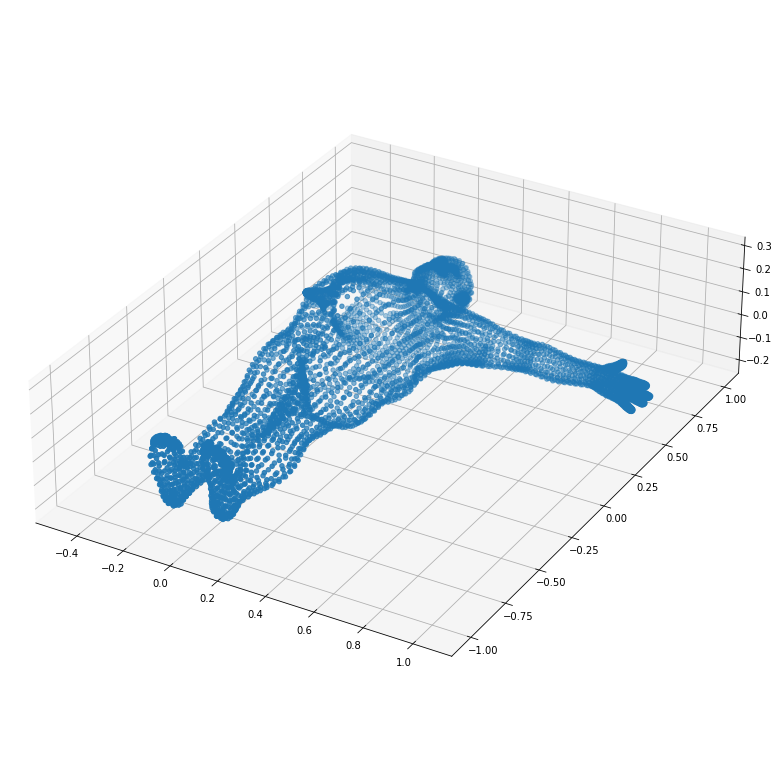

In [ ]:
visualize_pointcloud(test_p[2])

In [ ]:
# Encode Full Shape
test_latent_f_x = model_2.encode(torch.unsqueeze(test_f[n], 0).cuda())
# Encode Partial Shape
test_latent_p_x = model_2.encode(torch.unsqueeze(test_p[n], 0).cuda())

In [ ]:
# Full Shape decoded
test_decoded_f_x = model_2.decode(test_latent_f_x)
test_decoded_p_x = model_2.decode(test_latent_p_x)

In [ ]:
save_shape(test_decoded_f_x.detach().cpu().numpy()[0], 'test_6_arm/full_dec_x')
save_shape(test_decoded_p_x.detach().cpu().numpy()[0], 'test_6_arm/partial_dec_x')

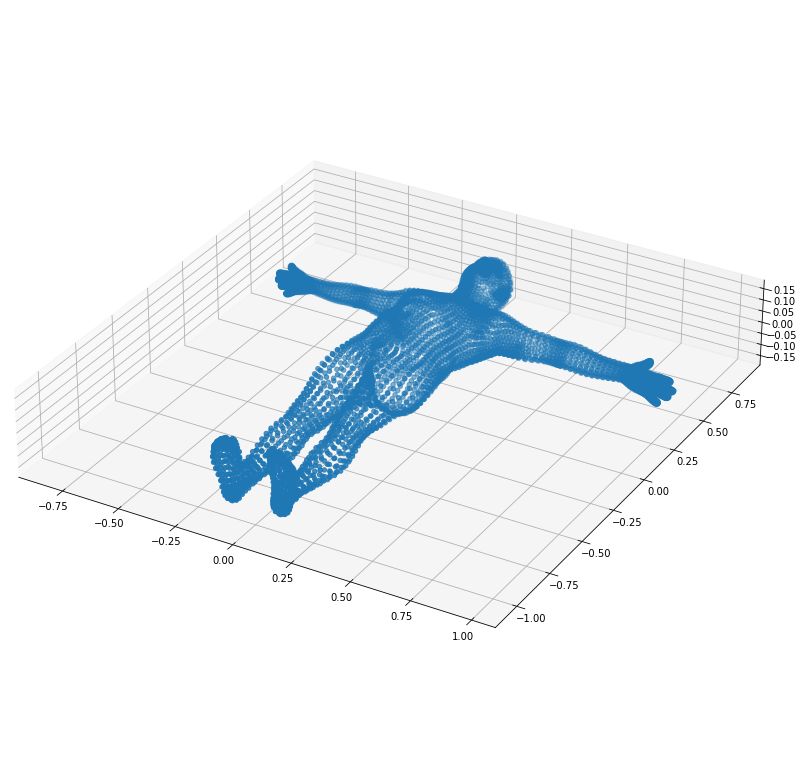

In [ ]:
visualize_pointcloud(test_decoded_f_x.detach().cpu().numpy()[0])

In [ ]:
test_iterator_p = iter(test_dataloader_p)
test_iterator_f = iter(test_dataloader_f)

In [ ]:
test_batch_p = next(test_iterator_p)[0][:2, :, :]
test_batch_f = next(test_iterator_f)[0][:2, :, :]

In [ ]:
#test_latent_p = model.ae_p.encode(test_p[0])
test1 = model.ae_p.encode(torch.unsqueeze(test_p[13], 0).cuda())
test2 = model.ae_p.encode(torch.unsqueeze(test_p[20], 0).cuda())

In [ ]:
# Full Shape decoded
test_decoded1 = model.ae_p.decode(test1)
test_decoded2 = model.ae_p.decode(test2)
#test_decoded_p = model.ae_p.decode(test_latents_p_6)

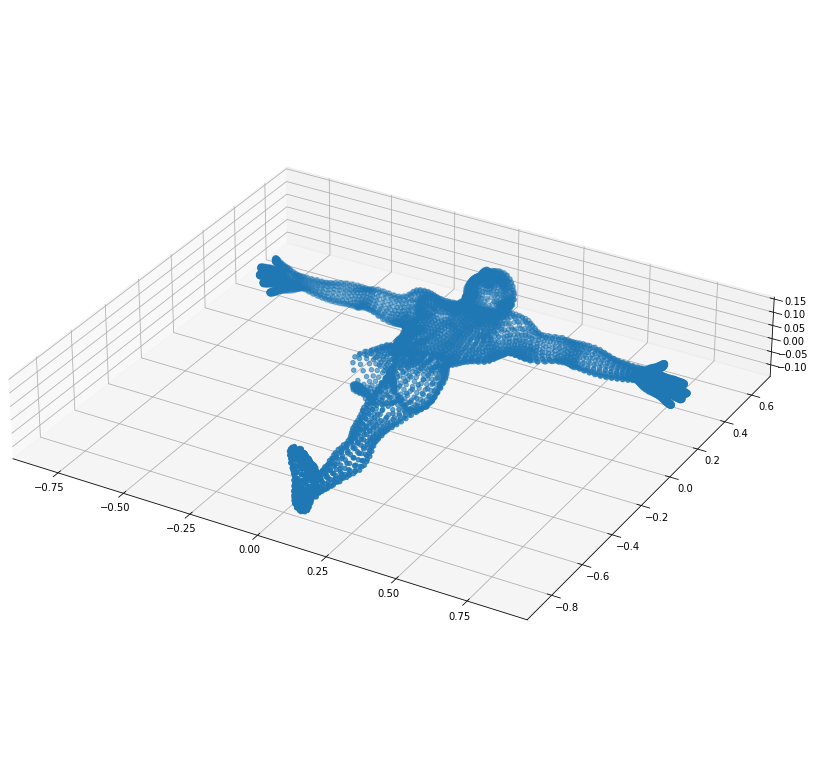

In [ ]:
visualize_pointcloud(test_p[13])

In [ ]:
visualize_pointcloud(test_latent_p_2.detach().cpu().numpy()[0])

In [ ]:
model.eval()

In [ ]:
alpha = 0.8
new_latent = (alpha * test1 + (1 - alpha) * test2).unsqueeze(0)
#new_shape_f = model.ae_f.decoder(new_latent)
new_shape_dec = model.ae_p.decoder(new_latent)

In [ ]:
test_mapped_p = model.map_p_to_f(new_latent[0])
new_shape = model.ae_f.decoder(test_mapped_p)

In [ ]:
visualize_pointcloud(new_shape_dec.detach().cpu().numpy()[0])

In [ ]:
save_shape(new_shape.detach().cpu().numpy()[0], 'interp_ftop08')

In [ ]:
save_shape(new_shape_dec.detach().cpu().numpy()[0], 'interp08')

In [ ]:
save_shape(new_shape_dec.detach().cpu().numpy()[0], 'interp_partial2_p_to_f_0.2')
save_shape(new_shape.detach().cpu().numpy()[0], 'interp_partial2')
save_shape(test_f[9], 'test_f_9')
save_shape(test_f[10], 'test_f_10')

Latent Space Visualization in PCA

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [ ]:
latent_space_full = model.ae_f.encode(test_f.cuda())
latent_space_partial = model.ae_p.encode(test_p.cuda())

In [ ]:
components_full = pca.fit_transform(latent_space_full.detach().cpu().numpy())
#components_partial = pca.fit_transform(latent_space_partial.detach().cpu().numpy())

In [ ]:
components_full.shape

(200, 2)

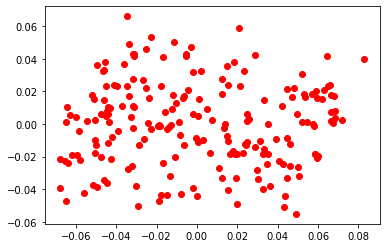

In [ ]:
plt.scatter(components_full[:,0], components_full[:,1], c='r')
#plt.scatter(components_partial[:,0], components_partial[:,1], c='b')

In [ ]:
latent_space_p_to_f = model.map_p_to_f(latent_space_partial)
#latent_space_f_to_p = model.map_f_to_p(latent_space_full)

In [ ]:
components_p_to_f = pca.transform(latent_space_p_to_f.detach().cpu().numpy())
#components_f_to_p = pca.fit_transform(latent_space_f_to_p.detach().cpu().numpy())

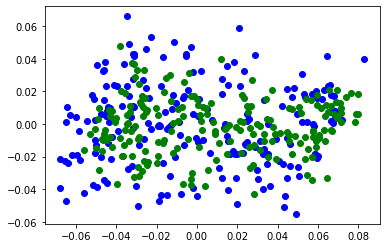

In [ ]:
#plt.scatter(components_f_to_p[:,0], components_f_to_p[:,1], c='r')
plt.scatter(components_full[:,0], components_full[:,1], c='b')
plt.scatter(components_p_to_f[:,0], components_p_to_f[:,1], c='g')

In [ ]:
components_partial = pca.fit_transform(latent_space_partial.detach().cpu().numpy())

In [ ]:
latent_space_f_to_p = model.map_f_to_p(latent_space_full)

In [ ]:
components_f_to_p = pca.transform(latent_space_f_to_p.detach().cpu().numpy())

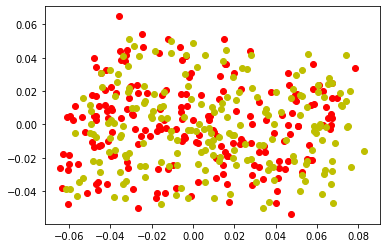

In [ ]:
plt.scatter(components_partial[:,0], components_partial[:,1], c='r')
plt.scatter(components_f_to_p[:,0], components_f_to_p[:,1], c='y')

In [ ]:
latent_space_full = model_2.encode(test_f.cuda())

In [ ]:
latent_space_partial = model_2.encode(test_p.cuda())

In [ ]:
components_full = pca.fit_transform(latent_space_full.detach().cpu().numpy())

In [ ]:
components_partial = pca.transform(latent_space_partial.detach().cpu().numpy())

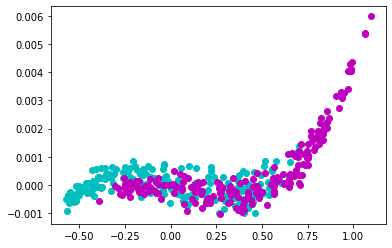

In [ ]:
plt.scatter(components_full[:,0], components_full[:,1], c='c')
plt.scatter(components_partial[:,0], components_partial[:,1], c='m')